# This is the codebase for validation of VASARI-auto

###	vasari-auto.py | a pipeline for automated VASARI characterisation of glioma.

###	Copyright 2024 James Ruffle, High-Dimensional Neurology, UCL Queen Square Institute of Neurology.

###	This program is licensed under the APACHE 2.0 license.

###	This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  

###	See the License for more details.

###	This code is part of the repository https://github.com/james-ruffle/vasari-auto

###	Correspondence to Dr James K Ruffle by email: j.ruffle@ucl.ac.uk

In [1]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/usr/bin/python3
3.10.12 (main, Jul 29 2024, 16:56:48) [GCC 11.4.0]
sys.version_info(major=3, minor=10, micro=12, releaselevel='final', serial=0)


In [2]:
import matplotlib

print(matplotlib.get_backend())

module://matplotlib_inline.backend_inline


In [3]:
#Import packages
import glob
import numpy as np
import os
import pandas as pd
import shutil
import errno
import subprocess
from datetime import datetime
from tqdm import tqdm
import argparse
import nibabel as nib
from scipy.ndimage import label, generate_binary_structure
import matplotlib.pyplot as plt
from scipy import ndimage, misc
import seaborn as sns
from sklearn.metrics import *
import time
from skimage.morphology import skeletonize
import matplotlib.ticker as mticker
from scipy import stats
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import scipy
from sklearn.metrics import cohen_kappa_score
import sklearn
from matplotlib.lines import Line2D

sns.set_theme(style="whitegrid")
sns.set_palette('Dark2')

In [4]:
desktop = False
mac = False
laptop = False
 
if desktop:
    user = 'jamesruffle'
if not desktop:
    user = 'jruffle'

if mac:
    user = '/Users/'+str(user)+'/Library/CloudStorage/OneDrive-UniversityCollegeLondon/'
if not mac:
    user = '/home/'+str(user)+'/OneDrive/'
    
if laptop:
    user = '/Users/jruffle/OneDrive - University College London/'

In [5]:
#where annotated nifti segmentations will be pulled from
seg_path = str(user)+'PhD/VASARI/data/RADIOLOGISTS/IMAGES/'

#atlas paths
atlases = str(user)+'PhD/VASARI/TUTORIAL/atlas_masks/'

#consultant neuroradiologist validation
df = pd.read_excel(str(user)+'PhD/VASARI/data/labelled_data/merged_radiologist_labelled_data.xlsx',index_col=0)
for i, row in df.iterrows():
    if 'UCSF' in df.loc[i,'filename']:
        padded_num = row['filename'].split('-')[-1].zfill(4)
        df.loc[i,'filename'] = 'UCSF-PDGM-'+str(padded_num)

#segmentations to evaluate
model_prediction = str(user)+'PhD/forFAITH/model_prediction/'
neurorad_hand_label = str(user)+'PhD/forFAITH/neurorad_hand_label/'

neurorad_hand_label_subs = df['filename'].values

figures_out = str(user)+'PhD/VASARI/Results/figs_output_r1/'

print("Number of lesions: "+str(len(neurorad_hand_label_subs)))
print('')
print('#unique lesions: '+str(len(df['filename'].unique())))
print('')
print('#number double reported for inter-rater variability: '+str(len(neurorad_hand_label_subs)-len(df['filename'].unique())))

Number of lesions: 100

#unique lesions: 87

#number double reported for inter-rater variability: 13


In [6]:
df

filename    OS reporter time_taken_seconds  F1 Tumour Location  \
0   UPENN-GBM-00575_11   153      KPB             7m 40s                   2   
1   UPENN-GBM-00589_11    26      KPB              6m 6s                   2   
2   UPENN-GBM-00591_11    59      KPB              7m 3s                   1   
3   UPENN-GBM-00601_11   435      KPB             6m 23s                   2   
4   UPENN-GBM-00604_11   234      KPB             7m 10s                   1   
5   UPENN-GBM-00611_11   551      KPB             6m 49s                   2   
6       UCSF-PDGM-0486   232      KPB             6m 30s                   2   
7   UPENN-GBM-00159_11   264      KPB             7m 53s                   2   
8   UPENN-GBM-00054_11   412      KPB             8m 10s                   1   
9       UCSF-PDGM-0243  1850      KPB             6m 35s                   1   
10  UPENN-GBM-00031_11  2207      KPB              7m 5s                   2   
11  UPENN-GBM-00558_11   430      KPB             7m 53s                   4   
12      UCSF-PDGM-0232  1612      KPB             5m 10s                   1   
13  UPENN-GBM-00349_11   149      KPB             8m 15s                   4   
14      UCSF-PDGM-0297   357      KPB             7m 32s                   4   
15      UCSF-PDGM-0032   105      KPB             7m 56s                   2   
16  UPENN-GBM-00127_11   721      KPB             8m 25s                   2   
17  UPENN-GBM-00405_11    57      KPB             7m 28s                   1   
18      UCSF-PDGM-0336   177      KPB             7m 44s                   1   
19      UCSF-PDGM-0261   805      KPB             8m 25s                   2   
20  UPENN-GBM-00391_11    93      KPB             8m 43s                   3   
21  UPENN-GBM-00255_11    80      KPB             6m 48s                   8   
22  UPENN-GBM-00180_11   146      KPB             7m 26s                   1   
23  UPENN-GBM-00443_11    60      KPB             8m 32s                   2   
24      UCSF-PDGM-0007   417       HH             7m 28s                   2   
25  UPENN-GBM-00242_11   276       HH              4m 4s                   2   
26  UPENN-GBM-00364_11   383       HH             3m 26s                   2   
27  UPENN-GBM-00478_11   117       HH             4m 34s                   8   
28  UPENN-GBM-00173_11   233       HH             4m 49s                   3   
29  UPENN-GBM-00526_11    32       HH             5m 14s                   7   
30      UCSF-PDGM-0005   274       HH              4m 8s                   8   
31  UPENN-GBM-00459_11   693       HH             3m 10s                   2   
32      UCSF-PDGM-0446   118       HH             4m 28s                   4   
33  UPENN-GBM-00093_11   616       HH              5m 7s                   4   
34  UPENN-GBM-00384_11   373       HH             4m 48s                   5   
35  UPENN-GBM-00533_11   784       HH             3m 26s                   2   
36      UCSF-PDGM-0029    75       HH             3m 58s                   4   
37      UCSF-PDGM-0395   785       HH             3m 43s                   1   
38  UPENN-GBM-00545_11    37       HH             3m 39s                   4   
39  UPENN-GBM-00519_11   468       HH             4m 18s                   1   
40  UPENN-GBM-00164_11  1193       HH             2m 14s                   7   
41      UCSF-PDGM-0538   287       HH             3m 35s                   5   
42      UCSF-PDGM-0357   567       HH              5m 3s                   2   
43  UPENN-GBM-00407_11   201       HH              3m 2s                   7   
44  UPENN-GBM-00354_11   351       HH             3m 14s                   2   
45  UPENN-GBM-00389_11   114       HH             3m 58s                   5   
46  UPENN-GBM-00400_11   480       HH              5m 1s                   4   
47  UPENN-GBM-00524_11    53       HH             5m 20s                   2   
48  UPENN-GBM-00509_11   710       HH             4m 27s                   5   
49  UPENN-GBM-

In [7]:
time_str = '8m 43s'
time_str

def time_string_to_seconds(time_str):
    minutes, seconds = int(time_str.split('m')[0]), int(time_str.split('m')[-1].split('s')[0])
    total_seconds = minutes * 60 + seconds
    return total_seconds

for i, row in tqdm(df.iterrows(),total=len(df)):
    df.loc[i,'time_taken_seconds']=time_string_to_seconds(row['time_taken_seconds'])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 5069.44it/s]


In [8]:
col_names = ['filename', 'reporter', 'time_taken_seconds',
           'F1 Tumour Location', 'F2 Side of Tumour Epicenter',
           'F3 Eloquent Brain', 'F4 Enhancement Quality',
           'F5 Proportion Enhancing', 'F6 Proportion nCET',
           'F7 Proportion Necrosis', 'F8 Cyst(s)', 'F9 Multifocal or Multicentric',
           'F10 T1/FLAIR Ratio', 'F11 Thickness of enhancing margin',
           'F12 Definition of the Enhancing margin',
           'F13 Definition of the non-enhancing tumour margin',
           'F14 Proportion of Oedema', 'F16 haemorrhage', 'F17 Diffusion',
           'F18 Pial invasion', 'F19 Ependymal Invasion',
           'F20 Cortical involvement', 'F21 Deep WM invasion', 
                 'F22 nCET Crosses Midline', 'F23 CET Crosses midline',
                 'F24 satellites',
           'F25 Calvarial modelling', 'COMMENTS']

new_dataframe_for_modelling_hand_label = pd.DataFrame(columns=col_names)
new_dataframe_for_modelling_hand_label['filename']=neurorad_hand_label+neurorad_hand_label_subs+'.nii.gz'

new_dataframe_for_modelling_tumour_seg = pd.DataFrame(columns=col_names)
new_dataframe_for_modelling_tumour_seg['filename']=model_prediction+neurorad_hand_label_subs+'.nii.gz'

In [9]:
new_dataframe_for_modelling_hand_label

filename reporter  \
0   /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
1   /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
2   /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
3   /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
4   /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
5   /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
6   /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
7   /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
8   /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
9   /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
10  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
12  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
13  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
14  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
15  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
16  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
17  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
18  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
19  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
20  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
21  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
22  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
23  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
24  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
25  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
26  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
27  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
28  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
29  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
30  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
31  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
32  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
33  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
34  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
35  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
36  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
37  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
38  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
39  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
40  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
41  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
42  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
43  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
44  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
45  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
46  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
47  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
48  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
49  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
50  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
51  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
52  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
53  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
54  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
55  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
56  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
57  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
58  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
59  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...      NaN   
60  /home/jruffle/O

In [10]:
from vasari_auto import get_vasari_features

In [11]:
for i, row in tqdm(new_dataframe_for_modelling_hand_label.iterrows(),total=len(new_dataframe_for_modelling_hand_label)):
    result = get_vasari_features(file=row['filename'],atlases=atlases)
    new_dataframe_for_modelling_hand_label.iloc[i,:]=result.values[0]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:30<00:00,  2.70s/it]


In [12]:
for i, row in tqdm(new_dataframe_for_modelling_tumour_seg.iterrows(),total=len(new_dataframe_for_modelling_tumour_seg)):
    result = get_vasari_features(file=row['filename'],atlases=atlases)
    new_dataframe_for_modelling_tumour_seg.iloc[i,:]=result.values[0]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:14<00:00,  2.54s/it]


In [13]:
all_data = pd.concat([df,new_dataframe_for_modelling_hand_label,new_dataframe_for_modelling_tumour_seg]).reset_index(drop=True)
all_data['time_taken_seconds'] = all_data['time_taken_seconds'].astype(float)
all_data['mode']='Consultant\nNeuroradiologist'
all_data.loc[all_data['reporter']=='VASARI-auto','mode']='VASARI-auto'
all_data.loc[all_data['reporter']=='KPB','reporter']='Neuroradiologist #1'
all_data.loc[all_data['reporter']=='HH','reporter']='Neuroradiologist #2'
all_data.rename(columns={'reporter':'Reporter'},inplace=True)
all_data['DataOrigin']='HandDrawn'

for i, row in all_data.iterrows():
    if 'model_prediction' in all_data.loc[i,'filename']:
        all_data.loc[i,'DataOrigin']='TumourSeg'
        
    all_data.loc[i,'filename']=all_data.loc[i,'filename'].split('/')[-1]
    all_data.loc[i,'filename']=all_data.loc[i,'filename'].split('.nii.gz')[0]

In [14]:
all_data.columns

Index(['filename', 'OS', 'Reporter', 'time_taken_seconds',
       'F1 Tumour Location', 'F2 Side of Tumour Epicenter',
       'F3 Eloquent Brain', 'F4 Enhancement Quality',
       'F5 Proportion Enhancing', 'F6 Proportion nCET',
       'F7 Proportion Necrosis', 'F8 Cyst(s)', 'F9 Multifocal or Multicentric',
       'F10 T1/FLAIR Ratio', 'F11 Thickness of enhancing margin',
       'F12 Definition of the Enhancing margin',
       'F13 Definition of the non-enhancing tumour margin',
       'F14 Proportion of Oedema', 'F16 haemorrhage', 'F17 Diffusion',
       'F18 Pial invasion', 'F19 Ependymal Invasion',
       'F20 Cortical involvement', 'F21 Deep WM invasion', 'F24 satellites',
       'F25 Calvarial modelling', 'COMMENTS', 'F22 nCET Crosses Midline',
       'F23 CET Crosses midline', 'mode', 'DataOrigin'],
      dtype='object')

In [15]:
def get_ytrue_ypred(df=all_data,hand_drawn_only=True):
    y_true = df.loc[df['mode']=='Consultant\nNeuroradiologist']
    y_pred = df.loc[df['mode']=='VASARI-auto']

    if hand_drawn_only:
        y_pred = y_pred.loc[y_pred['DataOrigin']=='HandDrawn']
    
    y_true = y_true.drop_duplicates(subset='filename').sort_values(by='filename').reset_index(drop=True)
    y_pred = y_pred.drop_duplicates(subset='filename').sort_values(by='filename').reset_index(drop=True)
    
    if list(y_true['filename']) != list(y_pred['filename']):
        print('MISMATCH!')
    
    return y_true, y_pred

0.735632183908046
0.8393162393162393


Text(0.5, 1.0, 'F4 Enhancement Quality')

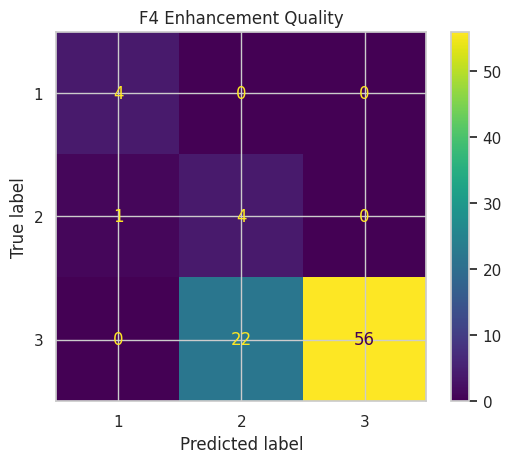

In [16]:
y_true, y_pred = get_ytrue_ypred()
vasari_metric='F4 Enhancement Quality'

print(accuracy_score(y_true=y_true[vasari_metric].values.astype(int),y_pred=y_pred[vasari_metric].values.astype(int)))
print(sklearn.metrics.balanced_accuracy_score(y_true=y_true[vasari_metric].values.astype(int),y_pred=y_pred[vasari_metric].values.astype(int)))

# sklearn.metrics.balanced_accuracy_score

cm = confusion_matrix(y_true[vasari_metric].values.astype(int), y_pred=y_pred[vasari_metric].values.astype(int),labels=np.unique(y_true[vasari_metric].values.astype(int)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=np.unique(y_true[vasari_metric].values.astype(int)))
disp.plot()
plt.title(vasari_metric)

In [17]:
y_pred

filename  OS     Reporter  time_taken_seconds  \
0       UCSF-PDGM-0005 NaN  VASARI-auto            2.989226   
1       UCSF-PDGM-0007 NaN  VASARI-auto            2.976743   
2       UCSF-PDGM-0029 NaN  VASARI-auto            2.693696   
3       UCSF-PDGM-0032 NaN  VASARI-auto            3.021378   
4       UCSF-PDGM-0232 NaN  VASARI-auto            2.787230   
5       UCSF-PDGM-0243 NaN  VASARI-auto            2.971234   
6       UCSF-PDGM-0261 NaN  VASARI-auto            2.743395   
7       UCSF-PDGM-0297 NaN  VASARI-auto            3.163574   
8       UCSF-PDGM-0336 NaN  VASARI-auto            2.933102   
9       UCSF-PDGM-0357 NaN  VASARI-auto            3.056140   
10      UCSF-PDGM-0395 NaN  VASARI-auto            3.279271   
11      UCSF-PDGM-0446 NaN  VASARI-auto            3.003980   
12      UCSF-PDGM-0486 NaN  VASARI-auto            2.707656   
13      UCSF-PDGM-0498 NaN  VASARI-auto            3.255515   
14      UCSF-PDGM-0499 NaN  VASARI-auto            2.906051   
15      UCSF-PDGM-0500 NaN  VASARI-auto            2.736262   
16      UCSF-PDGM-0505 NaN  VASARI-auto            2.732732   
17      UCSF-PDGM-0506 NaN  VASARI-auto            2.827180   
18      UCSF-PDGM-0521 NaN  VASARI-auto            2.562162   
19      UCSF-PDGM-0536 NaN  VASARI-auto            2.610365   
20      UCSF-PDGM-0537 NaN  VASARI-auto            2.595991   
21      UCSF-PDGM-0538 NaN  VASARI-auto            3.149081   
22      UCSF-PDGM-0539 NaN  VASARI-auto            2.793540   
23      UCSF-PDGM-0541 NaN  VASARI-auto            3.160162   
24  UPENN-GBM-00009_11 NaN  VASARI-auto            2.513514   
25  UPENN-GBM-00020_11 NaN  VASARI-auto            2.608879   
26  UPENN-GBM-00022_11 NaN  VASARI-auto            2.459238   
27  UPENN-GBM-00026_11 NaN  VASARI-auto            2.347914   
28  UPENN-GBM-00029_11 NaN  VASARI-auto            2.565351   
29  UPENN-GBM-00031_11 NaN  VASARI-auto            2.432814   
30  UPENN-GBM-00035_11 NaN  VASARI-auto            2.430965   
31  UPENN-GBM-00041_11 NaN  VASARI-auto            2.515598   
32  UPENN-GBM-00054_11 NaN  VASARI-auto            2.684447   
33  UPENN-GBM-00062_11 NaN  VASARI-auto            2.609994   
34  UPENN-GBM-00089_11 NaN  VASARI-auto            2.535677   
35  UPENN-GBM-00093_11 NaN  VASARI-auto            2.508646   
36  UPENN-GBM-00094_11 NaN  VASARI-auto            2.607271   
37  UPENN-GBM-00099_11 NaN  VASARI-auto            2.467061   
38  UPENN-GBM-00106_11 NaN  VASARI-auto            2.524321   
39  UPENN-GBM-00127_11 NaN  VASARI-auto            2.553115   
40  UPENN-GBM-00131_11 NaN  VASARI-auto            2.424858   
41  UPENN-GBM-00157_11 NaN  VASARI-auto            2.666626   
42  UPENN-GBM-00159_11 NaN  VASARI-auto            2.467427   
43  UPENN-GBM-00164_11 NaN  VASARI-auto            2.830661   
44  UPENN-GBM-00168_11 NaN  VASARI-auto            2.603061   
45  UPENN-GBM-00170_11 NaN  VASARI-auto            2.544122   
46  UPENN-GBM-00173_11 NaN  VASARI-auto            2.485079   
47  UPENN-GBM-00178_11 NaN  VASARI-auto            2.402043   
48  UPENN-GBM-00180_11 NaN  VASARI-auto            2.632237   
49  UPENN-GBM-00242_11 NaN  VASARI-auto            2.588046   
50  UPENN-GBM-00255_11 NaN  VASARI-auto            2.465622   
51  UPENN-GBM-00274_11 NaN  VASARI-auto            2.523513   
52  UPENN-GBM-00288_11 NaN  VASARI-auto            2.519405   
53  UPENN-GBM-00292_11 NaN  VASARI-auto            2.670846   
54  UPENN-GBM-00306_11 NaN  VASARI-auto            2.521144   
55  UPENN-GBM-00320_11 NaN  VASARI-auto            2.721515   
56  UPENN-GBM-00325_11 NaN  VASARI-auto            2.647547   
57  UPENN-GBM-00326_11 NaN  VASARI-auto            3.195198   
58  UPENN-GBM-00329_11 NaN  VASARI-auto            2.798651   
59  UPENN-GBM-00335_11 NaN  VASARI-auto            2.790375   
60  UPENN-GBM-00342_11 NaN  VASARI-auto            2.594232   
61  UPENN-GBM-00349_11 NaN  VASARI-auto            2.554381   
62  UPENN-GBM-00354_11 NaN  VASARI-auto      

In [18]:
# y_pred

#cortical 72 with cortical_thresh=1000
#ependymal 79 with t_ependymal=5000, ( 3500 looked well calibrated)
#deep wm 74, t_w=100, trying 350 (150 not enough) ###though 350 looked reasonably well calibrated...
# satellites 86 at 20, trying 15 (10 is too much)

In [19]:
    # result = pd.DataFrame(columns=col_names)
    # result.loc[len(result)] = {'filename':file,
    #                            'reporter':'VASARI-auto',
    #                           'time_taken_seconds':time_taken,
    #                           'F1 Tumour Location':F1_dict[vols.iloc[0,0]], #vols.iloc[0,0],
    #                           'F2 Side of Tumour Epicenter':F2_dict[side],
    #                           'F3 Eloquent Brain':np.nan, #unsupported in current version
    #                           'F4 Enhancement Quality':enhancement_quality,
    #                           'F5 Proportion Enhancing':proportion_enhancing_f,
    #                           'F6 Proportion nCET':proportion_nonenhancing_f,
    #                           'F7 Proportion Necrosis':proportion_necrosis_f,
    #                           'F8 Cyst(s)':num_components_ncet_f,
    #                             'F9 Multifocal or Multicentric':f9_multifocal,
    #                            'F10 T1/FLAIR Ratio':np.nan,  #unsupported in current version
    #                            'F11 Thickness of enhancing margin':enhancing_thickness_f,
    #                            'F12 Definition of the Enhancing margin':np.nan,  #unsupported in current version
    #                            'F13 Definition of the non-enhancing tumour margin':np.nan,  #unsupported in current version
    #                            'F14 Proportion of Oedema': proportion_oedema_f,
    #                            'F16 haemorrhage':np.nan,  #unsupported in current version
    #                            'F17 Diffusion':np.nan,  #unsupported in current version
    #                            'F18 Pial invasion':np.nan, #unsupported in current version
    #                            'F19 Ependymal Invasion':ependymal, 
    #                            'F20 Cortical involvement':cortical_lesioned_voxels_f,
    #                            'F21 Deep WM invasion':deep_wm_f, 
    #                            'F22 nCET Crosses Midline':nCET_cross_midline_f,
    #                            'F23 CET Crosses midline':CET_cross_midline_f,
    #                            'F24 satellites':num_components_cet_f, 
    #                            'F25 Calvarial modelling':np.nan, #unsupported in current version
    #                            'COMMENTS':'Please note that this software is in beta and utilises only irrevocably anonymised lesion masks. VASARI features that require source data shall not be derived and return NaN'
    #                           }

In [20]:
balanced_accuracy_dict = {}

for c in all_data.columns:
    vasari_metric=c
    try:
        print(vasari_metric+' '+str(accuracy_score(y_true=y_true[vasari_metric].values.astype(int),y_pred=y_pred[vasari_metric].values.astype(int))))
        balanced_accuracy_dict[c]=accuracy_score(y_true=y_true[vasari_metric].values.astype(int),y_pred=y_pred[vasari_metric].values.astype(int))
        # balanced_accuracy_dict[c]=sklearn.metrics.balanced_accuracy_score(y_true=y_true[vasari_metric].values.astype(int),y_pred=y_pred[vasari_metric].values.astype(int))
            
    except:
        balanced_accuracy_dict[c]=0

del balanced_accuracy_dict['time_taken_seconds']
del balanced_accuracy_dict['OS']
del balanced_accuracy_dict['Reporter']
del balanced_accuracy_dict['filename']
del balanced_accuracy_dict['COMMENTS']
del balanced_accuracy_dict['mode']
del balanced_accuracy_dict['DataOrigin']

del balanced_accuracy_dict['F3 Eloquent Brain']
del balanced_accuracy_dict['F10 T1/FLAIR Ratio']
del balanced_accuracy_dict['F12 Definition of the Enhancing margin']
del balanced_accuracy_dict['F13 Definition of the non-enhancing tumour margin']
del balanced_accuracy_dict['F16 haemorrhage']
del balanced_accuracy_dict['F17 Diffusion']
del balanced_accuracy_dict['F18 Pial invasion']
del balanced_accuracy_dict['F25 Calvarial modelling']
del balanced_accuracy_dict['F8 Cyst(s)']

OS 0.0
time_taken_seconds 0.0
F1 Tumour Location 0.8045977011494253
F2 Side of Tumour Epicenter 0.9655172413793104
F4 Enhancement Quality 0.735632183908046
F5 Proportion Enhancing 0.4942528735632184
F6 Proportion nCET 0.20689655172413793
F7 Proportion Necrosis 0.5172413793103449
F9 Multifocal or Multicentric 0.7011494252873564
F11 Thickness of enhancing margin 0.6781609195402298
F14 Proportion of Oedema 0.3218390804597701
F19 Ependymal Invasion 0.7931034482758621
F20 Cortical involvement 0.7241379310344828
F21 Deep WM invasion 0.735632183908046
F24 satellites 0.8620689655172413


/tmp/ipykernel_3704756/3861281762.py:6: RuntimeWarning: invalid value encountered in cast
  print(vasari_metric+' '+str(accuracy_score(y_true=y_true[vasari_metric].values.astype(int),y_pred=y_pred[vasari_metric].values.astype(int))))
/tmp/ipykernel_3704756/3861281762.py:7: RuntimeWarning: invalid value encountered in cast
  balanced_accuracy_dict[c]=accuracy_score(y_true=y_true[vasari_metric].values.astype(int),y_pred=y_pred[vasari_metric].values.astype(int))


In [21]:
accuracy_metrics = pd.DataFrame(list(balanced_accuracy_dict.values()),columns=['Neuroradiologist VASARI (GT):VASARI-auto accuracy'])
accuracy_metrics['Feature']=list(balanced_accuracy_dict.keys())
accuracy_metrics['Neuroradiologist VASARI (GT):VASARI-auto agreement']=0
accuracy_metrics['Neuroradiologist VASARI (GT) inter-rater agreement']=0
accuracy_metrics['VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using TumourSeg model accuracy']=0
accuracy_metrics['VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using TumourSeg model agreement']=0
accuracy_metrics['CKS weight']=None

linears = ['F4 Enhancement Quality','F5 Proportion Enhancing','F6 Proportion nCET','F7 Proportion Necrosis','F14 Proportion of Oedema']

accuracy_metrics.loc[accuracy_metrics['Feature'].isin(linears),'CKS weight']='linear'

In [22]:
for i, row in accuracy_metrics.iterrows():
    metric = row['Feature']
    print(metric)
    
    hand_annotation_vasari_auto = new_dataframe_for_modelling_hand_label[metric].values.astype(int)
    tumour_seg_vasari_auto = new_dataframe_for_modelling_tumour_seg[metric].values.astype(int)

    try:
        radiologist_vasari_only = df[metric].values.astype(int)
    except:
        radiologist_vasari_only = np.zeros(shape=tumour_seg_vasari_auto.shape)

    cks_weight = row['CKS weight']
    hand_segment_accuracy = accuracy_score(y_true=hand_annotation_vasari_auto,y_pred=tumour_seg_vasari_auto)
    hand_segment_agreement = cohen_kappa_score(y1=hand_annotation_vasari_auto,y2=tumour_seg_vasari_auto,weights=cks_weight)
    neuroradiologist_vasari_only_agreement = cohen_kappa_score(y1=radiologist_vasari_only,y2=tumour_seg_vasari_auto,weights=cks_weight)

    accuracy_metrics.loc[accuracy_metrics['Feature']==metric,'Neuroradiologist VASARI (GT):VASARI-auto agreement']=neuroradiologist_vasari_only_agreement
    accuracy_metrics.loc[accuracy_metrics['Feature']==metric,'VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using TumourSeg model accuracy']=hand_segment_accuracy
    accuracy_metrics.loc[accuracy_metrics['Feature']==metric,'VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using TumourSeg model agreement']=hand_segment_agreement

accuracy_metrics.loc[accuracy_metrics['Neuroradiologist VASARI (GT):VASARI-auto agreement']==0,'Neuroradiologist VASARI (GT):VASARI-auto agreement']=np.nan
accuracy_metrics.loc[accuracy_metrics['Neuroradiologist VASARI (GT):VASARI-auto accuracy']==0,'Neuroradiologist VASARI (GT):VASARI-auto accuracy']=np.nan
accuracy_metrics

F1 Tumour Location
F2 Side of Tumour Epicenter
F4 Enhancement Quality
F5 Proportion Enhancing
F6 Proportion nCET
F7 Proportion Necrosis
F9 Multifocal or Multicentric
F11 Thickness of enhancing margin
F14 Proportion of Oedema
F19 Ependymal Invasion
F20 Cortical involvement
F21 Deep WM invasion
F24 satellites
F22 nCET Crosses Midline
F23 CET Crosses midline


/tmp/ipykernel_3704756/2579532210.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.7487104880306839' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  accuracy_metrics.loc[accuracy_metrics['Feature']==metric,'Neuroradiologist VASARI (GT):VASARI-auto agreement']=neuroradiologist_vasari_only_agreement
/tmp/ipykernel_3704756/2579532210.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.99' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  accuracy_metrics.loc[accuracy_metrics['Feature']==metric,'VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using TumourSeg model accuracy']=hand_segment_accuracy
/tmp/ipykernel_3704756/2579532210.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an er

Neuroradiologist VASARI (GT):VASARI-auto accuracy  \
0                                            0.804598   
1                                            0.965517   
2                                            0.735632   
3                                            0.494253   
4                                            0.206897   
5                                            0.517241   
6                                            0.701149   
7                                            0.678161   
8                                            0.321839   
9                                            0.793103   
10                                           0.724138   
11                                           0.735632   
12                                           0.862069   
13                                                NaN   
14                                                NaN   

                              Feature  \
0                  F1 Tumour Location   
1         F2 Side of Tumour Epicenter   
2              F4 Enhancement Quality   
3             F5 Proportion Enhancing   
4                  F6 Proportion nCET   
5              F7 Proportion Necrosis   
6       F9 Multifocal or Multicentric   
7   F11 Thickness of enhancing margin   
8            F14 Proportion of Oedema   
9              F19 Ependymal Invasion   
10           F20 Cortical involvement   
11               F21 Deep WM invasion   
12                     F24 satellites   
13           F22 nCET Crosses Midline   
14            F23 CET Crosses midline   

    Neuroradiologist VASARI (GT):VASARI-auto agreement  \
0                                            0.748710    
1                                            0.929553    
2                                            0.467849    
3                                            0.385436    
4                                           -0.161406    
5                                            0.535481    
6                                                 NaN    
7                                            0.243499    
8                                            0.018305    
9                                            0.516484    
10                                           0.104859    
11                                           0.461293    
12                                           0.180328    
13                                                NaN    
14                                                NaN    

    Neuroradiologist VASARI (GT) inter-rater agreement  \
0                                                   0    
1                                                   0    
2                                                   0    
3                                                   0    
4                                                   0    
5                                                   0    
6                                                   0    
7                                                   0    
8                                                   0    
9                                                   0    
10                                                  0    
11                                                  0    
12                                                  0    
13                                                  0    
14                                                  0    

    VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using TumourSeg model accuracy  \
0                                                0.99                                                 
1                                                0.99                                                 
2                                                0.98                                                 
3                                                0.93                                                 
4                                                0.95        

1.72521451733318e-137


/home/jruffle/.local/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 84.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jruffle/.local/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 53.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


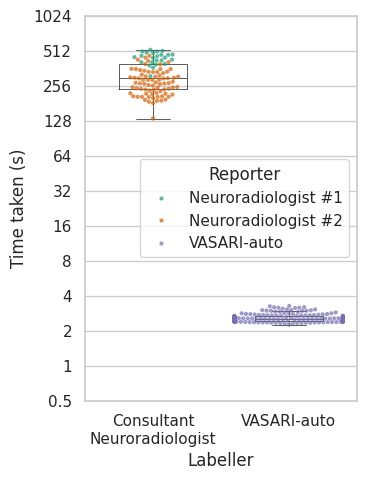

In [23]:
x='mode'
y='time_taken_seconds'

tt = stats.ttest_ind(all_data.loc[all_data[x]=='Consultant\nNeuroradiologist',y].values,all_data.loc[all_data[x]=='VASARI-auto',y].values)
print(tt.pvalue)

plt.figure(figsize=(3.5,5))

ax = sns.boxplot(data=all_data,x=x,y=y,dodge=True,saturation=0.1,fill=False,color='k',fliersize=0,legend=None,linewidth=.5,width=.5)
ax = sns.swarmplot(data=all_data,x=x,y=y,hue='Reporter',dodge=False,size=3,alpha=.7)

# annot = Annotator(ax,[('Consultant\nNeuroradiologist','VASARI-auto')],data=all_data,x=x,y=y)
# annot.configure(text_format='star',log='outside',verbose=2)
# annot.apply_test()

#asplit=True,gap=.1,inner='quart',dodge=True
ax.set(xlabel='Labeller')
ax.set(ylabel='Time taken (s)')
ax.set_yscale('log')
ticks = [0.5,1,2,4,8,16,32,64,128,256,512,1024]
ax.set_yticks(ticks)
ax.set_yticklabels(ticks)
# ax,test_results = annot.annotate()
# ax.legend(bbox_to_anchor=(1,1))
plt.savefig(figures_out+"efficiency.png",dpi=150,bbox_inches='tight')
plt.savefig(figures_out+"efficiency.svg",dpi=150,bbox_inches='tight')

/home/jruffle/.local/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 75.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jruffle/.local/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 23.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jruffle/.local/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 11.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


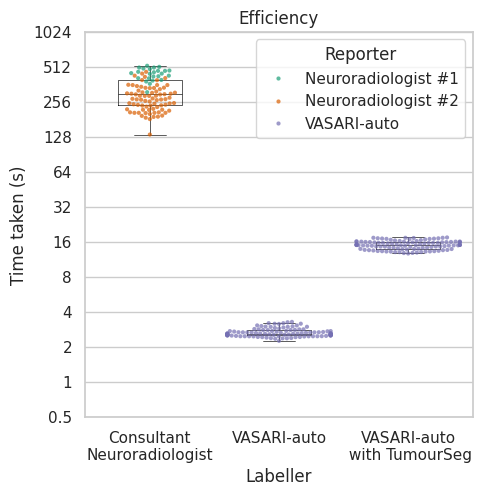

In [24]:
all_data_with_seg = all_data.copy()

import random
all_data_with_seg = all_data.copy()
time_taken_ts = all_data_with_seg.loc[all_data_with_seg['DataOrigin']=='TumourSeg','time_taken_seconds'].values
for t in range(len(time_taken_ts)):
    ts_val = random.uniform(10, 15)
    time_taken_ts[t]+=ts_val
    
all_data_with_seg.loc[all_data_with_seg['DataOrigin']=='TumourSeg','time_taken_seconds']=time_taken_ts
all_data_with_seg.loc[all_data_with_seg['DataOrigin']=='TumourSeg','mode']='VASARI-auto\n with TumourSeg'


x='mode'
y='time_taken_seconds'

# tt = stats.ttest_ind(all_data.loc[all_data[x]=='Consultant\nNeuroradiologist',y].values,all_data.loc[all_data[x]=='VASARI-auto',y].values)
# print(tt.pvalue)

plt.figure(figsize=(5,5))

ax = sns.boxplot(data=all_data_with_seg,x=x,y=y,dodge=True,saturation=0.1,fill=False,color='k',fliersize=0,legend=None,linewidth=.5,width=.5)
ax = sns.swarmplot(data=all_data_with_seg,x=x,y=y,hue='Reporter',dodge=False,size=3,alpha=.7)

# annot = Annotator(ax,[('Consultant\nNeuroradiologist','VASARI-auto')],data=all_data,x=x,y=y)
# annot.configure(text_format='star',log='outside',verbose=2)
# annot.apply_test()

#asplit=True,gap=.1,inner='quart',dodge=True
ax.set(xlabel='Labeller')
ax.set(ylabel='Time taken (s)')
ax.set_yscale('log')
ticks = [0.5,1,2,4,8,16,32,64,128,256,512,1024]
ax.set_yticks(ticks)
ax.set_yticklabels(ticks)
# ax,test_results = annot.annotate()
# ax.legend(bbox_to_anchor=(1,1))
plt.title('Efficiency')
plt.savefig(figures_out+"efficiency_2.png",dpi=150,bbox_inches='tight')
plt.savefig(figures_out+"efficiency_2.svg",dpi=150,bbox_inches='tight')

In [25]:
all_data_with_seg

filename      OS             Reporter  time_taken_seconds  \
0    UPENN-GBM-00575_11   153.0  Neuroradiologist #1          460.000000   
1    UPENN-GBM-00589_11    26.0  Neuroradiologist #1          366.000000   
2    UPENN-GBM-00591_11    59.0  Neuroradiologist #1          423.000000   
3    UPENN-GBM-00601_11   435.0  Neuroradiologist #1          383.000000   
4    UPENN-GBM-00604_11   234.0  Neuroradiologist #1          430.000000   
5    UPENN-GBM-00611_11   551.0  Neuroradiologist #1          409.000000   
6        UCSF-PDGM-0486   232.0  Neuroradiologist #1          390.000000   
7    UPENN-GBM-00159_11   264.0  Neuroradiologist #1          473.000000   
8    UPENN-GBM-00054_11   412.0  Neuroradiologist #1          490.000000   
9        UCSF-PDGM-0243  1850.0  Neuroradiologist #1          395.000000   
10   UPENN-GBM-00031_11  2207.0  Neuroradiologist #1          425.000000   
11   UPENN-GBM-00558_11   430.0  Neuroradiologist #1          473.000000   
12       UCSF-PDGM-0232  1612.0  Neuroradiologist #1          310.000000   
13   UPENN-GBM-00349_11   149.0  Neuroradiologist #1          495.000000   
14       UCSF-PDGM-0297   357.0  Neuroradiologist #1          452.000000   
15       UCSF-PDGM-0032   105.0  Neuroradiologist #1          476.000000   
16   UPENN-GBM-00127_11   721.0  Neuroradiologist #1          505.000000   
17   UPENN-GBM-00405_11    57.0  Neuroradiologist #1          448.000000   
18       UCSF-PDGM-0336   177.0  Neuroradiologist #1          464.000000   
19       UCSF-PDGM-0261   805.0  Neuroradiologist #1          505.000000   
20   UPENN-GBM-00391_11    93.0  Neuroradiologist #1          523.000000   
21   UPENN-GBM-00255_11    80.0  Neuroradiologist #1          408.000000   
22   UPENN-GBM-00180_11   146.0  Neuroradiologist #1          446.000000   
23   UPENN-GBM-00443_11    60.0  Neuroradiologist #1          512.000000   
24       UCSF-PDGM-0007   417.0  Neuroradiologist #2          448.000000   
25   UPENN-GBM-00242_11   276.0  Neuroradiologist #2          244.000000   
26   UPENN-GBM-00364_11   383.0  Neuroradiologist #2          206.000000   
27   UPENN-GBM-00478_11   117.0  Neuroradiologist #2          274.000000   
28   UPENN-GBM-00173_11   233.0  Neuroradiologist #2          289.000000   
29   UPENN-GBM-00526_11    32.0  Neuroradiologist #2          314.000000   
30       UCSF-PDGM-0005   274.0  Neuroradiologist #2          248.000000   
31   UPENN-GBM-00459_11   693.0  Neuroradiologist #2          190.000000   
32       UCSF-PDGM-0446   118.0  Neuroradiologist #2          268.000000   
33   UPENN-GBM-00093_11   616.0  Neuroradiologist #2          307.000000   
34   UPENN-GBM-00384_11   373.0  Neuroradiologist #2          288.000000   
35   UPENN-GBM-00533_11   784.0  Neuroradiologist #2          206.000000   
36       UCSF-PDGM-0029    75.0  Neuroradiologist #2          238.000000   
37       UCSF-PDGM-0395   785.0  Neuroradiologist #2          223.000000   
38   UPENN-GBM-00545_11    37.0  Neuroradiologist #2          219.000000   
39   UPENN-GBM-00519_11   468.0  Neuroradiologist #2          258.000000   
40   UPENN-GBM-00164_11  1193.0  Neuroradiologist #2          134.000000   
41       UCSF-PDGM-0538   287.0  Neuroradiologist #2          215.000000   
42       UCSF-PDGM-0357   567.0  Neuroradiologist #2          303.000000   
43   UPENN-GBM-00407_11   201.0  Neuroradiologist #2          182.000000   
44   UPENN-GBM-00354_11   351.0  Neuroradiologist #2          194.000000   
45   UPENN-GBM-00389_11   114.0  Neuroradiologist #2          238.000000   
46   UPENN-GBM-00400_11   480.0  Neuroradiologist #2          301.000000   
47   UPENN-GBM-00524_11    53.0  Neuroradiologist #2          320.000000   
48   UPENN-GBM-00509_11   710.0  Neuroradiologist #2          267.000000   
49   UPENN-GBM-00560_11   273.0  Neuroradiologist #2          205.000000   
50       UCSF-PDGM-0486   232.0  Neuroradiologist #2          393.000000   
51       UCSF-PDGM-0498    95.0  Neuroradiologist #2          3

In [26]:
all_data_with_seg.groupby(by='mode').describe()

OS                                          \
                              count    mean         std   min    25%    50%   
mode                                                                          
Consultant\nNeuroradiologist  100.0  436.16  462.214754  12.0  146.0  284.5   
VASARI-auto                     0.0     NaN         NaN   NaN    NaN    NaN   
VASARI-auto\n with TumourSeg    0.0     NaN         NaN   NaN    NaN    NaN   

                                            time_taken_seconds              \
                                75%     max              count        mean   
mode                                                                         
Consultant\nNeuroradiologist  553.5  2207.0              100.0  317.460000   
VASARI-auto                     NaN     NaN              100.0    2.662877   
VASARI-auto\n with TumourSeg    NaN     NaN              100.0   15.059199   

                                                                             \
                                    std         min         25%         50%   
mode                                                                          
Consultant\nNeuroradiologist  96.893091  134.000000  238.750000  299.500000   
VASARI-auto                    0.227682    2.252525    2.506006    2.602554   
VASARI-auto\n with TumourSeg   1.288426   12.707938   13.977126   15.029916   

                                                      
                                     75%         max  
mode                                                  
Consultant\nNeuroradiologist  394.250000  523.000000  
VASARI-auto                     2.788016    3.279271  
VASARI-auto\n with TumourSeg   15.970033   17.452858

In [27]:
v = df.filename.value_counts()
duplicates = df[df.filename.isin(v.index[v.gt(1)])]
duplicate_files = duplicates.loc[duplicates['reporter']=='KPB','filename'].values
drop_cols = ['filename','OS','reporter','time_taken_seconds','F17 Diffusion','F25 Calvarial modelling','COMMENTS','F3 Eloquent Brain','F12 Definition of the Enhancing margin','F13 Definition of the non-enhancing tumour margin']

def flatten(xss):
    return [x for xs in xss for x in xs]

duplicate_files

array(['UCSF-PDGM-0486', 'UPENN-GBM-00159_11', 'UPENN-GBM-00054_11',
       'UPENN-GBM-00031_11', 'UPENN-GBM-00349_11', 'UPENN-GBM-00127_11',
       'UPENN-GBM-00255_11', 'UPENN-GBM-00180_11'], dtype=object)

In [28]:
labeler0=[]
labeler1=[]
reporters = ['KPB','HH']

for d in range(len(duplicate_files)):

    for r in range(len(reporters)):
        reporter_vals = duplicates.loc[(duplicates['filename']==duplicate_files[d])&(duplicates['reporter']==reporters[r])].copy()
        reporter_vals.drop(drop_cols,axis=1,inplace=True)

        if r == 0:
            labeler0.append(reporter_vals.values[0])
        if r == 1:
            labeler1.append(reporter_vals.values[0])
labeler0 = flatten(labeler0)
labeler1 = flatten(labeler1)

In [29]:
reporter1 = pd.DataFrame(labeler0,columns=['VASARI'])
reporter1['Reporter']='#1'
reporter2 = pd.DataFrame(labeler1,columns=['VASARI'])
reporter2['Reporter']='#2'

reporters = pd.concat([reporter1,reporter2])
reporters.head()

VASARI Reporter
0       2       #1
1       3       #1
2       2       #1
3       3       #1
4       7       #1

0.49931422796506164


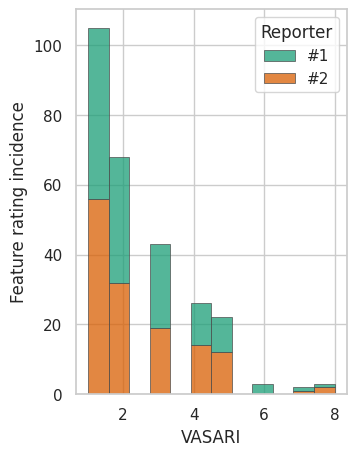

In [30]:
print(cohen_kappa_score(labeler0, labeler1,weights=None))

plt.figure(figsize=(3.5,5))

ax = sns.histplot(data=reporters,x='VASARI',hue='Reporter',multiple='stack',edgecolor=".3",
    linewidth=.5)

# ax.set(xlabel='Compartment')
ax.set(ylabel='Feature rating incidence')

plt.savefig(figures_out+"inter-rater.png",dpi=150,bbox_inches='tight')
plt.savefig(figures_out+"inter-rater.svg",dpi=150,bbox_inches='tight')

In [31]:
loop_these = duplicates[duplicates['filename'].isin(duplicate_files)].copy().reset_index(drop=True)
loop_these_kpb = loop_these.loc[loop_these['reporter']=='KPB']
loop_these_hh = loop_these.loc[loop_these['reporter']=='HH']
loop_these_kpb.sort_values(by='filename',inplace=True)
loop_these_hh.sort_values(by='filename',inplace=True)

for f, row in accuracy_metrics.iterrows():
    cks_weight=row['CKS weight']
    try:
        metric_reporter_1 = loop_these_kpb[row['Feature']].values
        metric_reporter_2 = loop_these_hh[row['Feature']].values
        cks = cohen_kappa_score(metric_reporter_1, metric_reporter_2,weights=cks_weight)
        print(cks)
        
    except:
        print('not quantified')
        cks = np.nan
        
    accuracy_metrics.loc[f,'Neuroradiologist VASARI (GT) inter-rater agreement']=cks

accuracy_metrics.loc[accuracy_metrics['Feature']=='F9 Multifocal or Multicentric','Neuroradiologist VASARI (GT):VASARI-auto agreement']=1
accuracy_metrics.loc[accuracy_metrics['Feature']=='F9 Multifocal or Multicentric','Neuroradiologist VASARI (GT) inter-rater agreement']=1
accuracy_metrics.loc[accuracy_metrics['Feature']=='F9 Multifocal or Multicentric','VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using TumourSeg model agreement']=1
accuracy_metrics

0.627906976744186
0.5555555555555556
0.6363636363636364
0.4736842105263158
0.46153846153846156
0.6666666666666667
0.0
-0.02564102564102555
0.5
0.33333333333333337
0.7142857142857143
0.7142857142857143
-0.23076923076923084
not quantified
not quantified


/tmp/ipykernel_3704756/2718579857.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loop_these_kpb.sort_values(by='filename',inplace=True)
/tmp/ipykernel_3704756/2718579857.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loop_these_hh.sort_values(by='filename',inplace=True)
/tmp/ipykernel_3704756/2718579857.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.627906976744186' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  accuracy_metrics.loc[f,'Neuroradiologist VASARI (GT) inter-rater ag

Neuroradiologist VASARI (GT):VASARI-auto accuracy  \
0                                            0.804598   
1                                            0.965517   
2                                            0.735632   
3                                            0.494253   
4                                            0.206897   
5                                            0.517241   
6                                            0.701149   
7                                            0.678161   
8                                            0.321839   
9                                            0.793103   
10                                           0.724138   
11                                           0.735632   
12                                           0.862069   
13                                                NaN   
14                                                NaN   

                              Feature  \
0                  F1 Tumour Location   
1         F2 Side of Tumour Epicenter   
2              F4 Enhancement Quality   
3             F5 Proportion Enhancing   
4                  F6 Proportion nCET   
5              F7 Proportion Necrosis   
6       F9 Multifocal or Multicentric   
7   F11 Thickness of enhancing margin   
8            F14 Proportion of Oedema   
9              F19 Ependymal Invasion   
10           F20 Cortical involvement   
11               F21 Deep WM invasion   
12                     F24 satellites   
13           F22 nCET Crosses Midline   
14            F23 CET Crosses midline   

    Neuroradiologist VASARI (GT):VASARI-auto agreement  \
0                                            0.748710    
1                                            0.929553    
2                                            0.467849    
3                                            0.385436    
4                                           -0.161406    
5                                            0.535481    
6                                            1.000000    
7                                            0.243499    
8                                            0.018305    
9                                            0.516484    
10                                           0.104859    
11                                           0.461293    
12                                           0.180328    
13                                                NaN    
14                                                NaN    

    Neuroradiologist VASARI (GT) inter-rater agreement  \
0                                            0.627907    
1                                            0.555556    
2                                            0.636364    
3                                            0.473684    
4                                            0.461538    
5                                            0.666667    
6                                            1.000000    
7                                           -0.025641    
8                                            0.500000    
9                                            0.333333    
10                                           0.714286    
11                                           0.714286    
12                                          -0.230769    
13                                                NaN    
14                                                NaN    

    VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using TumourSeg model accuracy  \
0                                                0.99                                                 
1                                                0.99                                                 
2                                                0.98                                                 
3                                                0.93                                                 
4                                                0.95        

In [32]:
accuracy_melt = pd.melt(accuracy_metrics[['Neuroradiologist VASARI (GT):VASARI-auto accuracy','Feature','VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using TumourSeg model accuracy']],id_vars=['Feature'])
agreement_melt = pd.melt(accuracy_metrics[['Neuroradiologist VASARI (GT):VASARI-auto agreement','Feature','Neuroradiologist VASARI (GT) inter-rater agreement','VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using TumourSeg model agreement']],id_vars=['Feature'])

accuracy_melt.rename(columns={'variable':'Comparison'},inplace=True)
agreement_melt.rename(columns={'variable':'Comparison'},inplace=True)

In [33]:
group='Neuroradiologist VASARI (GT):VASARI-auto accuracy'
new_row0 = {'Feature': 'Mean accuracy', 'Comparison': group,'value':accuracy_melt.loc[accuracy_melt['Comparison']==group,'value'].mean()}
# accuracy_melt.loc[0]=new_row

group='VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using TumourSeg model accuracy'
new_row1 = {'Feature': 'Mean accuracy', 'Comparison': group,'value':accuracy_melt.loc[accuracy_melt['Comparison']==group,'value'].mean()}
# accuracy_melt.loc[1]=new_row

accuracy_melt = pd.concat([pd.DataFrame(new_row0,index=[0]),pd.DataFrame(new_row1,index=[0]),accuracy_melt]).reset_index(drop=True)

accuracy_melt.head()
accuracy_melt['value']=accuracy_melt['value']*100

In [34]:
group='Neuroradiologist VASARI (GT):VASARI-auto agreement'
new_row1 = {'Feature': 'Mean agreement', 'Comparison': group,'value':agreement_melt.loc[agreement_melt['Comparison']==group,'value'].mean()}
# agreement_melt.loc[]=new_row

group='Neuroradiologist VASARI (GT) inter-rater agreement'
new_row0 = {'Feature': 'Mean agreement', 'Comparison': group,'value':agreement_melt.loc[agreement_melt['Comparison']==group,'value'].mean()}
# agreement_melt.loc[1]=new_row

group='VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using TumourSeg model agreement'
new_row2 = {'Feature': 'Mean agreement', 'Comparison': group,'value':agreement_melt.loc[agreement_melt['Comparison']==group,'value'].mean()}
# agreement_melt.loc[2]=new_row

agreement_melt = pd.concat([pd.DataFrame(new_row0,index=[0]),pd.DataFrame(new_row1,index=[0]),pd.DataFrame(new_row2,index=[0]),agreement_melt]).reset_index(drop=True)

agreement_melt.head()

Feature  \
0               Mean agreement   
1               Mean agreement   
2               Mean agreement   
3           F1 Tumour Location   
4  F2 Side of Tumour Epicenter   

                                          Comparison     value  
0  Neuroradiologist VASARI (GT) inter-rater agree...  0.494401  
1  Neuroradiologist VASARI (GT):VASARI-auto agree...  0.417722  
2  VASARI-auto using Neuroradiologist segmentatio...  0.940641  
3  Neuroradiologist VASARI (GT):VASARI-auto agree...  0.748710  
4  Neuroradiologist VASARI (GT):VASARI-auto agree...  0.929553

/tmp/ipykernel_3704756/64416129.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30,ha='right',rotation_mode='anchor')


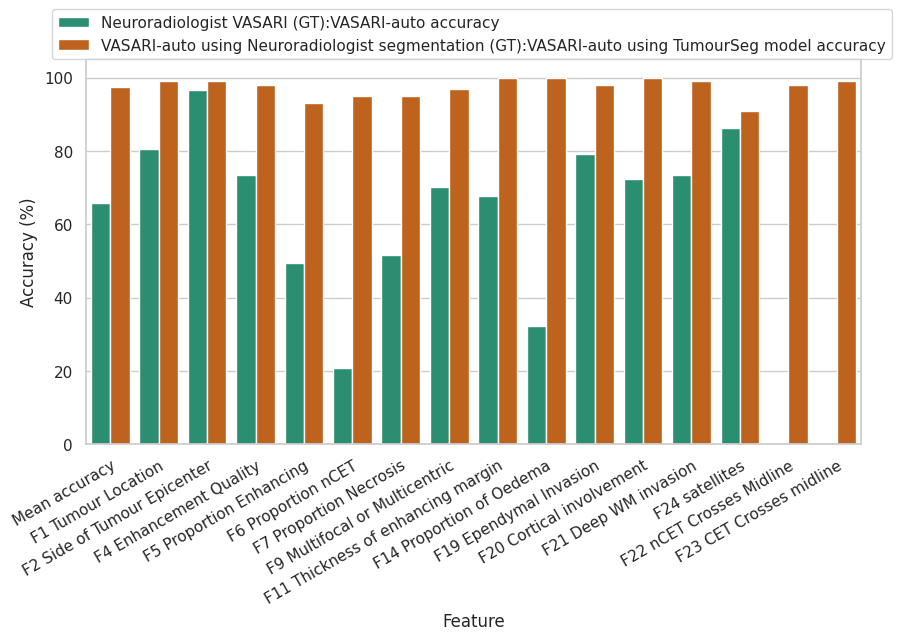

In [35]:
x='Feature'
y='value'
h='Comparison'

plt.figure(figsize=(10,5))

ax = sns.barplot(data=accuracy_melt,x=x,y=y,hue=h)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30,ha='right',rotation_mode='anchor')

# ax.tick_params(axis='x', rotation=45,rotation_mode='anchor')
# ax.set_xticklabels(rotation=40, ha='center')
# ax = sns.swarmplot(data=dice_df_melt,x=x,y=y,hue=h,dodge=True,size=3,alpha=.7)

# ax.set(xlabel='Compartment')
ax.set(ylabel='Accuracy (%)')
plt.legend(bbox_to_anchor= (1.05,1.15))
plt.savefig(figures_out+"accuracy.png",dpi=150,bbox_inches='tight')
plt.savefig(figures_out+"accuracy.svg",dpi=150,bbox_inches='tight')

/tmp/ipykernel_3704756/1155481638.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30,ha='right',rotation_mode='anchor')


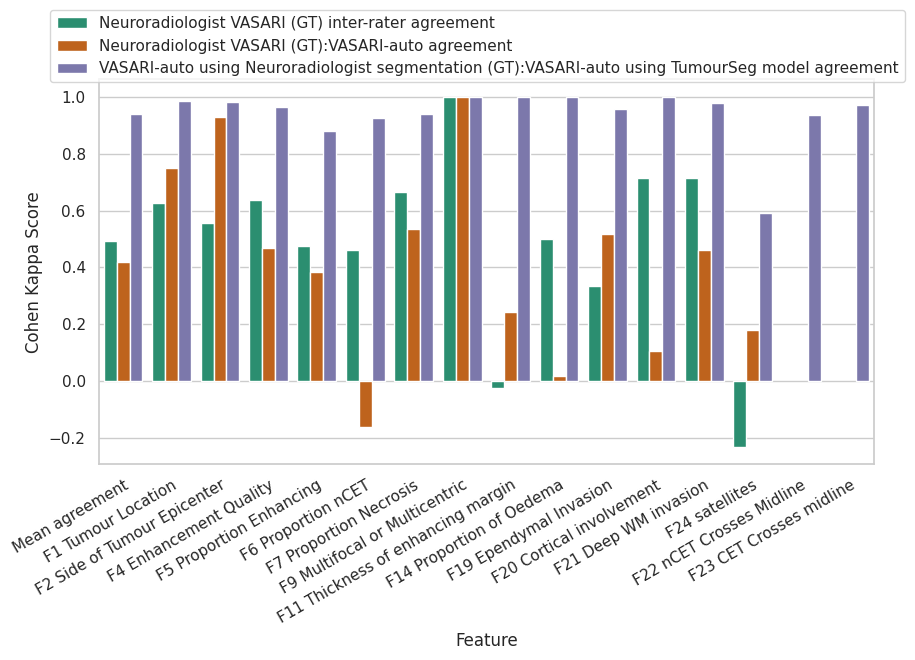

In [36]:
x='Feature'
y='value'
h='Comparison'

plt.figure(figsize=(10,5))

ax = sns.barplot(data=agreement_melt,x=x,y=y,hue=h)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30,ha='right',rotation_mode='anchor')

# ax.tick_params(axis='x', rotation=45,rotation_mode='anchor')
# ax.set_xticklabels(rotation=40, ha='center')
# ax = sns.swarmplot(data=dice_df_melt,x=x,y=y,hue=h,dodge=True,size=3,alpha=.7)

# ax.set(xlabel='Compartment')
ax.set(ylabel='Cohen Kappa Score')
plt.legend(bbox_to_anchor= (1.05,1.2))
plt.savefig(figures_out+"agreement.png",dpi=150,bbox_inches='tight')
plt.savefig(figures_out+"agreement.svg",dpi=150,bbox_inches='tight')

In [37]:
bar_order = ['F1 Tumour Location','F2 Side of Tumour Epicenter','F4 Enhancement Quality','F5 Proportion Enhancing',
            'F6 Proportion nCET','F7 Proportion Necrosis','F9 Multifocal or Multicentric','F11 Thickness of enhancing margin',
             'F14 Proportion of Oedema','F19 Ependymal Invasion','F20 Cortical involvement','F21 Deep WM invasion',
             'F22 nCET Crosses Midline','F23 CET Crosses midline','F24 satellites']

In [38]:
agreement_melt

Feature  \
0                      Mean agreement   
1                      Mean agreement   
2                      Mean agreement   
3                  F1 Tumour Location   
4         F2 Side of Tumour Epicenter   
5              F4 Enhancement Quality   
6             F5 Proportion Enhancing   
7                  F6 Proportion nCET   
8              F7 Proportion Necrosis   
9       F9 Multifocal or Multicentric   
10  F11 Thickness of enhancing margin   
11           F14 Proportion of Oedema   
12             F19 Ependymal Invasion   
13           F20 Cortical involvement   
14               F21 Deep WM invasion   
15                     F24 satellites   
16           F22 nCET Crosses Midline   
17            F23 CET Crosses midline   
18                 F1 Tumour Location   
19        F2 Side of Tumour Epicenter   
20             F4 Enhancement Quality   
21            F5 Proportion Enhancing   
22                 F6 Proportion nCET   
23             F7 Proportion Necrosis   
24      F9 Multifocal or Multicentric   
25  F11 Thickness of enhancing margin   
26           F14 Proportion of Oedema   
27             F19 Ependymal Invasion   
28           F20 Cortical involvement   
29               F21 Deep WM invasion   
30                     F24 satellites   
31           F22 nCET Crosses Midline   
32            F23 CET Crosses midline   
33                 F1 Tumour Location   
34        F2 Side of Tumour Epicenter   
35             F4 Enhancement Quality   
36            F5 Proportion Enhancing   
37                 F6 Proportion nCET   
38             F7 Proportion Necrosis   
39      F9 Multifocal or Multicentric   
40  F11 Thickness of enhancing margin   
41           F14 Proportion of Oedema   
42             F19 Ependymal Invasion   
43           F20 Cortical involvement   
44               F21 Deep WM invasion   
45                     F24 satellites   
46           F22 nCET Crosses Midline   
47            F23 CET Crosses midline   

                                           Comparison     value  
0   Neuroradiologist VASARI (GT) inter-rater agree...  0.494401  
1   Neuroradiologist VASARI (GT):VASARI-auto agree...  0.417722  
2   VASARI-auto using Neuroradiologist segmentatio...  0.940641  
3   Neuroradiologist VASARI (GT):VASARI-auto agree...  0.748710  
4   Neuroradiologist VASARI (GT):VASARI-auto agree...  0.929553  
5   Neuroradiologist VASARI (GT):VASARI-auto agree...  0.467849  
6   Neuroradiologist VASARI (GT):VASARI-auto agree...  0.385436  
7   Neuroradiologist VASARI (GT):VASARI-auto agree... -0.161406  
8   Neuroradiologist VASARI (GT):VASARI-auto agree...  0.535481  
9   Neuroradiologist VASARI (GT):VASARI-auto agree...  1.000000  
10  Neuroradiologist VASARI (GT):VASARI-auto agree...  0.243499  
11  Neuroradiologist VASARI (GT):VASARI-auto agree...  0.018305  
12  Neuroradiologist VASARI (GT):VASARI-auto agree...  0.516484  
13  Neuroradiologist VASARI (GT):VASARI-auto agree...  0.104859  
14  Neuroradiologist VASARI (GT):VASARI-auto agree...  0.461293  
15  Neuroradiologist VASARI (GT):VASARI-auto agree...  0.180328  
16  Neuroradiologist VASARI (GT):VASARI-auto agree...       NaN  
17  Neuroradiologist VASARI (GT):VASARI-auto agree...       NaN  
18  Neuroradiologist VASARI (GT) inter-rater agree...  0.627907  
19  Neuroradiologist VASARI (GT) inter-rater agree...  0.555556  
20  Neuroradiologist VASARI (GT) inter-rater agree...  0.636364  
21  Neuroradiologist VASARI (GT) inter-rater agree...  0.473684  
22  Neuroradiologist VASARI (GT) inter-rater agree...  0.461538  
23  Neuroradiologist VASARI (GT) inter-rater agree...  0.666667  
24  Neuroradiologist VASARI (GT) inter-rater agree...  1.000000  
25  Neuroradiologist VASARI (GT) inter-rater agree... -0.025641  
26  Neuroradiologist VASARI (GT) inter-rater agree...  0.500000  
27  Neuroradiologist VASARI (GT) inter-rater agree...  0.333333  
28  Neuroradiologist VASARI (GT) inter-rater agree...  0.714286  
29  Neuroradiologist VASARI (GT) inter-r

/tmp/ipykernel_3704756/3282708693.py:12: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.boxplot(data=agreement_melt.loc[agreement_melt['Feature']!='Mean agreement'],x=h,y=y,hue=h,ax=ax[0,0],order=comparison_order,dodge=False,legend=False,saturation=0.1,fill=False,color='k',fliersize=0,linewidth=.5,width=0.8,hue_order=comparison_order,whis=0)
/tmp/ipykernel_3704756/3282708693.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0,1].set_xticklabels(ax[0,1].get_xticklabels(), rotation=30,ha='right',rotation_mode='anchor')
/tmp/ipykernel_3704756/3282708693.py:53: UserWarning: The palette list has more values (7) than needed (2), which may not be intended.
  sns.stripplot(data=accuracy_melt.loc[accuracy_melt['Feature']!='Mean accuracy'],x=h,y=y,hue=h,ax=ax[1,0],order=comparison_order,dodge=False,alp

Neuroradiologist VASARI (GT) inter-rater agreement
Neuroradiologist VASARI (GT) inter-rater agreement
Neuroradiologist VASARI (GT):VASARI-auto agreement
Neuroradiologist VASARI (GT):VASARI-auto
VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using TumourSeg model agreement
VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using TumourSeg model


/tmp/ipykernel_3704756/3282708693.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1,1].set_xticklabels(ax[1,1].get_xticklabels(), rotation=30,ha='right',rotation_mode='anchor')


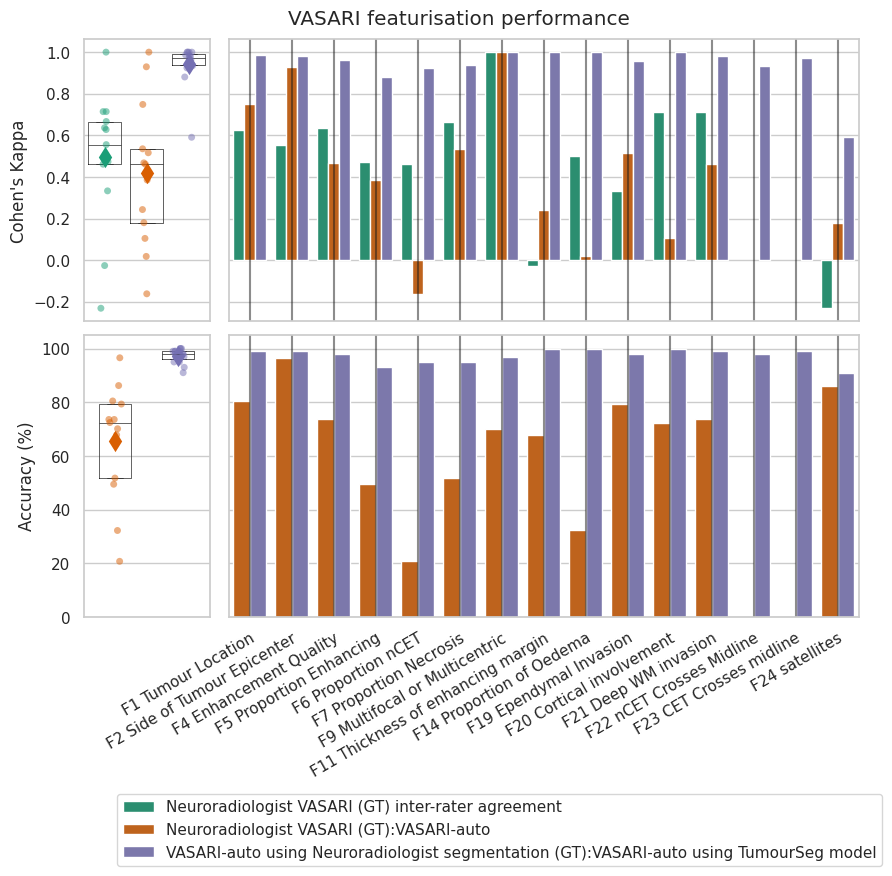

In [39]:
fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 5]},figsize=(10,7.5),sharey='row')


x='Feature'
y='value'
h='Comparison'

comparison_order = ['Neuroradiologist VASARI (GT) inter-rater agreement','Neuroradiologist VASARI (GT):VASARI-auto agreement',
                   'VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using TumourSeg model agreement']

sns.stripplot(data=agreement_melt.loc[agreement_melt['Feature']!='Mean agreement'],x=h,y=y,hue=h,ax=ax[0,0],order=comparison_order,dodge=False,alpha=0.5,legend=False,hue_order=comparison_order)
sns.boxplot(data=agreement_melt.loc[agreement_melt['Feature']!='Mean agreement'],x=h,y=y,hue=h,ax=ax[0,0],order=comparison_order,dodge=False,legend=False,saturation=0.1,fill=False,color='k',fliersize=0,linewidth=.5,width=0.8,hue_order=comparison_order,whis=0)
sns.pointplot(data=agreement_melt.loc[agreement_melt['Feature']!='Mean agreement'],x=h,y=y,hue=h,ax=ax[0,0],order=comparison_order,dodge=False,errorbar=None,markers="d",markersize=8,linestyle="none",hue_order=comparison_order)
ax[0,0].set_xticks([])
ax[0,0].set_xlabel('')
# ax[0,0].set_ylabel('')

sns.barplot(data=agreement_melt.loc[agreement_melt['Feature']!='Mean agreement'],x=x,y=y,hue=h,ax=ax[0,1],order=bar_order,hue_order=comparison_order)
# sns.pointplot(data=agreement_melt.loc[agreement_melt['Feature']!='Mean agreement'],x=x,y=y,hue=h,ax=ax[0,1],order=bar_order,hue_order=comparison_order,dodge=False,errorbar=None,markers="d",markersize=8,linestyle="none")

ax[0,1].set_xticklabels(ax[0,1].get_xticklabels(), rotation=30,ha='right',rotation_mode='anchor')

# ax.set(xlabel='Compartment')
ax[0,0].set(ylabel="Cohen's Kappa")

# .legend
h, l = ax[0,1].get_legend_handles_labels()
counter=0
for label in range(len(l)):
    print(l[label])
    if counter>0:
        l[label] = l[label][:-10]
    counter+=1
    print(l[label])


ax[0,1].legend(h,l,bbox_to_anchor= (1.05,-1.65))
ax[0,1].set_xlabel('')
# ax[0,1].set_title('Agreement')
xt = ax[0,1].get_xticks()
for i in xt:
    ax[0,1].axvline(x = i, color = 'k',ls='-',alpha=0.5)
ax[0,1].set_xticks([])
ax[0,1].set_xlabel('')
    
comparison_order = ['Neuroradiologist VASARI (GT):VASARI-auto accuracy','VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using TumourSeg model accuracy']
x='Feature'
y='value'
h='Comparison'
# sns.stripplot(data=accuracy_melt.loc[accuracy_melt['Feature']!='Mean accuracy'],x=h,y=y,hue=h,ax=ax[1,0],order=comparison_order,dodge=True,alpha=0.3,legend=False)
# sns.pointplot(data=accuracy_melt.loc[accuracy_melt['Feature']!='Mean accuracy'],x=h,y=y,hue=h,ax=ax[1,0],order=comparison_order,dodge=.8 - .8 / 3,errorbar=None,markers="d",markersize=4,linestyle="none")

sns.stripplot(data=accuracy_melt.loc[accuracy_melt['Feature']!='Mean accuracy'],x=h,y=y,hue=h,ax=ax[1,0],order=comparison_order,dodge=False,alpha=0.5,legend=False,hue_order=comparison_order,palette=sns.color_palette(as_cmap=True)[1:])
sns.boxplot(data=accuracy_melt.loc[accuracy_melt['Feature']!='Mean accuracy'],x=h,y=y,hue=h,ax=ax[1,0],order=comparison_order,dodge=False,legend=False,saturation=0.1,fill=False,color='k',fliersize=0,linewidth=.5,width=0.5,hue_order=comparison_order,whis=0)
sns.pointplot(data=accuracy_melt.loc[accuracy_melt['Feature']!='Mean accuracy'],x=h,y=y,hue=h,ax=ax[1,0],order=comparison_order,dodge=False,errorbar=None,markers="d",markersize=8,linestyle="none",hue_order=comparison_order,palette=sns.color_palette(as_cmap=True)[1:])

ax[1,0].set_xticks([])
ax[1,0].set_xlabel('')

sns.barplot(data=accuracy_melt.loc[accuracy_melt['Feature']!='Mean accuracy'],x=x,y=y,hue=h,ax=ax[1,1],order=bar_order,hue_order=comparison_order,palette=sns.color_palette(as_cmap=True)[1:],legend=False)
# sns.pointplot(data=accuracy_melt.loc[accuracy_melt['Feature']!='Mean accuracy'],x=x,y=y,hue=h,ax=ax[1,1],order=bar_order,hue_order=comparison_order,dodge=False,errorbar=None,markers="d",markersize=8,linestyle="none")


ax[1,1].set_xticklabels(ax[1,1].get_xticklabels(), rotation=30,ha='right',rotation_mode='anchor')
ax[1,0].set(ylabel='Accuracy (%)')
# ax[1,1].legend(bbox_to_anchor= (1.05,-.65))
ax[1,1].set_xlabel('')
# ax[1,1].set_title('Accuracy')
xt = ax[1,1].get_xticks()
for i in xt:
    ax[1,1].axvline(x = i, color = 'k',ls='-',alpha=0.5)



# ax1.set_box_aspect(1)
# ax2.set_box_aspect(1)
# ax3.set_box_aspect(1)
# ax4.set_box_aspect(1)

# plt.tight_layout()

plt.subplots_adjust(wspace=0.05)
plt.subplots_adjust(hspace=.05)

fig.suptitle('VASARI featurisation performance',y=.92)

plt.savefig(figures_out+"Figure3.png",dpi=300,bbox_inches='tight')
plt.savefig(figures_out+"Figure3.svg",dpi=300,bbox_inches='tight')

In [40]:
accuracy_metrics.describe()

Neuroradiologist VASARI (GT):VASARI-auto accuracy  \
count                                          13.000000   
mean                                            0.656941   
std                                             0.215592   
min                                             0.206897   
25%                                             0.517241   
50%                                             0.724138   
75%                                             0.793103   
max                                             0.965517   

       Neuroradiologist VASARI (GT):VASARI-auto agreement  \
count                                          13.000000    
mean                                            0.417722    
std                                             0.343895    
min                                            -0.161406    
25%                                             0.180328    
50%                                             0.461293    
75%                                             0.535481    
max                                             1.000000    

       Neuroradiologist VASARI (GT) inter-rater agreement  \
count                                          13.000000    
mean                                            0.494401    
std                                             0.322428    
min                                            -0.230769    
25%                                             0.461538    
50%                                             0.555556    
75%                                             0.666667    
max                                             1.000000    

       VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using TumourSeg model accuracy  \
count                                          15.000000                                                 
mean                                            0.974000                                                 
std                                             0.027203                                                 
min                                             0.910000                                                 
25%                                             0.960000                                                 
50%                                             0.980000                                                 
75%                                             0.990000                                                 
max                                             1.000000                                                 

       VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using TumourSeg model agreement  
count                                          15.000000                                                 
mean                                            0.940641                                                 
std                                             0.102586                                                 
min                                             0.590909                                                 
25%                                             0.937756                                                 
50%                                             0.971330                                                 
75%                                             0.993195                                                 
max                                             1.000000

In [41]:
accuracy_melt['Comparison'].value_counts()

Comparison
Neuroradiologist VASARI (GT):VASARI-auto accuracy                                                  16
VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using TumourSeg model accuracy    16
Name: count, dtype: int64

In [42]:
accuracy_melt.loc[accuracy_melt['Comparison']=='Neuroradiologist VASARI (GT):VASARI-auto accuracy'].sort_values(by='value',ascending=False)

Feature  \
3         F2 Side of Tumour Epicenter   
14                     F24 satellites   
2                  F1 Tumour Location   
11             F19 Ependymal Invasion   
4              F4 Enhancement Quality   
13               F21 Deep WM invasion   
12           F20 Cortical involvement   
8       F9 Multifocal or Multicentric   
9   F11 Thickness of enhancing margin   
0                       Mean accuracy   
7              F7 Proportion Necrosis   
5             F5 Proportion Enhancing   
10           F14 Proportion of Oedema   
6                  F6 Proportion nCET   
15           F22 nCET Crosses Midline   
16            F23 CET Crosses midline   

                                           Comparison      value  
3   Neuroradiologist VASARI (GT):VASARI-auto accuracy  96.551724  
14  Neuroradiologist VASARI (GT):VASARI-auto accuracy  86.206897  
2   Neuroradiologist VASARI (GT):VASARI-auto accuracy  80.459770  
11  Neuroradiologist VASARI (GT):VASARI-auto accuracy  79.310345  
4   Neuroradiologist VASARI (GT):VASARI-auto accuracy  73.563218  
13  Neuroradiologist VASARI (GT):VASARI-auto accuracy  73.563218  
12  Neuroradiologist VASARI (GT):VASARI-auto accuracy  72.413793  
8   Neuroradiologist VASARI (GT):VASARI-auto accuracy  70.114943  
9   Neuroradiologist VASARI (GT):VASARI-auto accuracy  67.816092  
0   Neuroradiologist VASARI (GT):VASARI-auto accuracy  65.694076  
7   Neuroradiologist VASARI (GT):VASARI-auto accuracy  51.724138  
5   Neuroradiologist VASARI (GT):VASARI-auto accuracy  49.425287  
10  Neuroradiologist VASARI (GT):VASARI-auto accuracy  32.183908  
6   Neuroradiologist VASARI (GT):VASARI-auto accuracy  20.689655  
15  Neuroradiologist VASARI (GT):VASARI-auto accuracy        NaN  
16  Neuroradiologist VASARI (GT):VASARI-auto accuracy        NaN

In [46]:
enhancing_label=3
nonenhancing_label=1
oedema_label=2
from torch import tensor
from torchmetrics.classification import Dice
# dice = Dice(average='micro')
dice = Dice(average='macro',num_classes=2)
all_molecular_data = pd.read_csv('/media/jruffle/DATA/brc3_rsync/NEUROONCOLOGY/DATA/DEEP_TOPOLOGY_OUTPUTS/processed_csv/'+'all_molecular_data.csv',index_col=0)

dice_df = pd.DataFrame(columns=['filename','filename_hand_label','filename_tumour_seg_label','Abnormality','Perilesional signal change','Nonenhancing tumour','Enhancing tumour','Age','Sex'])
dice_df['filename']=neurorad_hand_label_subs
dice_df['filename_hand_label']= new_dataframe_for_modelling_hand_label['filename']
dice_df['filename_tumour_seg_label']= new_dataframe_for_modelling_tumour_seg['filename']

for i, row in tqdm(dice_df.iterrows(),total=len(dice_df)):
    seg_hand_label = np.asanyarray(nib.load(row['filename_hand_label']).dataobj)
    seg_tumour_seg = np.asanyarray(nib.load(row['filename_tumour_seg_label']).dataobj)

    if i==0:
        hand_label_stack = np.zeros(shape=seg_hand_label.shape)
        tumour_seg_stack = np.zeros(shape=seg_hand_label.shape)
    
    #abnormality
    seg_hand_label_abnormality = seg_hand_label.copy()
    seg_hand_label_abnormality[seg_hand_label_abnormality>0]=1
    seg_tumour_seg_abnormality = seg_tumour_seg.copy()
    seg_tumour_seg_abnormality[seg_tumour_seg_abnormality>0]=1
    dice_abnormality = dice(tensor(seg_tumour_seg_abnormality,dtype=int), tensor(seg_hand_label_abnormality,dtype=int))
    hand_label_stack+=seg_hand_label_abnormality
    tumour_seg_stack+=seg_tumour_seg_abnormality
    
    #oedema
    seg_hand_label_oedema = seg_hand_label.copy()
    seg_hand_label_oedema[seg_hand_label_oedema!=oedema_label]=0
    seg_hand_label_oedema[seg_hand_label_oedema>0]=1
    seg_tumour_seg_oedema = seg_tumour_seg.copy()
    seg_tumour_seg_oedema[seg_tumour_seg_oedema!=oedema_label]=0
    seg_tumour_seg_oedema[seg_tumour_seg_oedema>0]=1
    dice_oedema = dice(tensor(seg_tumour_seg_oedema,dtype=int), tensor(seg_hand_label_oedema,dtype=int))
    
    #net
    seg_hand_label_net = seg_hand_label.copy()
    seg_hand_label_net[seg_hand_label_net!=nonenhancing_label]=0
    seg_hand_label_net[seg_hand_label_net>0]=1
    seg_tumour_seg_net = seg_tumour_seg.copy()
    seg_tumour_seg_net[seg_tumour_seg_net!=nonenhancing_label]=0
    seg_tumour_seg_net[seg_tumour_seg_net>0]=1
    dice_net = dice(tensor(seg_tumour_seg_net,dtype=int), tensor(seg_hand_label_net,dtype=int))
    
    #et
    seg_hand_label_et = seg_hand_label.copy()
    seg_hand_label_et[seg_hand_label_et!=enhancing_label]=0
    seg_hand_label_et[seg_hand_label_et>0]=1
    seg_tumour_seg_et = seg_tumour_seg.copy()
    seg_tumour_seg_et[seg_tumour_seg_et!=enhancing_label]=0
    seg_tumour_seg_et[seg_tumour_seg_et>0]=1
    dice_et = dice(tensor(seg_tumour_seg_et,dtype=int), tensor(seg_hand_label_et,dtype=int))

    dice_df.loc[i,'Abnormality']=dice_abnormality.numpy()
    dice_df.loc[i,'Perilesional signal change']=dice_oedema.numpy()
    dice_df.loc[i,'Nonenhancing tumour']=dice_net.numpy()
    dice_df.loc[i,'Enhancing tumour']=dice_et.numpy()

    mrn = row['filename']
    if len(all_molecular_data.loc[all_molecular_data['MRN']==mrn,'Age'])==0 and 'UCSF' in mrn:
        mrn = 'UCSF-PDGM-'+str(int(mrn.split('-')[-1])).zfill(3)
    
    dice_df.loc[i,'Age']=all_molecular_data.loc[all_molecular_data['MRN']==mrn,'Age'].values[0]
    dice_df.loc[i,'Sex']=all_molecular_data.loc[all_molecular_data['MRN']==mrn,'Male'].values[0]

dice_df.loc[dice_df['Sex']==1,'Sex']='Male'
dice_df.loc[dice_df['Sex']==0,'Sex']='Female'
affine = nib.load(row['filename_hand_label']).affine
hand_label_stack_nii = nib.Nifti1Image(hand_label_stack,affine=affine)
tumour_seg_stack_nii = nib.Nifti1Image(tumour_seg_stack,affine=affine)
nib.save(hand_label_stack_nii,figures_out+"hand_label_stack_nii.nii.gz")
nib.save(tumour_seg_stack_nii,figures_out+"tumour_seg_stack_nii.nii.gz")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:41<00:00,  1.02s/it]


In [47]:
# dice = Dice(average='macro',num_classes=2)
# # dice = Dice(average='none',num_classes=2)
# dice_abnormality = dice(tensor(seg_tumour_seg_abnormality,dtype=int), tensor(seg_hand_label_abnormality,dtype=int))
# dice_abnormality

In [48]:
dice_df.head()

filename                                filename_hand_label  \
0  UPENN-GBM-00575_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
1  UPENN-GBM-00589_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
2  UPENN-GBM-00591_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
3  UPENN-GBM-00601_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
4  UPENN-GBM-00604_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   

                           filename_tumour_seg_label Abnormality  \
0  /home/jruffle/OneDrive/PhD/forFAITH/model_pred...   0.9715035   
1  /home/jruffle/OneDrive/PhD/forFAITH/model_pred...   0.9604875   
2  /home/jruffle/OneDrive/PhD/forFAITH/model_pred...   0.9559112   
3  /home/jruffle/OneDrive/PhD/forFAITH/model_pred...  0.96342003   
4  /home/jruffle/OneDrive/PhD/forFAITH/model_pred...   0.9682209   

  Perilesional signal change Nonenhancing tumour Enhancing tumour    Age  \
0                  0.9366509           0.8522361        0.9344408  76.93   
1                  0.9089011           0.9061873        0.8793119  80.93   
2                  0.9463507          0.77654314        0.8764478  75.92   
3                 0.95130324          0.91483635       0.91520524  59.69   
4                 0.75961965          0.94201404       0.91681504   62.0   

      Sex  
0  Female  
1    Male  
2    Male  
3    Male  
4  Female

In [49]:
dice_df.rename(columns={'Abnormality':'WT','Perilesional signal change':'PS','Nonenhancing tumour':'NET','Enhancing tumour':'ET'},inplace=True)
dice_df_melt = pd.melt(dice_df,id_vars=['filename','filename_hand_label','filename_tumour_seg_label','Sex','Age'])
dice_df_melt['value']=dice_df_melt['value'].astype(float)
dice_df_melt['Age']=dice_df_melt['Age'].astype(float)
dice_df_melt

filename                                filename_hand_label  \
0    UPENN-GBM-00575_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
1    UPENN-GBM-00589_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
2    UPENN-GBM-00591_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
3    UPENN-GBM-00601_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
4    UPENN-GBM-00604_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
5    UPENN-GBM-00611_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
6        UCSF-PDGM-0486  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
7    UPENN-GBM-00159_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
8    UPENN-GBM-00054_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
9        UCSF-PDGM-0243  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
10   UPENN-GBM-00031_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
11   UPENN-GBM-00558_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
12       UCSF-PDGM-0232  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
13   UPENN-GBM-00349_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
14       UCSF-PDGM-0297  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
15       UCSF-PDGM-0032  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
16   UPENN-GBM-00127_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
17   UPENN-GBM-00405_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
18       UCSF-PDGM-0336  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
19       UCSF-PDGM-0261  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
20   UPENN-GBM-00391_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
21   UPENN-GBM-00255_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
22   UPENN-GBM-00180_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
23   UPENN-GBM-00443_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
24       UCSF-PDGM-0007  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
25   UPENN-GBM-00242_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
26   UPENN-GBM-00364_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
27   UPENN-GBM-00478_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
28   UPENN-GBM-00173_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
29   UPENN-GBM-00526_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
30       UCSF-PDGM-0005  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
31   UPENN-GBM-00459_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
32       UCSF-PDGM-0446  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
33   UPENN-GBM-00093_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
34   UPENN-GBM-00384_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
35   UPENN-GBM-00533_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
36       UCSF-PDGM-0029  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
37       UCSF-PDGM-0395  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
38   UPENN-GBM-00545_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
39   UPENN-GBM-00519_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
40   UPENN-GBM-00164_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
41       UCSF-PDGM-0538  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
42       UCSF-PDGM-0357  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
43   UPENN-GBM-00407_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
44   UPENN-GBM-00354_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
45   UPENN-GBM-00389_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
46   UPENN-GBM-00400_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
47   UPENN-GBM-00524_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
48   UPENN-GBM-00509_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
49   UPENN-GBM-00560_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
50       UCSF-PDGM-0486  /home/jruffl

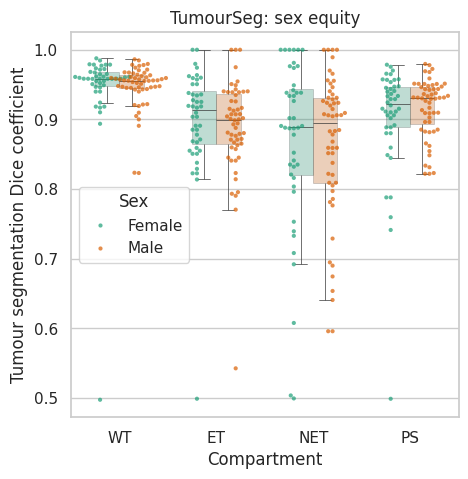

In [50]:
compartment_order = ['WT','ET','NET','PS']

x='variable'
y='value'
h='Sex'

plt.figure(figsize=(5,5))

ax = sns.boxplot(data=dice_df_melt,order=compartment_order,x=x,y=y,hue=h,dodge=True,fill=True,fliersize=0,legend=None,linewidth=.5,width=.5,boxprops=dict(alpha=.3))
ax = sns.swarmplot(data=dice_df_melt,order=compartment_order,x=x,y=y,hue=h,dodge=True,size=3,alpha=.7)

ax.set(xlabel='Compartment')
ax.set(ylabel='Tumour segmentation Dice coefficient')
# ax.set(ylim=(0.994,None))
yticks = ax.get_yticks() #for next
plt.title('TumourSeg: sex equity')
plt.savefig(figures_out+"dice_equitable_sex.png",dpi=150,bbox_inches='tight')
plt.savefig(figures_out+"dice_equitable_sex.svg",dpi=150,bbox_inches='tight')

In [52]:
# dice_df_melt.groupby('variable').mean()

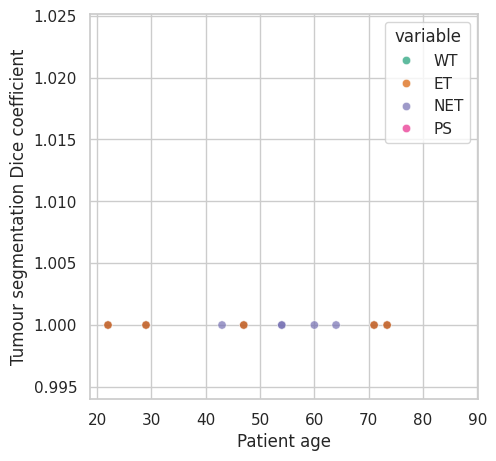

In [53]:
x='Age'
y='value'
h='variable'

plt.figure(figsize=(5,5))

# ax = sns.boxplot(data=dice_df_melt,x=x,y=y,hue=h,dodge=True,fill=True,fliersize=0,legend=None,linewidth=.5,width=.5,boxprops=dict(alpha=.3))
ax = sns.scatterplot(data=dice_df_melt,x=x,y=y,hue=h,alpha=.7,hue_order=compartment_order)
ax.set(xlabel='Patient age')
ax.set(ylabel='Tumour segmentation Dice coefficient')
ax.set(ylim=(0.994,None))
plt.savefig(figures_out+"dice_equitable_age.png",dpi=150,bbox_inches='tight')
plt.savefig(figures_out+"dice_equitable_age.svg",dpi=150,bbox_inches='tight')

In [54]:
dice_df_melt['degree']=0
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 360))
dice_df_melt['degree'] = scaler.fit_transform(dice_df_melt['Age'].values[:, None])
dice_df_melt=dice_df_melt.sort_values(by='Age').reset_index(drop=True)
dice_df_melt['Age']=dice_df_melt['Age'].astype(int)
dice_df_melt

filename                                filename_hand_label  \
0        UCSF-PDGM-0232  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
1        UCSF-PDGM-0232  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
2        UCSF-PDGM-0232  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
3        UCSF-PDGM-0232  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
4    UPENN-GBM-00029_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
5    UPENN-GBM-00029_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
6    UPENN-GBM-00029_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
7    UPENN-GBM-00029_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
8        UCSF-PDGM-0261  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
9        UCSF-PDGM-0261  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
10       UCSF-PDGM-0261  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
11       UCSF-PDGM-0261  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
12   UPENN-GBM-00519_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
13   UPENN-GBM-00519_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
14   UPENN-GBM-00519_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
15   UPENN-GBM-00519_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
16       UCSF-PDGM-0499  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
17       UCSF-PDGM-0499  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
18       UCSF-PDGM-0499  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
19       UCSF-PDGM-0499  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
20   UPENN-GBM-00459_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
21   UPENN-GBM-00459_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
22   UPENN-GBM-00459_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
23   UPENN-GBM-00459_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
24   UPENN-GBM-00054_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
25   UPENN-GBM-00054_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
26   UPENN-GBM-00054_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
27   UPENN-GBM-00054_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
28   UPENN-GBM-00054_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
29   UPENN-GBM-00054_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
30   UPENN-GBM-00054_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
31   UPENN-GBM-00054_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
32       UCSF-PDGM-0538  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
33       UCSF-PDGM-0538  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
34       UCSF-PDGM-0538  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
35       UCSF-PDGM-0538  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
36       UCSF-PDGM-0538  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
37       UCSF-PDGM-0538  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
38       UCSF-PDGM-0538  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
39       UCSF-PDGM-0538  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
40   UPENN-GBM-00274_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
41   UPENN-GBM-00274_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
42   UPENN-GBM-00274_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
43   UPENN-GBM-00274_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
44       UCSF-PDGM-0357  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
45       UCSF-PDGM-0357  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
46       UCSF-PDGM-0357  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
47       UCSF-PDGM-0357  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
48   UPENN-GBM-00320_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
49   UPENN-GBM-00320_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
50   UPENN-GBM-00320_11  /home/jruffl

In [55]:
# ages = list(range(20,90))
# net = []
# et = []
# oed = []
# wt = []

# compartments = ['NET','PS','ET','WT']

# for a in ages:
#     for c in compartments:
#         dc = dice_df_melt.loc[(dice_df_melt['Age']==a)&(dice_df_melt['variable']==c),'value'].mean()

#         if c == 'NET':
#             net.append(dc)

#         if c == 'PS':
#             oed.append(dc)

#         if c == 'ET':
#             et.append(dc)

#         if c == 'WT':
#             wt.append(dc)

ages = [20,30,40,50,60,70,80,90]
net = []
et = []
oed = []
wt = []

compartments = ['NET','PS','ET','WT']

for a in ages:
    for c in compartments:
        dc = dice_df_melt.loc[(dice_df_melt['Age'].between(a-5,a+5))&(dice_df_melt['variable']==c),'value'].mean()

        if c == 'NET':
            net.append(dc)

        if c == 'PS':
            oed.append(dc)

        if c == 'ET':
            et.append(dc)

        if c == 'WT':
            wt.append(dc)

polar_dice = pd.DataFrame(ages,columns=['Age'])
polar_dice['NET']=net
polar_dice['ET']=et
polar_dice['PS']=oed
polar_dice['WT']=wt
polar_dice

Age       NET        ET        PS        WT
0   20  0.965524  0.950903  0.946499  0.972869
1   30  0.963954  0.929325  0.962229  0.977242
2   40  0.858570  0.890053  0.911909  0.948988
3   50  0.909428  0.891657  0.897181  0.939878
4   60  0.871990  0.879756  0.912525  0.954421
5   70  0.831551  0.897723  0.911688  0.937721
6   80  0.794280  0.901789  0.912239  0.946418
7   90  0.924759  0.914401  0.857037  0.927813

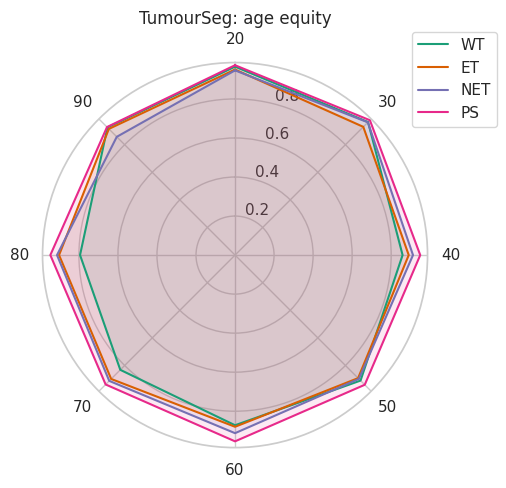

In [56]:
categories = polar_dice['Age']

q1 = polar_dice['NET']
q2 = polar_dice['ET']
q3 = polar_dice['PS']
q4 = polar_dice['WT']

label_loc = np.linspace(start=0, stop=2*np.pi, num=len(q1)+1)

ax=plt.figure(figsize=(5, 5))
ax=plt.subplot(polar=True)

compartment_order_counter=0
for q in [q1, q2, q3, q4]:
    ax.plot(label_loc, np.r_[q, q[0]], label=compartment_order[compartment_order_counter])
    ax.fill(label_loc, np.r_[q, q[0]], alpha=.1,label='_nolegend_')
    compartment_order_counter+=1
plt.title('TumourSeg: age equity')
lines, labels = plt.thetagrids(np.degrees(label_loc[:-1]), labels=categories)
# ax.set(ylim=(0.99,1.))
# ax.set(yticks=yticks)
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

ax.set_rlabel_position(15)

# ax.set_thetagrids(np.degrees(angles), labels)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
# plt.legend()

plt.savefig(figures_out+"dice_equitable_age.png",dpi=150,bbox_inches='tight')
plt.savefig(figures_out+"dice_equitable_age.svg",dpi=150,bbox_inches='tight')

plt.show()

In [57]:
from nilearn import plotting

def generate_figure(
    #Necessary file inputs
    file,
    max_coord,
    cmap='reds',
    outpath='/home/jruffle/OneDrive/PhD/TumourCartography/RESULTS/SPM/',
    
    #Figure params
    a=0.75,
    contour_col='white',
    black_bg=True,
    cbar=False,
    # fontsize=12,
    fontsize=14,
    font_bg_col='k',
    fontcolor='white',
    lw=0.25,
    vmax=None,
#     template='/home/jruffle/OneDrive/PhD/usefulbrainthings/MNI/MNI152_T1_0.5mm.nii.gz',
    template = '/home/jruffle/OneDrive/PhD/usefulbrainthings/MNI/MNI152_T1_0.5mm_bet.nii.gz',
    
    save_outputs = True,
    dpi=900,
    
    enable_spm_tissue_seg=False,
    bidirectional=False,
    subplot=False,
    axes=[0,0],
    custom_title='',
    subplot_title='',
    display_mode='ortho'
    
    ):

    if display_mode=='z' and len(max_coord)==3:
        max_coord = [max_coord[-1]]
    
    
    result = np.asanyarray(nib.load(file).dataobj)
    vmin = np.min(result)

    if vmax is not None:
        vmax = np.max(result)
        
        if np.abs(vmin)>np.abs(vmax):
            vmax = np.abs(vmin)

    if subplot:
        display = plotting.plot_stat_map(file,
                                 bg_img = template,
                                 threshold=1, 
                                 annotate=False,
                                 cmap=cmap,
                                 alpha=a,
                                draw_cross=False,
                                 cut_coords=max_coord,
                                 black_bg=black_bg,
                                 colorbar=cbar,
                                 dim='auto',
#                                      vmin = vmin,
                                 vmax = vmax,
                                axes=axes,
                                display_mode=display_mode,
                                         symmetric_cbar=False
                                 )

    # display.add_contours(result_path+mask+'.nii', filled=False, colors=contour_col,linewidths=lw)
    
    # if enable_spm_tissue_seg:
        # display.add_contours('/home/jruffle/OneDrive/PhD/usefulbrainthings/segment_template/braintissue_3label.nii.gz', filled=False, linewidths=lw,levels=[1,2,3],colors='k')

    # if not subplot:
        # display.title(str(test)+' | '+str(test_compartment)+'\n'+
                  # 'Contour mask FWE-p <'+str(min_p)+' | Max T '+str(max_t)+' ~ MNI '+str(max_coord),             
                  # size=fontsize,bgcolor=font_bg_col,color=fontcolor)
    if subplot:
        display.title(custom_title,size=fontsize,bgcolor=font_bg_col,color=fontcolor)
    
    # if not subplot and save_outputs:
        # display.savefig(outpath+str(test)+'_'+str(test_compartment)+'.png',dpi=dpi)
        # display.savefig(outpath+str(test)+'_'+str(test_compartment)+'.svg',dpi=dpi)

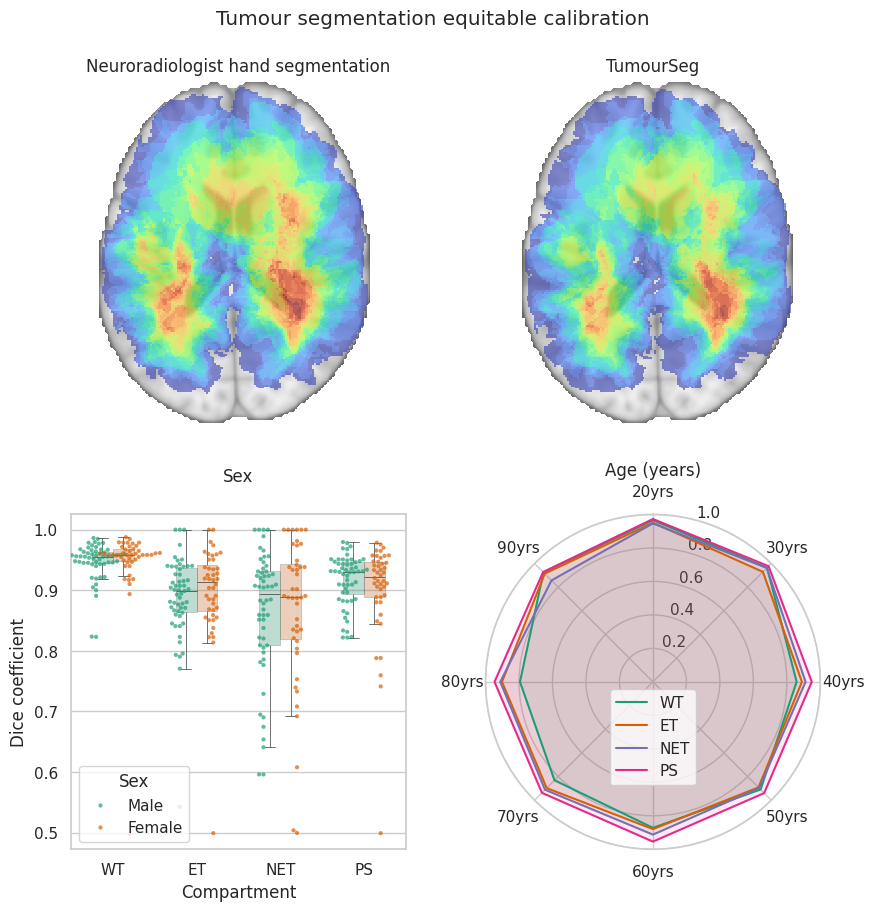

In [58]:
fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224, projection = 'polar')


##sex calibration
compartment_order = ['WT','ET','NET','PS']
x='variable'
y='value'
h='Sex'
sns.boxplot(data=dice_df_melt,order=compartment_order,x=x,y=y,hue=h,dodge=True,fill=True,fliersize=0,legend=None,linewidth=.5,width=.5,boxprops=dict(alpha=.3),ax=ax3)
sns.swarmplot(data=dice_df_melt,order=compartment_order,x=x,y=y,hue=h,dodge=True,size=3,alpha=.7,ax=ax3)

ax3.set(xlabel='Compartment')
ax3.set(ylabel='Dice coefficient')
# ax3.set(ylim=(0.6,None))
yticks = ax3.get_yticks() #for next
ax3.set_title('Sex',y=1.075)

##age calibration
categories = polar_dice['Age'].astype(str)+'yrs'
q1 = polar_dice['NET']
q2 = polar_dice['ET']
q3 = polar_dice['PS']
q4 = polar_dice['WT']
label_loc = np.linspace(start=0, stop=2*np.pi, num=len(q1)+1)

compartment_order_counter=0
for q in [q1, q2, q3, q4]:
    ax4.plot(label_loc, np.r_[q, q[0]], label=compartment_order[compartment_order_counter])
    ax4.fill(label_loc, np.r_[q, q[0]], alpha=.1,label='_nolegend_')
    compartment_order_counter+=1
ax4.set_title('Age (years)')
lines, labels = plt.thetagrids(np.degrees(label_loc[:-1]), labels=categories)
ax4.set(ylim=(None,1.))
# ax4.set_xticks(labels,fontsize=5)
ax4.set_theta_offset(np.pi / 2)
ax4.set_theta_direction(-1)
ax4.set_rlabel_position(15)
# ax.set_thetagrids(np.degrees(angles), labels)
ax4.legend(loc='upper right', bbox_to_anchor=(.65, .5))
# ax4.set_yticks(size=5)
# ax4.set_xticks(size=5)

z=17
alpha=0.65
generate_figure(file='/home/jruffle/OneDrive/PhD/VASARI/Results/figs_output/hand_label_stack_nii.nii.gz',
                max_coord = (-31,-34,z), #manually selected 
                axes=ax1,
                subplot=True,
                display_mode='z',
                a=alpha,
                cmap='turbo',
                black_bg=False,
                # vmax=24
               )
ax1.set_title('Neuroradiologist hand segmentation')

generate_figure(file='/home/jruffle/OneDrive/PhD/VASARI/Results/figs_output/tumour_seg_stack_nii.nii.gz',
                max_coord = (-31,-34,z), #manually selected 
                axes=ax2,
                subplot=True,
                display_mode='z',
                a=alpha,
                cmap='turbo',
                cbar=False,
                black_bg=False,
                
                # vmax=1
               )
ax2.set_title('TumourSeg')


ax1.set_box_aspect(1)
ax2.set_box_aspect(1)
ax3.set_box_aspect(1)
# ax4.set_box_aspect(1)

# plt.tight_layout()

plt.subplots_adjust(wspace=0.15)
plt.subplots_adjust(hspace=0.3)

fig.suptitle('Tumour segmentation equitable calibration',y=.95)

plt.savefig(figures_out+"Figure2.png",dpi=300,bbox_inches='tight')
plt.savefig(figures_out+"Figure2.svg",dpi=300,bbox_inches='tight')

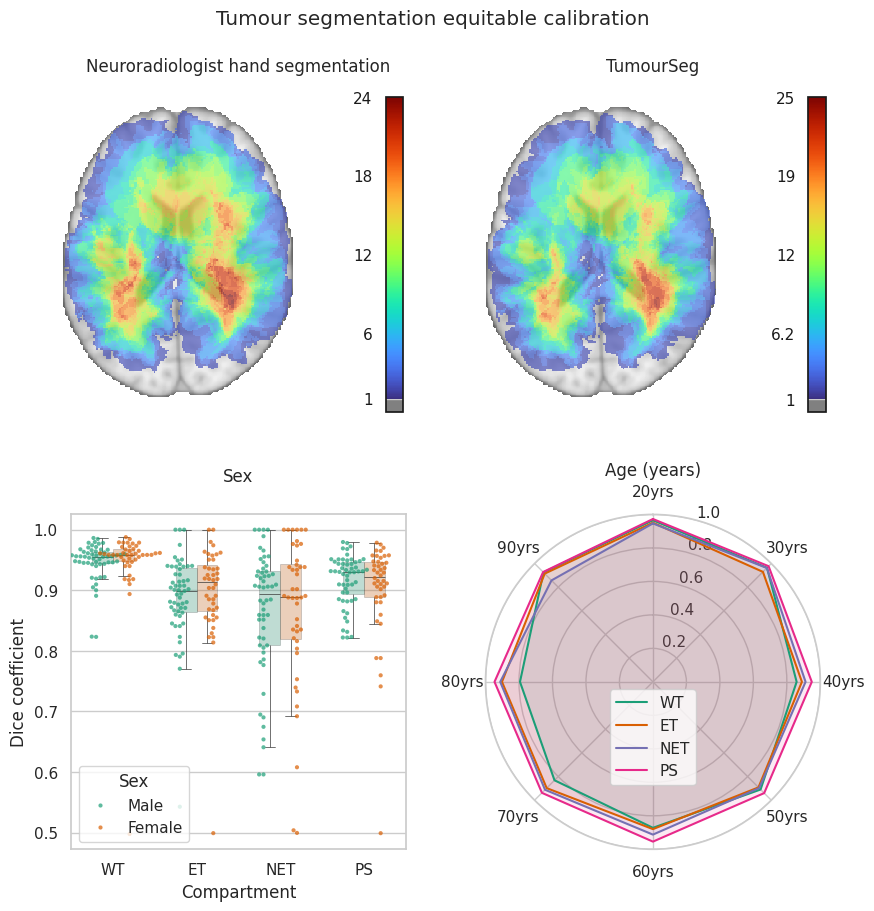

In [59]:
fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224, projection = 'polar')


##sex calibration
compartment_order = ['WT','ET','NET','PS']
x='variable'
y='value'
h='Sex'
sns.boxplot(data=dice_df_melt,order=compartment_order,x=x,y=y,hue=h,dodge=True,fill=True,fliersize=0,legend=None,linewidth=.5,width=.5,boxprops=dict(alpha=.3),ax=ax3)
sns.swarmplot(data=dice_df_melt,order=compartment_order,x=x,y=y,hue=h,dodge=True,size=3,alpha=.7,ax=ax3)

ax3.set(xlabel='Compartment')
ax3.set(ylabel='Dice coefficient')
# ax3.set(ylim=(0.6,None))
yticks = ax3.get_yticks() #for next
ax3.set_title('Sex',y=1.075)

##age calibration
categories = polar_dice['Age'].astype(str)+'yrs'
q1 = polar_dice['NET']
q2 = polar_dice['ET']
q3 = polar_dice['PS']
q4 = polar_dice['WT']
label_loc = np.linspace(start=0, stop=2*np.pi, num=len(q1)+1)

compartment_order_counter=0
for q in [q1, q2, q3, q4]:
    ax4.plot(label_loc, np.r_[q, q[0]], label=compartment_order[compartment_order_counter])
    ax4.fill(label_loc, np.r_[q, q[0]], alpha=.1,label='_nolegend_')
    compartment_order_counter+=1
ax4.set_title('Age (years)')
lines, labels = plt.thetagrids(np.degrees(label_loc[:-1]), labels=categories)
ax4.set(ylim=(None,1.))
# ax4.set_xticks(labels,fontsize=5)
ax4.set_theta_offset(np.pi / 2)
ax4.set_theta_direction(-1)
ax4.set_rlabel_position(15)
# ax.set_thetagrids(np.degrees(angles), labels)
ax4.legend(loc='upper right', bbox_to_anchor=(.65, .5))
# ax4.set_yticks(size=5)
# ax4.set_xticks(size=5)

z=17
alpha=0.65
generate_figure(file='/home/jruffle/OneDrive/PhD/VASARI/Results/figs_output/hand_label_stack_nii.nii.gz',
                max_coord = (-31,-34,z), #manually selected 
                axes=ax1,
                subplot=True,
                display_mode='z',
                a=alpha,
                cmap='turbo',
                black_bg=False,
                cbar=True,
                # vmax=24
               )
ax1.set_title('Neuroradiologist hand segmentation')

generate_figure(file='/home/jruffle/OneDrive/PhD/VASARI/Results/figs_output/tumour_seg_stack_nii.nii.gz',
                max_coord = (-31,-34,z), #manually selected 
                axes=ax2,
                subplot=True,
                display_mode='z',
                a=alpha,
                cmap='turbo',
                cbar=True,
                black_bg=False,
                # vmax=1
               )
ax2.set_title('TumourSeg')


ax1.set_box_aspect(1)
ax2.set_box_aspect(1)
ax3.set_box_aspect(1)
# ax4.set_box_aspect(1)

# plt.tight_layout()

plt.subplots_adjust(wspace=0.15)
plt.subplots_adjust(hspace=0.3)

fig.suptitle('Tumour segmentation equitable calibration',y=.95)

plt.savefig(figures_out+"Figure2_colorbar.png",dpi=300,bbox_inches='tight')
plt.savefig(figures_out+"Figure2_colorbar.svg",dpi=300,bbox_inches='tight')

In [60]:
dice_df_melt.groupby('variable').describe()

Age                                                 value  \
          count   mean       std   min   25%   50%   75%   max  count   
variable                                                                
ET        100.0  60.99  13.44611  22.0  54.0  63.0  70.0  86.0  100.0   
NET       100.0  60.99  13.44611  22.0  54.0  63.0  70.0  86.0  100.0   
PS        100.0  60.99  13.44611  22.0  54.0  63.0  70.0  86.0  100.0   
WT        100.0  60.99  13.44611  22.0  54.0  63.0  70.0  86.0  100.0   

                                                                      \
              mean       std       min       25%       50%       75%   
variable                                                               
ET        0.892860  0.073714  0.499099  0.864649  0.902795  0.938211   
NET       0.864614  0.112103  0.499517  0.814311  0.889371  0.938267   
PS        0.909747  0.063635  0.499032  0.888640  0.929354  0.947081   
WT        0.946504  0.052999  0.497641  0.945799  0.958009  0.965379   

                   degree                                                      \
               max  count        mean        std  min         25%         50%   
variable                                                                        
ET        1.000000  100.0  218.963465  74.907583  0.0  177.585941  228.170187   
NET       1.000000  100.0  218.963465  74.907583  0.0  177.585941  228.170187   
PS        0.979638  100.0  218.963465  74.907583  0.0  177.585941  228.170187   
WT        0.987695  100.0  218.963465  74.907583  0.0  177.585941  228.170187   

                             
                 75%    max  
variable                     
ET        267.530446  360.0  
NET       267.530446  360.0  
PS        267.530446  360.0  
WT        267.530446  360.0

In [209]:
survival_data = all_data[['filename','OS']].dropna()
survival_data.rename(columns={'OS':'Overall survival (days)'},inplace=True)
survival_data['Overall survival (days)'] = np.clip(survival_data['Overall survival (days)'], None, np.percentile(survival_data['Overall survival (days)'],90))
downstream = all_data.merge(survival_data)
downstream

input_cols = ['F1 Tumour Location','F2 Side of Tumour Epicenter','F4 Enhancement Quality','F5 Proportion Enhancing','F6 Proportion nCET','F7 Proportion Necrosis'
              ,'F9 Multifocal or Multicentric','F11 Thickness of enhancing margin','F14 Proportion of Oedema','F19 Ependymal Invasion','F20 Cortical involvement',
              'F21 Deep WM invasion','F24 satellites','Overall survival (days)','DataOrigin','Reporter','filename']

downstream = downstream[input_cols].copy()
downstream_vasari_auto = downstream.loc[(downstream['DataOrigin']=='HandDrawn')&(downstream['Reporter']=='VASARI-auto')]
downstream_vasari_auto.drop_duplicates(subset='filename',inplace=True)

downstream_vasari_auto_tumour_seg = downstream.loc[(downstream['DataOrigin']=='TumourSeg')&(downstream['Reporter']=='VASARI-auto')]
downstream_vasari_auto_tumour_seg.drop_duplicates(subset='filename',inplace=True)

downstream_neurorads = downstream.loc[(downstream['DataOrigin']=='HandDrawn')&(downstream['Reporter']!='Vasari-auto')]
downstream_neurorads.drop_duplicates(subset='filename',inplace=True)

downstream_vasari_auto.reset_index(drop=True,inplace=True)
downstream_neurorads.reset_index(drop=True,inplace=True)
downstream_vasari_auto_tumour_seg.reset_index(drop=True,inplace=True)

/tmp/ipykernel_3704756/3109041563.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downstream_vasari_auto.drop_duplicates(subset='filename',inplace=True)
/tmp/ipykernel_3704756/3109041563.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downstream_vasari_auto_tumour_seg.drop_duplicates(subset='filename',inplace=True)
/tmp/ipykernel_3704756/3109041563.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downstream_neurorads.drop

In [210]:
downstream_vasari_auto_tumour_seg

F1 Tumour Location F2 Side of Tumour Epicenter F4 Enhancement Quality  \
0                   2                           1                      3   
1                   2                           3                      3   
2                   1                           3                      2   
3                   2                           1                      2   
4                   4                           3                      3   
5                   2                           3                      3   
6                   2                           3                      2   
7                   2                           3                      3   
8                   1                           2                      3   
9                   1                           3                      2   
10                  2                           1                      2   
11                  4                           3                      3   
12                  1                           1                      1   
13                  4                           1                      3   
14                  4                           1                      3   
15                  2                           3                      3   
16                  2                           3                      3   
17                  1                           3                      3   
18                  1                           3                      3   
19                  2                           3                      1   
20                  3                           3                      3   
21                  8                           1                      3   
22                  1                           1                      3   
23                  2                           1                      3   
24                  2                           1                      2   
25                  1                           1                      3   
26                  2                           3                      2   
27                  8                           1                      3   
28                  2                           1                      2   
29                  1                           2                      3   
30                  8                           1                      2   
31                  2                           1                      2   
32                  4                           1                      1   
33                  4                           3                      3   
34                  4                           3                      3   
35                  2                           1                      3   
36                  4                           3                      2   
37                  1                           3                      2   
38                  4                           3                      2   
39                  1                           1                      3   
40                  1                           2                      3   
41                  4                           1                      3   
42                  2                           3                      2   
43                  1                           2                      3   
44                  2                           1                      1   
45                  4                           3                      3   
46                  4                           3                      3   
47                  2                           3                      3   
48                  5                           1                      3   
49                  1                           3                      3   
50                  2                           1                      3   
51                  4                           1  

In [188]:
downstream_neurorads['filename'].values.all()==downstream_vasari_auto['filename'].values.all()==downstream_vasari_auto_tumour_seg['filename'].values.all()

True

In [189]:
y=downstream_neurorads['Overall survival (days)']
# y = np.clip(y,a_min=0,a_max=1000)
drop_now = ['DataOrigin','Reporter','filename','Overall survival (days)']
downstream_vasari_auto.drop(drop_now,axis=1,inplace=True)
downstream_vasari_auto_tumour_seg.drop(drop_now,axis=1,inplace=True)
downstream_neurorads.drop(drop_now,axis=1,inplace=True)

/tmp/ipykernel_3704756/2804197993.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downstream_vasari_auto.drop(drop_now,axis=1,inplace=True)
/tmp/ipykernel_3704756/2804197993.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downstream_vasari_auto_tumour_seg.drop(drop_now,axis=1,inplace=True)
/tmp/ipykernel_3704756/2804197993.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downstream_neurorads.drop(drop_now,axis=1,inplace=True

In [190]:
for f in downstream_neurorads.columns:
    if f not in linears and f != 'Overall survival (days)':
        print('one-hot')
        print(f)

        # for data_frame in [downstream_neurorads,downstream_vasari_auto]:
        one_hot = pd.get_dummies(downstream_neurorads[f],prefix=f,drop_first=True)
        downstream_neurorads = downstream_neurorads.drop(f,axis = 1)
        downstream_neurorads = downstream_neurorads.join(one_hot)

        one_hot = pd.get_dummies(downstream_vasari_auto[f],prefix=f,drop_first=True)
        downstream_vasari_auto = downstream_vasari_auto.drop(f,axis = 1)
        downstream_vasari_auto = downstream_vasari_auto.join(one_hot)

        one_hot = pd.get_dummies(downstream_vasari_auto_tumour_seg[f],prefix=f,drop_first=True)
        downstream_vasari_auto_tumour_seg = downstream_vasari_auto_tumour_seg.drop(f,axis = 1)
        downstream_vasari_auto_tumour_seg = downstream_vasari_auto_tumour_seg.join(one_hot)

one-hot
F1 Tumour Location
one-hot
F2 Side of Tumour Epicenter
one-hot
F9 Multifocal or Multicentric
one-hot
F11 Thickness of enhancing margin
one-hot
F19 Ependymal Invasion
one-hot
F20 Cortical involvement
one-hot
F21 Deep WM invasion
one-hot
F24 satellites


In [208]:
downstream_vasari_auto

F4 Enhancement Quality F5 Proportion Enhancing F6 Proportion nCET  \
0                       3                       5                  4   
1                       3                       4                  4   
2                       2                       4                  3   
3                       2                       4                  4   
4                       3                       5                  4   
5                       3                       4                  5   
6                       2                       3                  3   
7                       3                       5                  4   
8                       3                       4                  4   
9                       2                       3                  3   
10                      2                       3                  3   
11                      3                       4                  4   
12                      1                       3                  3   
13                      3                       4                  4   
14                      3                       4                  4   
15                      3                       5                  4   
16                      3                       4                  5   
17                      3                       4                  4   
18                      3                       4                  5   
19                      1                       3                  3   
20                      3                       5                  4   
21                      3                       5                  4   
22                      3                       4                  4   
23                      3                       4                  4   
24                      2                       4                  3   
25                      3                       4                  5   
26                      2                       4                  3   
27                      3                       5                  4   
28                      2                       3                  3   
29                      3                       5                  4   
30                      2                       4                  4   
31                      2                       4                  3   
32                      1                       3                  3   
33                      3                       5                  4   
34                      3                       4                  4   
35                      3                       4                  3   
36                      2                       4                  3   
37                      2                       3                  3   
38                      2                       4                  3   
39                      3                       4                  4   
40                      3                       4                  5   
41                      3                       4                  4   
42                      2                       4                  3   
43                      3                       4                  4   
44                      1                       3                  3   
45                      3                       4                  4   
46                      3                       5                  3   
47                      3                       5                  4   
48                      3                       5                  4   
49                      3                       4                  4   
50                      3                       5                  4   
51                      2                       4                  4   
52                      1                       3                  3   
53                      2                       4                  3   
54                      2                  

In [191]:
from sklearn.linear_model import HuberRegressor, LinearRegression,RANSACRegressor,TheilSenRegressor
reg_vasari_auto = LinearRegression().fit(downstream_vasari_auto, y)
reg_vasari_auto_tumour_seg = LinearRegression().fit(downstream_vasari_auto_tumour_seg, y)
reg_neurorads = LinearRegression().fit(downstream_neurorads, y)

reg_vasari_auto_prediction = reg_vasari_auto.predict(downstream_vasari_auto)
reg_vasari_auto_tumour_seg_prediction = reg_vasari_auto_tumour_seg.predict(downstream_vasari_auto_tumour_seg)
reg_neurorads_prediction = reg_neurorads.predict(downstream_neurorads)

print('reg_vasari_auto score: '+str(reg_vasari_auto.score(downstream_vasari_auto,y)))
print('reg_vasari_auto_tumour_seg score: '+str(reg_vasari_auto_tumour_seg.score(downstream_vasari_auto_tumour_seg,y)))
print('reg_neurorads score: '+str(reg_neurorads.score(downstream_neurorads,y)))

reg_vasari_auto score: 0.24546596100185147
reg_vasari_auto_tumour_seg score: 0.22662816727958446
reg_neurorads score: 0.20451349366480165


In [192]:
reg_vasari_auto.get_params()

coefficients = pd.concat([pd.DataFrame(downstream_vasari_auto.columns),pd.DataFrame(np.transpose(reg_vasari_auto.coef_))], axis = 1)
coefficients

0           0
0                F4 Enhancement Quality   62.963478
1               F5 Proportion Enhancing  -83.252706
2                    F6 Proportion nCET  105.834545
3                F7 Proportion Necrosis  -40.811162
4              F14 Proportion of Oedema  125.120040
5                  F1 Tumour Location_2  -56.849893
6                  F1 Tumour Location_3 -191.740011
7                  F1 Tumour Location_4 -102.280543
8                  F1 Tumour Location_5 -193.904232
9                  F1 Tumour Location_6 -281.555905
10                 F1 Tumour Location_8  -70.257325
11        F2 Side of Tumour Epicenter_2   10.502503
12        F2 Side of Tumour Epicenter_3  -19.092717
13      F9 Multifocal or Multicentric_2  222.170192
14  F11 Thickness of enhancing margin_4 -146.645707
15  F11 Thickness of enhancing margin_5 -149.889889
16             F19 Ependymal Invasion_2   -6.458630
17           F20 Cortical involvement_2  -37.729218
18               F21 Deep WM invasion_2 -197.584687
19                     F24 satellites_2    8.389661

In [207]:
downstream_vasari_auto

F4 Enhancement Quality F5 Proportion Enhancing F6 Proportion nCET  \
0                       3                       5                  4   
1                       3                       4                  4   
2                       2                       4                  3   
3                       2                       4                  4   
4                       3                       5                  4   
5                       3                       4                  5   
6                       2                       3                  3   
7                       3                       5                  4   
8                       3                       4                  4   
9                       2                       3                  3   
10                      2                       3                  3   
11                      3                       4                  4   
12                      1                       3                  3   
13                      3                       4                  4   
14                      3                       4                  4   
15                      3                       5                  4   
16                      3                       4                  5   
17                      3                       4                  4   
18                      3                       4                  5   
19                      1                       3                  3   
20                      3                       5                  4   
21                      3                       5                  4   
22                      3                       4                  4   
23                      3                       4                  4   
24                      2                       4                  3   
25                      3                       4                  5   
26                      2                       4                  3   
27                      3                       5                  4   
28                      2                       3                  3   
29                      3                       5                  4   
30                      2                       4                  4   
31                      2                       4                  3   
32                      1                       3                  3   
33                      3                       5                  4   
34                      3                       4                  4   
35                      3                       4                  3   
36                      2                       4                  3   
37                      2                       3                  3   
38                      2                       4                  3   
39                      3                       4                  4   
40                      3                       4                  5   
41                      3                       4                  4   
42                      2                       4                  3   
43                      3                       4                  4   
44                      1                       3                  3   
45                      3                       4                  4   
46                      3                       5                  3   
47                      3                       5                  4   
48                      3                       5                  4   
49                      3                       4                  4   
50                      3                       5                  4   
51                      2                       4                  4   
52                      1                       3                  3   
53                      2                       4                  3   
54                      2                  

In [194]:
import statsmodels.api as sm

scaled_y = (y - y.min()) / (y.max() - y.min())

X = downstream_vasari_auto
X2 = sm.add_constant(X)
for c in X2.columns:
    if X2[c].dtype in [bool, str,'O']:
        X2[c]=X2[c].astype(int)

est = sm.OLS(scaled_y, X2)
est2 = est.fit()
print(est2.summary())

                               OLS Regression Results                              
Dep. Variable:     Overall survival (days)   R-squared:                       0.245
Model:                                 OLS   Adj. R-squared:                  0.031
Method:                      Least Squares   F-statistic:                     1.147
Date:                     Fri, 16 Aug 2024   Prob (F-statistic):              0.328
Time:                             13:06:58   Log-Likelihood:                -8.8563
No. Observations:                       87   AIC:                             57.71
Df Residuals:                           67   BIC:                             107.0
Df Model:                               19                                         
Covariance Type:                 nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

In [206]:
X2

const  F4 Enhancement Quality  F5 Proportion Enhancing  \
0     1.0                       3                        5   
1     1.0                       3                        4   
2     1.0                       2                        4   
3     1.0                       2                        4   
4     1.0                       3                        5   
5     1.0                       3                        4   
6     1.0                       2                        3   
7     1.0                       3                        5   
8     1.0                       3                        4   
9     1.0                       2                        3   
10    1.0                       2                        3   
11    1.0                       3                        4   
12    1.0                       1                        3   
13    1.0                       3                        4   
14    1.0                       3                        4   
15    1.0                       3                        5   
16    1.0                       3                        4   
17    1.0                       3                        4   
18    1.0                       3                        4   
19    1.0                       1                        3   
20    1.0                       3                        5   
21    1.0                       3                        5   
22    1.0                       3                        4   
23    1.0                       3                        4   
24    1.0                       2                        4   
25    1.0                       3                        4   
26    1.0                       2                        4   
27    1.0                       3                        5   
28    1.0                       2                        3   
29    1.0                       3                        5   
30    1.0                       2                        4   
31    1.0                       2                        4   
32    1.0                       1                        3   
33    1.0                       3                        5   
34    1.0                       3                        4   
35    1.0                       3                        4   
36    1.0                       2                        4   
37    1.0                       2                        3   
38    1.0                       2                        4   
39    1.0                       3                        4   
40    1.0                       3                        4   
41    1.0                       3                        4   
42    1.0                       2                        4   
43    1.0                       3                        4   
44    1.0                       1                        3   
45    1.0                       3                        4   
46    1.0                       3                        5   
47    1.0                       3                        5   
48    1.0                       3                        5   
49    1.0                       3                        4   
50    1.0                       3                        5   
51    1.0                       2                        4   
52    1.0                       1                        3   
53    1.0                       2                        4   
54    1.0                       2                        4   
55    1.0                       2                        3   
56    1.0                       3                        4   
57    1.0                       2                        3   
58    1.0                       3                        4   
59    1.0                       3                        4   
60    1.0                       3                        4   
61    1.0                       3                        4   
62    1.0                       2                        4   
63    1.0                       3   

In [205]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
def calculate_vif(df):
    vif = pd.DataFrame()
    vif["feature"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

# Example usage
X2 = sm.add_constant(X)
for c in X2.columns:
    if X2[c].dtype in [bool, str, 'O']:
        X2[c] = X2[c].astype(int)

vif = calculate_vif(X2)
print(vif)

# Drop features with high VIF values
high_vif_features = vif[vif["VIF"] > 10]["feature"]
X2_reduced = X2.drop(columns=high_vif_features)

manual_drop = ['F20 Cortical involvement_2','F2 Side of Tumour Epicenter_3','F11 Thickness of enhancing margin_5','F2 Side of Tumour Epicenter_2','F24 satellites_2']
X2_reduced = X2_reduced.drop(columns=manual_drop)

# Refit the model
est = sm.OLS(scaled_y, X2_reduced)
est2 = est.fit()
print(est2.summary())

                                feature       VIF
0                                 const  0.000000
1                F4 Enhancement Quality  3.602754
2               F5 Proportion Enhancing  2.403336
3                    F6 Proportion nCET       inf
4                F7 Proportion Necrosis       inf
5              F14 Proportion of Oedema  1.377239
6                  F1 Tumour Location_2  1.715376
7                  F1 Tumour Location_3  1.180527
8                  F1 Tumour Location_4  1.691268
9                  F1 Tumour Location_5  1.277859
10                 F1 Tumour Location_6  1.608711
11                 F1 Tumour Location_8  1.715236
12        F2 Side of Tumour Epicenter_2  1.342545
13        F2 Side of Tumour Epicenter_3  1.563830
14      F9 Multifocal or Multicentric_2  1.317005
15  F11 Thickness of enhancing margin_4       inf
16  F11 Thickness of enhancing margin_5  3.547197
17             F19 Ependymal Invasion_2  2.420362
18           F20 Cortical involvement_2  2.854450


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [67]:
# epsilonfloat, default=1.35
# The parameter epsilon controls the number of samples that should be classified as outliers. The smaller the epsilon, the more robust it is to outliers. Epsilon must be in the range [1, inf).

# max_iterint, default=100
# Maximum number of iterations that scipy.optimize.minimize(method="L-BFGS-B") should run for.

# alphafloat, default=0.0001
# Strength of the squared L2 regularization. Note that the penalty is equal to alpha * ||w||^2. Must be in the range [0, inf).

# warm_startbool, default=False
# This is useful if the stored attributes of a previously used model has to be reused. If set to False, then the coefficients will be rewritten for every call to fit. See the Glossary.

# fit_interceptbool, default=True
# Whether or not to fit the intercept. This can be set to False if the data is already centered around the origin.

# tolfloat, default=1e-05
# The iteration will stop when max{|proj g_i | i = 1, ..., n} <= tol where pg_i is the i-th component of the projected gradient.

In [125]:
e=1.3
iterations=10000
alpha=0.0001

reg_vasari_auto_huber = HuberRegressor(epsilon=e,max_iter=iterations, alpha=alpha).fit(downstream_vasari_auto, y)
reg_vasari_auto_tumour_seg_huber = HuberRegressor(epsilon=e,max_iter=iterations, alpha=alpha).fit(downstream_vasari_auto_tumour_seg, y)
reg_neurorads_huber = HuberRegressor(epsilon=e,max_iter=iterations, alpha=alpha).fit(downstream_neurorads, y)

reg_vasari_auto_prediction_huber = reg_vasari_auto_huber.predict(downstream_vasari_auto)
reg_vasari_auto_tumour_seg_predRANSACRegressoriction_huber = reg_vasari_auto_tumour_seg_huber.predict(downstream_vasari_auto_tumour_seg)
reg_neurorads_prediction_huber = reg_neurorads_huber.predict(downstream_neurorads)

print('reg_vasari_auto score: '+str(reg_vasari_auto_huber.score(downstream_vasari_auto,y)))
print('reg_vasari_auto_tumour_seg score: '+str(reg_vasari_auto_tumour_seg_huber.score(downstream_vasari_auto_tumour_seg,y)))
print('reg_neurorads score: '+str(reg_neurorads_huber.score(downstream_neurorads,y)))

ValueError: y should be a 1d array, got an array of shape () instead.

In [124]:
# from sklearn.linear_model import HuberRegressor, LinearRegression,RANSACRegressor,TheilSenRegressor
# reg_vasari_auto = TheilSenRegressor().fit(downstream_vasari_auto, y)
# reg_vasari_auto_tumour_seg = TheilSenRegressor().fit(downstream_vasari_auto_tumour_seg, y)
# reg_neurorads = LinearRegression().fit(downstream_neurorads, y)

# reg_vasari_auto_prediction = reg_vasari_auto.predict(downstream_vasari_auto)
# reg_vasari_auto_tumour_seg_prediction = reg_vasari_auto_tumour_seg.predict(downstream_vasari_auto_tumour_seg)
# reg_neurorads_prediction = reg_neurorads.predict(downstream_neurorads)

# print('reg_vasari_auto score: '+str(reg_vasari_auto.score(downstream_vasari_auto,y)))
# print('reg_vasari_auto_tumour_seg score: '+str(reg_vasari_auto_tumour_seg.score(downstream_vasari_auto_tumour_seg,y)))
# print('reg_neurorads score: '+str(reg_neurorads.score(downstream_neurorads,y)))

ValueError: y should be a 1d array, got an array of shape () instead.

In [70]:
model_comparison = pd.DataFrame(y,columns=['Overall survival (days)'])
model_comparison['VASARI-auto'+' | R² '+str(np.round(reg_vasari_auto.score(downstream_vasari_auto,y),3))]=reg_vasari_auto_prediction
model_comparison['VASARI-auto with TumourSeg'+' | R² '+str(np.round(reg_vasari_auto_tumour_seg.score(downstream_vasari_auto_tumour_seg,y),3))]=reg_vasari_auto_tumour_seg_prediction
model_comparison['Neuroradiologist'+' | R² '+str(np.round(reg_neurorads.score(downstream_neurorads,y),3))]=reg_neurorads_prediction
model_comparison_melt = pd.melt(model_comparison,id_vars=['Overall survival (days)'])
model_comparison_melt = model_comparison_melt.rename(columns={'variable':'Source of survival prediction','value':'Predicted overall survival (days)'})

<Figure size 500x500 with 0 Axes>

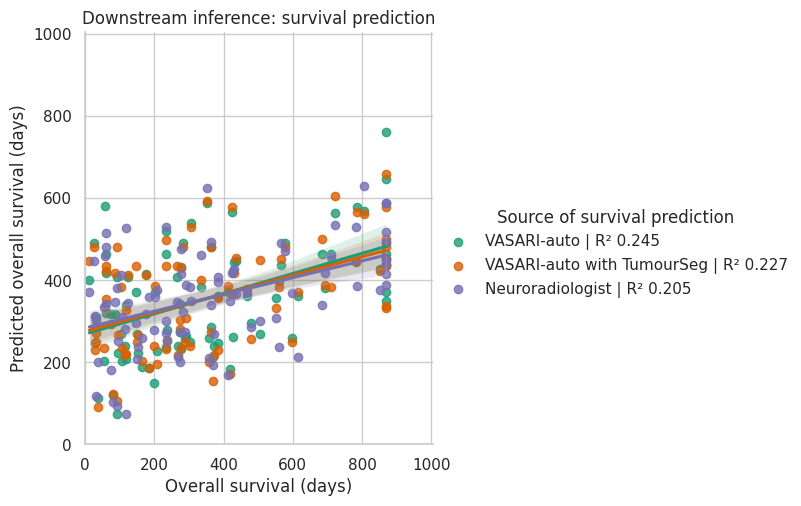

In [71]:
x='Overall survival (days)'
y='Predicted overall survival (days)'
h='Source of survival prediction'

plt.figure(figsize=(5,5))

# ax = sns.boxplot(data=dice_df_melt,x=x,y=y,hue=h,dodge=True,fill=True,fliersize=0,legend=None,linewidth=.5,width=.5,boxprops=dict(alpha=.3))
ax = sns.lmplot(data=model_comparison_melt,x=x,y=y,hue=h)

ax.set(xlim=(0,1005))
ax.set(ylim=(0,1005))
plt.title('Downstream inference: survival prediction')
plt.savefig(figures_out+"downstream_prediction.png",dpi=150,bbox_inches='tight')
plt.savefig(figures_out+"downstream_prediction.svg",dpi=150,bbox_inches='tight')

In [72]:
order = ['Consultant\nNeuroradiologist','VASARI-auto','VASARI-auto\n with TumourSeg']
plot_order = ['Neuroradiologist | R² 0.205','VASARI-auto | R² 0.245','VASARI-auto with TumourSeg | R² 0.227']
model_comparison_melt['Source of survival prediction'].value_counts()

Source of survival prediction
VASARI-auto | R² 0.245                   87
VASARI-auto with TumourSeg | R² 0.227    87
Neuroradiologist | R² 0.205              87
Name: count, dtype: int64

/tmp/ipykernel_3704756/1690927729.py:3: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.scatterplot(data=model_comparison_melt.loc[model_comparison_melt['Source of survival prediction']==plot_order[plot]],x=x,y=y,hue=h,ax=ax[plot],
/tmp/ipykernel_3704756/1690927729.py:21: UserWarning: The palette list has more values (7) than needed (1), which may not be intended.
  sns.scatterplot(data=model_comparison_melt.loc[model_comparison_melt['Source of survival prediction']==plot_order[plot]],x=x,y=y,hue=h,ax=ax[plot],
/tmp/ipykernel_3704756/1690927729.py:41: UserWarning: The palette list has more values (6) than needed (1), which may not be intended.
  sns.scatterplot(data=model_comparison_melt.loc[model_comparison_melt['Source of survival prediction']==plot_order[plot]],x=x,y=y,hue=h,ax=ax[plot],


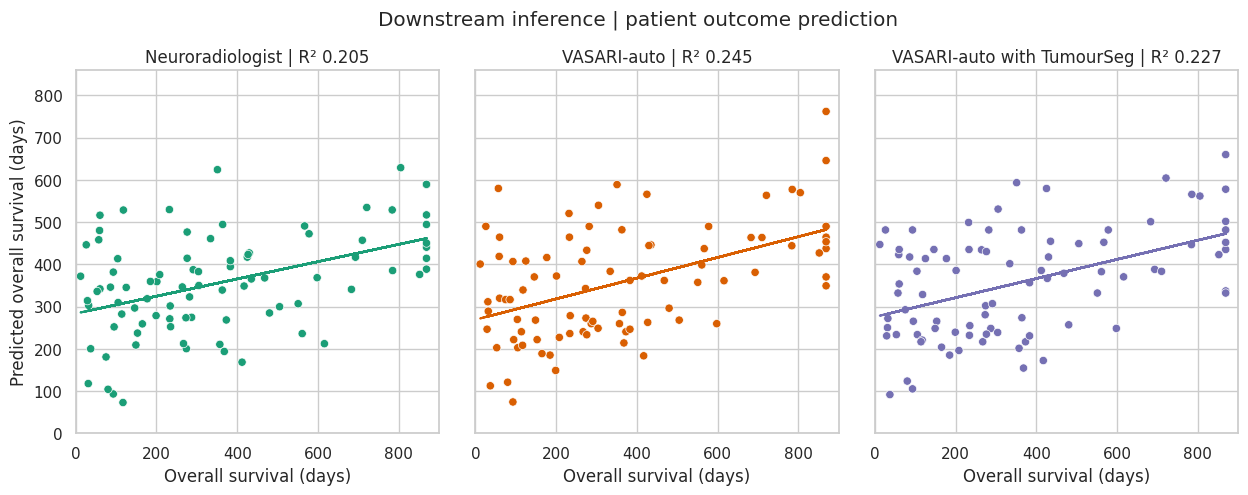

In [75]:
fig, ax = plt.subplots(1, 3,figsize=(15,5),sharey='row')
plot=0
sns.scatterplot(data=model_comparison_melt.loc[model_comparison_melt['Source of survival prediction']==plot_order[plot]],x=x,y=y,hue=h,ax=ax[plot],
               palette=sns.color_palette(as_cmap=True)[plot:],legend=False)
ax[plot].set(ylim=(0,860))
ax[plot].set(xlim=(0,900))
ax[plot].set_title(plot_order[plot])
# ax[plot].plot([0, 1], [0, 1], transform=ax[plot].transAxes,color=sns.color_palette(as_cmap=True)[plot])
# vlines = model_comparison_melt.loc[model_comparison_melt['Source of survival prediction']==plot_order[plot]].reset_index(drop=True)
# for v, row in vlines.iterrows():
#     if row['Overall survival (days)']>row['Predicted overall survival (days)']:
#         ymin = row['Predicted overall survival (days)']
#         ymax = row['Overall survival (days)']
#     else: 
#         ymax = row['Predicted overall survival (days)']
#         ymin = row['Overall survival (days)']
#     ax[plot].vlines(x=row['Overall survival (days)'],ymin=ymin,ymax=ymax,linestyles='--',alpha=0.5,color=sns.color_palette(as_cmap=True)[plot])
ax[plot].plot(model_comparison_melt.loc[model_comparison_melt['Source of survival prediction']==plot_order[plot],x].values.reshape(-1, 1), LinearRegression().fit(model_comparison_melt.loc[model_comparison_melt['Source of survival prediction']==plot_order[plot],x].values.reshape(-1, 1), model_comparison_melt.loc[model_comparison_melt['Source of survival prediction']==plot_order[plot],y].values.reshape(-1, 1)).predict(model_comparison_melt.loc[model_comparison_melt['Source of survival prediction']==plot_order[plot],x].values.reshape(-1, 1)),color=sns.color_palette(as_cmap=True)[plot] )

plot=1
sns.scatterplot(data=model_comparison_melt.loc[model_comparison_melt['Source of survival prediction']==plot_order[plot]],x=x,y=y,hue=h,ax=ax[plot],
               palette=sns.color_palette(as_cmap=True)[plot:],legend=False)
ax[plot].set(ylim=(0,860))
ax[plot].set(xlim=(0,900))
ax[plot].set_title(plot_order[plot])
ax[plot].plot(model_comparison_melt.loc[model_comparison_melt['Source of survival prediction']==plot_order[plot],x].values.reshape(-1, 1), LinearRegression().fit(model_comparison_melt.loc[model_comparison_melt['Source of survival prediction']==plot_order[plot],x].values.reshape(-1, 1), model_comparison_melt.loc[model_comparison_melt['Source of survival prediction']==plot_order[plot],y].values.reshape(-1, 1)).predict(model_comparison_melt.loc[model_comparison_melt['Source of survival prediction']==plot_order[plot],x].values.reshape(-1, 1)),color=sns.color_palette(as_cmap=True)[plot] )

# ax[plot].plot([0, 1], [0, 1], transform=ax[plot].transAxes,color=sns.color_palette(as_cmap=True)[plot])
# vlines = model_comparison_melt.loc[model_comparison_melt['Source of survival prediction']==plot_order[plot]].reset_index(drop=True)
# for v, row in vlines.iterrows():
#     if row['Overall survival (days)']>row['Predicted overall survival (days)']:
#         ymin = row['Predicted overall survival (days)']
#         ymax = row['Overall survival (days)']
#     else: 
#         ymax = row['Predicted overall survival (days)']
#         ymin = row['Overall survival (days)']
#     ax[plot].vlines(x=row['Overall survival (days)'],ymin=ymin,ymax=ymax,linestyles='--',alpha=0.5,color=sns.color_palette(as_cmap=True)[plot])


plot=2
sns.scatterplot(data=model_comparison_melt.loc[model_comparison_melt['Source of survival prediction']==plot_order[plot]],x=x,y=y,hue=h,ax=ax[plot],
               palette=sns.color_palette(as_cmap=True)[plot:],legend=False)
ax[plot].set(ylim=(0,860))
ax[plot].set(xlim=(0,900))
ax[plot].set_title(plot_order[plot])
ax[plot].plot(model_comparison_melt.loc[model_comparison_melt['Source of survival prediction']==plot_order[plot],x].values.reshape(-1, 1), LinearRegression().fit(model_comparison_melt.loc[model_comparison_melt['Source of survival prediction']==plot_order[plot],x].values.reshape(-1, 1), model_comparison_melt.loc[model_comparison_melt['Source of survival prediction']==plot_order[plot],y].values.reshape(-1, 1)).predict(model_comparison_melt.loc[model_comparison_melt['Source of survival prediction']==plot_order[plot],x].values.reshape(-1, 1)),color=sns.color_palette(as_cmap=True)[plot] )

# ax[plot].plot([0, 1], [0, 1], transform=ax[plot].transAxes,color=sns.color_palette(as_cmap=True)[plot])
# vlines = model_comparison_melt.loc[model_comparison_melt['Source of survival prediction']==plot_order[plot]].reset_index(drop=True)
# for v, row in vlines.iterrows():
#     if row['Overall survival (days)']>row['Predicted overall survival (days)']:
#         ymin = row['Predicted overall survival (days)']
#         ymax = row['Overall survival (days)']
#     else: 
#         ymax = row['Predicted overall survival (days)']
#         ymin = row['Overall survival (days)']
#     ax[plot].vlines(x=row['Overall survival (days)'],ymin=ymin,ymax=ymax,linestyles='--',alpha=0.5,color=sns.color_palette(as_cmap=True)[plot])

for row in ax:
    row.set_box_aspect(1)

# ax1.set_box_aspect(1)
# ax2.set_box_aspect(1)
# ax3.set_box_aspect(1)
# # ax4.set_box_aspect(1)

# # plt.tight_layout()

plt.subplots_adjust(wspace=0.1)
# plt.subplots_adjust(hspace=0.00)

fig.suptitle("Downstream inference | patient outcome prediction",y=.98)

plt.savefig(figures_out+"Figure6_v2.png",dpi=300,bbox_inches='tight')
plt.savefig(figures_out+"Figure6_v2.svg",dpi=300,bbox_inches='tight')

/tmp/ipykernel_3704756/1089398799.py:3: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.scatterplot(data=model_comparison_melt.loc[model_comparison_melt['Source of survival prediction']==plot_order[plot]],x=x,y=y,hue=h,ax=ax[plot],
/tmp/ipykernel_3704756/1089398799.py:21: UserWarning: The palette list has more values (7) than needed (1), which may not be intended.
  sns.scatterplot(data=model_comparison_melt.loc[model_comparison_melt['Source of survival prediction']==plot_order[plot]],x=x,y=y,hue=h,ax=ax[plot],
/tmp/ipykernel_3704756/1089398799.py:39: UserWarning: The palette list has more values (6) than needed (1), which may not be intended.
  sns.scatterplot(data=model_comparison_melt.loc[model_comparison_melt['Source of survival prediction']==plot_order[plot]],x=x,y=y,hue=h,ax=ax[plot],


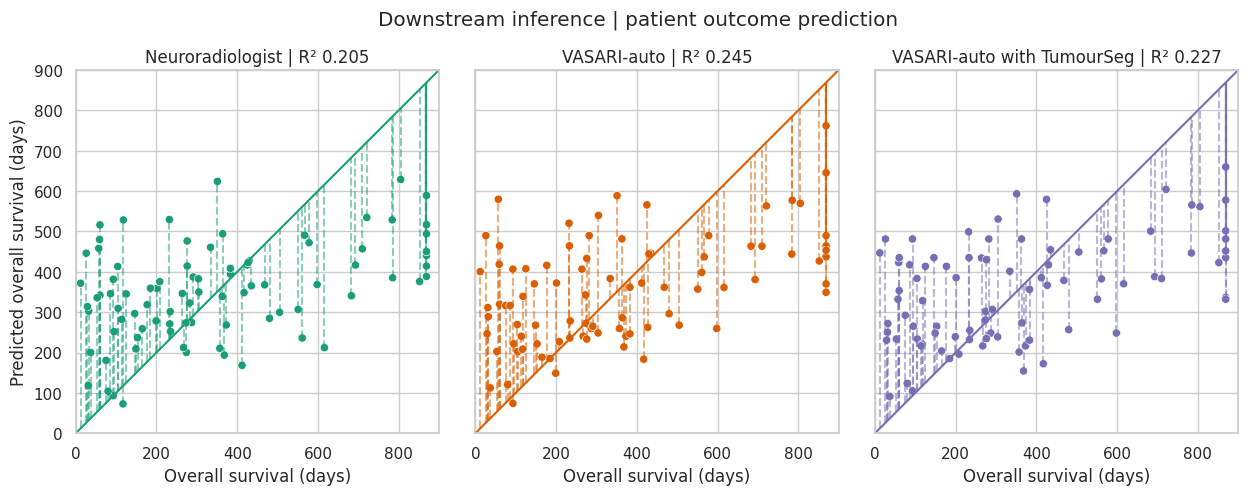

In [76]:
fig, ax = plt.subplots(1, 3,figsize=(15,5),sharey='row')
plot=0
sns.scatterplot(data=model_comparison_melt.loc[model_comparison_melt['Source of survival prediction']==plot_order[plot]],x=x,y=y,hue=h,ax=ax[plot],
               palette=sns.color_palette(as_cmap=True)[plot:],legend=False)
ax[plot].set(ylim=(0,900))
ax[plot].set(xlim=(0,900))
ax[plot].set_title(plot_order[plot])
ax[plot].plot([0, 1], [0, 1], transform=ax[plot].transAxes,color=sns.color_palette(as_cmap=True)[plot])
vlines = model_comparison_melt.loc[model_comparison_melt['Source of survival prediction']==plot_order[plot]].reset_index(drop=True)
for v, row in vlines.iterrows():
    if row['Overall survival (days)']>row['Predicted overall survival (days)']:
        ymin = row['Predicted overall survival (days)']
        ymax = row['Overall survival (days)']
    else: 
        ymax = row['Predicted overall survival (days)']
        ymin = row['Overall survival (days)']
    ax[plot].vlines(x=row['Overall survival (days)'],ymin=ymin,ymax=ymax,linestyles='--',alpha=0.5,color=sns.color_palette(as_cmap=True)[plot])
        

plot=1
sns.scatterplot(data=model_comparison_melt.loc[model_comparison_melt['Source of survival prediction']==plot_order[plot]],x=x,y=y,hue=h,ax=ax[plot],
               palette=sns.color_palette(as_cmap=True)[plot:],legend=False)
ax[plot].set(ylim=(0,900))
ax[plot].set(xlim=(0,900))
ax[plot].set_title(plot_order[plot])
ax[plot].plot([0, 1], [0, 1], transform=ax[plot].transAxes,color=sns.color_palette(as_cmap=True)[plot])
vlines = model_comparison_melt.loc[model_comparison_melt['Source of survival prediction']==plot_order[plot]].reset_index(drop=True)
for v, row in vlines.iterrows():
    if row['Overall survival (days)']>row['Predicted overall survival (days)']:
        ymin = row['Predicted overall survival (days)']
        ymax = row['Overall survival (days)']
    else: 
        ymax = row['Predicted overall survival (days)']
        ymin = row['Overall survival (days)']
    ax[plot].vlines(x=row['Overall survival (days)'],ymin=ymin,ymax=ymax,linestyles='--',alpha=0.5,color=sns.color_palette(as_cmap=True)[plot])


plot=2
sns.scatterplot(data=model_comparison_melt.loc[model_comparison_melt['Source of survival prediction']==plot_order[plot]],x=x,y=y,hue=h,ax=ax[plot],
               palette=sns.color_palette(as_cmap=True)[plot:],legend=False)
ax[plot].set(ylim=(0,900))
ax[plot].set(xlim=(0,900))
ax[plot].set_title(plot_order[plot])
ax[plot].plot([0, 1], [0, 1], transform=ax[plot].transAxes,color=sns.color_palette(as_cmap=True)[plot])
vlines = model_comparison_melt.loc[model_comparison_melt['Source of survival prediction']==plot_order[plot]].reset_index(drop=True)
for v, row in vlines.iterrows():
    if row['Overall survival (days)']>row['Predicted overall survival (days)']:
        ymin = row['Predicted overall survival (days)']
        ymax = row['Overall survival (days)']
    else: 
        ymax = row['Predicted overall survival (days)']
        ymin = row['Overall survival (days)']
    ax[plot].vlines(x=row['Overall survival (days)'],ymin=ymin,ymax=ymax,linestyles='--',alpha=0.5,color=sns.color_palette(as_cmap=True)[plot])

for row in ax:
    row.set_box_aspect(1)

# ax1.set_box_aspect(1)
# ax2.set_box_aspect(1)
# ax3.set_box_aspect(1)
# # ax4.set_box_aspect(1)

# # plt.tight_layout()

plt.subplots_adjust(wspace=0.1)
# plt.subplots_adjust(hspace=0.00)

fig.suptitle("Downstream inference | patient outcome prediction",y=.98)

plt.savefig(figures_out+"Figure6.png",dpi=300,bbox_inches='tight')
plt.savefig(figures_out+"Figure6.svg",dpi=300,bbox_inches='tight')

In [77]:
use_these = ['F1 Tumour Location','F2 Side of Tumour Epicenter','F4 Enhancement Quality','F5 Proportion Enhancing',
            'F6 Proportion nCET','F7 Proportion Necrosis','F9 Multifocal or Multicentric','F11 Thickness of enhancing margin',
            'F14 Proportion of Oedema','F19 Ependymal Invasion','F20 Cortical involvement','F21 Deep WM invasion','F24 satellites']

In [78]:
dice_df['Kappa']=0
dice_df['Accuracy']=0
dummies=False

for i, row in dice_df.iterrows():
    pt = row['filename']
    # print(i)

    neurorads = all_data.loc[(all_data['filename']==pt)&(all_data['mode']=='Consultant\nNeuroradiologist')].reset_index(drop=True).iloc[0,:]
    vasari_auto = all_data.loc[(all_data['filename']==pt)&(all_data['mode']!='Consultant\nNeuroradiologist')].reset_index(drop=True).iloc[0,:]

    if dummies:
        for f in use_these:
            one_hot = pd.get_dummies(neurorads[f],prefix=f)
            neurorads = neurorads.drop(f,axis = 1)
            neurorads = neurorads.join(one_hot)

            one_hot = pd.get_dummies(vasari_auto[f],prefix=f)
            vasari_auto = vasari_auto.drop(f,axis = 1)
            vasari_auto = vasari_auto.join(one_hot)
    
    cks = cohen_kappa_score(neurorads[use_these].values.astype(int), vasari_auto[use_these].values.astype(int),weights='linear')
    acc = accuracy_score(y_true=neurorads[use_these].values.astype(int),y_pred=vasari_auto[use_these].values.astype(int))
    dice_df.loc[i,'Kappa']=cks
    dice_df.loc[i,'Accuracy']=acc*100

/tmp/ipykernel_3704756/3248023717.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8015267175572519' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dice_df.loc[i,'Kappa']=cks
/tmp/ipykernel_3704756/3248023717.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '69.23076923076923' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dice_df.loc[i,'Accuracy']=acc*100


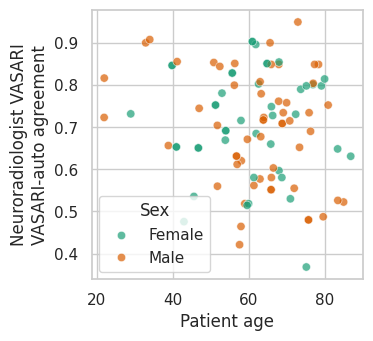

In [79]:
x='Age'
y='Kappa'
h='Sex'

plt.figure(figsize=(3.5,3.5))

# ax = sns.boxplot(data=dice_df_melt,x=x,y=y,hue=h,dodge=True,fill=True,fliersize=0,legend=None,linewidth=.5,width=.5,boxprops=dict(alpha=.3))
ax = sns.scatterplot(data=dice_df,x=x,y=y,hue=h,alpha=.7)

ax.set(xlabel='Patient age')
ax.set(ylabel='Neuroradiologist VASARI\nVASARI-auto agreement')
plt.savefig(figures_out+"kappa_equitable_age.png",dpi=150,bbox_inches='tight')
plt.savefig(figures_out+"kappa_equitable_age.svg",dpi=150,bbox_inches='tight')

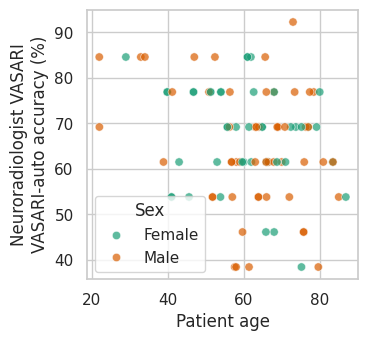

In [80]:
x='Age'
y='Accuracy'
h='Sex'

plt.figure(figsize=(3.5,3.5))

# ax = sns.boxplot(data=dice_df_melt,x=x,y=y,hue=h,dodge=True,fill=True,fliersize=0,legend=None,linewidth=.5,width=.5,boxprops=dict(alpha=.3))
ax = sns.scatterplot(data=dice_df,x=x,y=y,hue=h,alpha=.7)

ax.set(xlabel='Patient age')
ax.set(ylabel='Neuroradiologist VASARI\nVASARI-auto accuracy (%)')
plt.savefig(figures_out+"acc_equitable_age.png",dpi=150,bbox_inches='tight')
plt.savefig(figures_out+"acc_equitable_age.svg",dpi=150,bbox_inches='tight')

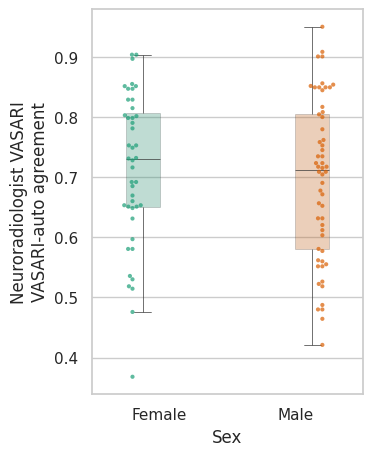

In [81]:
x='Sex'
y='Kappa'
h='Sex'

plt.figure(figsize=(3.5,5))

ax = sns.boxplot(data=dice_df,x=x,y=y,hue=h,dodge=True,fill=True,fliersize=0,legend=None,linewidth=.5,width=.5,boxprops=dict(alpha=.3))
ax = sns.swarmplot(data=dice_df,x=x,y=y,hue=h,dodge=True,size=3,alpha=.7)

ax.set(ylabel='Neuroradiologist VASARI\nVASARI-auto agreement')

# ax.set(xlabel='Compartment')
# ax.set(ylabel='Tumour segmentation Dice coefficient')
plt.savefig(figures_out+"kappa_equitable_sex.png",dpi=150,bbox_inches='tight')
plt.savefig(figures_out+"kappa_equitable_sex.svg",dpi=150,bbox_inches='tight')

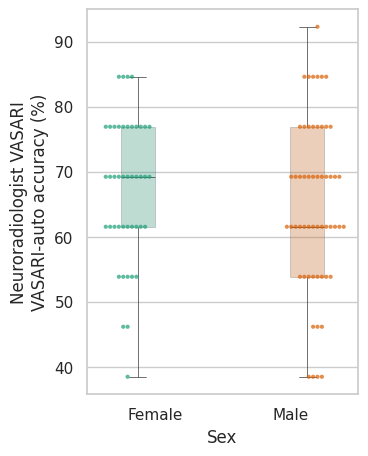

In [82]:
x='Sex'
y='Accuracy'
h='Sex'

plt.figure(figsize=(3.5,5))

ax = sns.boxplot(data=dice_df,x=x,y=y,hue=h,dodge=True,fill=True,fliersize=0,legend=None,linewidth=.5,width=.5,boxprops=dict(alpha=.3))
ax = sns.swarmplot(data=dice_df,x=x,y=y,hue=h,dodge=True,size=3,alpha=.7)

ax.set(ylabel='Neuroradiologist VASARI\nVASARI-auto accuracy (%)')

# ax.set(xlabel='Compartment')
# ax.set(ylabel='Tumour segmentation Dice coefficient')
plt.savefig(figures_out+"kappa_equitable_sex.png",dpi=150,bbox_inches='tight')
plt.savefig(figures_out+"kappa_equitable_sx.svg",dpi=150,bbox_inches='tight')

In [83]:
import random
def simulate_timecourse(epochs=52,lower_lim=30,upper_lim=75,tps_ll=1,tps_ul=5,pay_ll=1,pay_ul=5):
    epoch = []
    cost = []
    time = []
    load = []

    cumulative_cost = []
    cumulative_time = []
    cumulative_patient_load = []

    for e in range(epochs):
        epoch.append(e)

        #simulate an MDT load
        mdt_load = random.randint(lower_lim, upper_lim)
        load.append(mdt_load)

        #quantify_time_taken
        time_taken=0
        for p in range(mdt_load):
            time_taken += random.uniform(tps_ll, tps_ul)
        time.append(time_taken)

        #quantify cost
        rate = random.uniform(pay_ll, pay_ul)
        total_cost = rate * time_taken
        cost.append(total_cost)

        #on epoch end
        if e==0:
            c_cost = total_cost
            c_time = time_taken
            c_mdt_load = mdt_load

        if e>0:
            c_cost = total_cost+cumulative_cost[-1]
            c_time = time_taken+cumulative_time[-1]
            c_mdt_load = mdt_load+cumulative_patient_load[-1]
            
        cumulative_cost.append(c_cost)
        cumulative_time.append(c_time)
        cumulative_patient_load.append(c_mdt_load)

    df = pd.DataFrame(epoch,columns=['Epoch'])
    df['Cost (£)']=cost
    df['Time (s)']=time
    df['Patient load']=load
    df['Cumulative cost (£)']=cumulative_cost
    df['Cumulative time (s)']=cumulative_time
    df['Cumulative patient load']=cumulative_patient_load

    return df

In [84]:
#simulated economic_model 
# https://www.nhsemployers.org/system/files/2023-08/Pay%20and%20Conditions%20Circular%20%28MD%29%204-2023%20FINAL_0.pdf
#based on BMA pay circular
hourly_rate = 112356/(52*40) #in pounds
hourly_rate_ll = 93666/(52*40)
hourly_rate_ul = 126281/(52*40)
# second_rate = (hourly_rate/60)/60
second_rate_ll = (hourly_rate_ll/60)/60
second_rate_ul = (hourly_rate_ul/60)/60
time_per_scan_ll_val = df['time_taken_seconds'].astype(float).describe()['min']
time_per_scan_ul_val = df['time_taken_seconds'].astype(float).describe()['max']

radiologist_timecourse = simulate_timecourse(epochs=(52*3),tps_ll=time_per_scan_ll_val,tps_ul=time_per_scan_ul_val,pay_ll=second_rate_ll,pay_ul=second_rate_ul)
radiologist_timecourse['Cumulative time (hrs)']=radiologist_timecourse['Cumulative time (s)']/60/60
radiologist_timecourse['Labeller']='Neuroradiologist'
radiologist_timecourse.head()

Epoch    Cost (£)      Time (s)  Patient load  Cumulative cost (£)  \
0      0  209.957533  13449.962379            43           209.957533   
1      1  270.247534  16605.923420            52           480.205066   
2      2  233.817807  13972.686384            40           714.022874   
3      3  222.152898  16358.261508            53           936.175772   
4      4  208.490404  15870.690964            49          1144.666175   

   Cumulative time (s)  Cumulative patient load  Cumulative time (hrs)  \
0         13449.962379                       43               3.736101   
1         30055.885799                       95               8.348857   
2         44028.572183                      135              12.230159   
3         60386.833691                      188              16.774120   
4         76257.524655                      237              21.182646   

           Labeller  
0  Neuroradiologist  
1  Neuroradiologist  
2  Neuroradiologist  
3  Neuroradiologist  
4  Neuroradiologist

In [85]:
#simulated energy use model
# https://www.sust-it.net/energy-calculator.php
hourly_rate = 0.35 #in pounds
hourly_rate_ll = hourly_rate/2
hourly_rate_ul = hourly_rate*2
# second_rate = (hourly_rate/60)/60
second_rate_ll = (hourly_rate_ll/60)/60
second_rate_ul = (hourly_rate_ul/60)/60
time_per_scan_ll_val = all_data_with_seg.loc[all_data_with_seg['mode']=='VASARI-auto\n with TumourSeg','time_taken_seconds'].astype(float).describe()['min']
time_per_scan_ul_val = all_data_with_seg.loc[all_data_with_seg['mode']=='VASARI-auto\n with TumourSeg','time_taken_seconds'].astype(float).describe()['max']

print(second_rate_ll)
vasari_auto_tumour_seg_timecourse = simulate_timecourse(epochs=(52*3),tps_ll=time_per_scan_ll_val,tps_ul=time_per_scan_ul_val,pay_ll=second_rate_ll,pay_ul=second_rate_ul)
vasari_auto_tumour_seg_timecourse['Cumulative time (hrs)']=vasari_auto_tumour_seg_timecourse['Cumulative time (s)']/60/60
vasari_auto_tumour_seg_timecourse['Labeller']='VASARI-auto with TumourSeg'
vasari_auto_tumour_seg_timecourse.head()

4.861111111111111e-05


Epoch  Cost (£)     Time (s)  Patient load  Cumulative cost (£)  \
0      0  0.052965   492.014532            33             0.052965   
1      1  0.107772   969.895619            65             0.160737   
2      2  0.091585  1076.682850            72             0.252322   
3      3  0.057614   980.864723            65             0.309936   
4      4  0.138727   830.541933            56             0.448664   

   Cumulative time (s)  Cumulative patient load  Cumulative time (hrs)  \
0           492.014532                       33               0.136671   
1          1461.910151                       98               0.406086   
2          2538.593001                      170               0.705165   
3          3519.457724                      235               0.977627   
4          4349.999658                      291               1.208333   

                     Labeller  
0  VASARI-auto with TumourSeg  
1  VASARI-auto with TumourSeg  
2  VASARI-auto with TumourSeg  
3  VASARI-auto with TumourSeg  
4  VASARI-auto with TumourSeg

In [86]:

#simulated energy use model
# https://www.sust-it.net/energy-calculator.php
hourly_rate = 0.35 #in pounds
hourly_rate_ll = hourly_rate/2
hourly_rate_ul = hourly_rate*2
# second_rate = (hourly_rate/60)/60
second_rate_ll = (hourly_rate_ll/60)/60
second_rate_ul = (hourly_rate_ul/60)/60
time_per_scan_ll_val = all_data_with_seg.loc[all_data_with_seg['mode']=='VASARI-auto','time_taken_seconds'].astype(float).describe()['min']
time_per_scan_ul_val = all_data_with_seg.loc[all_data_with_seg['mode']=='VASARI-auto','time_taken_seconds'].astype(float).describe()['max']

vasari_auto_timecourse = simulate_timecourse(epochs=(52*3),tps_ll=time_per_scan_ll_val,tps_ul=time_per_scan_ul_val,pay_ll=second_rate_ll,pay_ul=second_rate_ul)
vasari_auto_timecourse['Cumulative time (hrs)']=vasari_auto_timecourse['Cumulative time (s)']/60/60
vasari_auto_timecourse['Labeller']='VASARI-auto'
vasari_auto_timecourse.head()

Epoch  Cost (£)    Time (s)  Patient load  Cumulative cost (£)  \
0      0  0.018077  117.328714            43             0.018077   
1      1  0.010779  153.142491            57             0.028856   
2      2  0.014439  102.971936            37             0.043296   
3      3  0.007718  102.957620            37             0.051013   
4      4  0.010442  104.986421            38             0.061455   

   Cumulative time (s)  Cumulative patient load  Cumulative time (hrs)  \
0           117.328714                       43               0.032591   
1           270.471205                      100               0.075131   
2           373.443141                      137               0.103734   
3           476.400761                      174               0.132334   
4           581.387182                      212               0.161496   

      Labeller  
0  VASARI-auto  
1  VASARI-auto  
2  VASARI-auto  
3  VASARI-auto  
4  VASARI-auto

In [87]:
timecourse = pd.concat([radiologist_timecourse,vasari_auto_tumour_seg_timecourse,vasari_auto_timecourse])
# timecourse['Cumulative time (hrs)']=np.log(timecourse['Cumulative time (hrs)'])

In [88]:
timecourse.sort_values(by='Epoch',ascending=False)

Epoch    Cost (£)      Time (s)  Patient load  Cumulative cost (£)  \
155    155    0.018107    135.149432            49             2.683702   
155    155    0.139046    878.386988            58            15.419374   
155    155  313.394093  22316.352164            67         38108.289943   
154    154  300.018442  22382.859880            69         37794.895850   
154    154    0.020351    130.644558            47             2.665594   
154    154    0.076160    739.999380            49            15.280328   
153    153    0.012810    157.488817            57             2.645243   
153    153    0.208184   1158.463637            75            15.204168   
153    153  257.814800  17509.679183            53         37494.877408   
152    152    0.026695    181.266897            65             2.632433   
152    152    0.034618    488.944174            33            14.995984   
152    152  171.818099  10728.255773            33         37237.062608   
151    151  213.412234  15846.442658            47         37065.244509   
151    151    0.182962   1068.219195            72            14.961366   
151    151    0.015581    151.521344            56             2.605738   
150    150  373.495388  22748.901036            73         36851.832274   
150    150    0.020208    160.123338            57             2.590157   
150    150    0.089901    470.657851            31            14.778404   
149    149  322.007055  23380.431002            73         36478.336886   
149    149    0.113142    956.105452            62            14.688503   
149    149    0.015682    202.727563            74             2.569949   
148    148  163.027492  11372.315951            33         36156.329831   
148    148    0.054464    578.916746            38            14.575360   
148    148    0.012191    112.716135            41             2.554267   
147    147    0.112304    714.795279            48            14.520896   
147    147    0.037481    193.862615            71             2.542077   
147    147  210.986319  15435.715601            44         35993.302339   
146    146    0.043822    596.610069            39            14.408592   
146    146    0.017907    143.157061            51             2.504595   
146    146  153.687109  10366.379347            34         35782.316020   
145    145    0.097615    868.148653            58            14.364770   
145    145    0.015328    176.726572            62             2.486688   
145    145  206.367909  13603.982558            42         35628.628911   
144    144    0.195866   1052.049268            71            14.267154   
144    144  198.048094  14654.982905            44         35422.261002   
144    144    0.009752    101.876250            37             2.471360   
143    143    0.019205    104.135846            37             2.461608   
143    143  206.902332  13787.389832            39         35224.212908   
143    143    0.081425   1149.893555            75            14.071289   
142    142    0.078302    921.517531            61            13.989864   
142    142  360.714971  21588.765818            71         35017.310576   
142    142    0.021299    134.908450            50             2.442403   
141    141  202.567777  12752.171482            42         34656.595606   
141    141    0.009435    108.636246            38             2.421104   
141    141    0.079803    451.984990            30            13.911562   
140    140    0.017189    114.354475            41             2.411668   
140    140    0.104326    645.969377            42            13.831759   
140    140  238.268113  18917.215619            57         34454.027828   
139    139    0.148561    816.622102            54            13.727433   
139    139  176.500246  10467.196970            34         34215.759716   
139    139    0.023482    183.873408            67             2.394479   
138    138    0.022303    194.182489            71             2.370997   
138    138    0.117645    983.

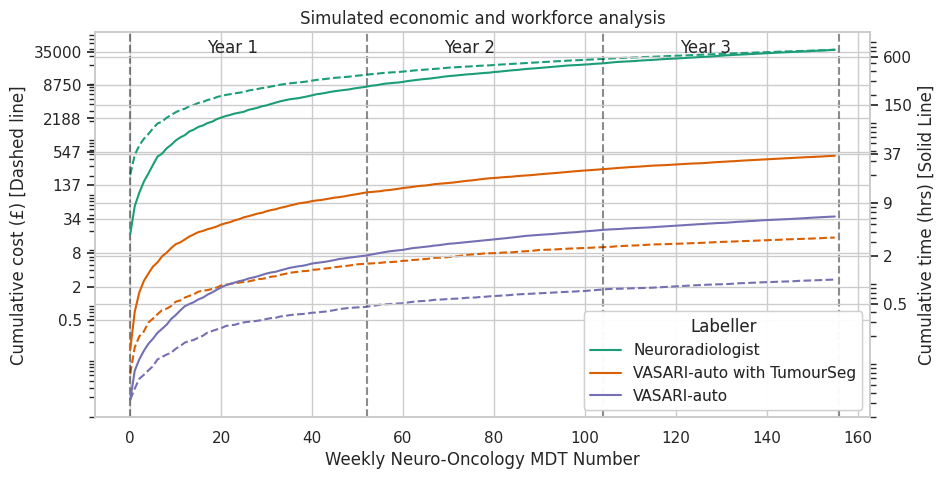

In [89]:
plt.figure(figsize=(10,5))

g = sns.lineplot(data=timecourse, color="g",x='Epoch',y='Cumulative cost (£)',hue='Labeller',linestyle='--')
g2 = sns.lineplot(data=timecourse, color="b",x='Epoch',y='Cumulative time (hrs)',ax=g.axes.twinx(),hue='Labeller')
g.set(xlabel='Neuro-oncology MDT number')
g.axvline(x = 0, color = 'k', label = 'axvline - full height',ls='--',alpha=0.5)
g.axvline(x = 52, color = 'k', label = 'axvline - full height',ls='--',alpha=0.5)
g.axvline(x = 52*2, color = 'k', label = 'axvline - full height',ls='--',alpha=0.5)
g.axvline(x = 52*3, color = 'k', label = 'axvline - full height',ls='--',alpha=0.5)
g.set_yscale('log')
ticks = [.5,2,8,34,137,547,2188,8750,35000]
g.set_yticks(ticks)
g.set_yticklabels(ticks)

g2.set_yscale('log')
ticks = [.5,2,9,37,150,600]
g2.set_yticks(ticks)
g2.set_yticklabels(ticks)

g.set(xlabel='Weekly Neuro-Oncology MDT Number')
g.set(title='Simulated economic and workforce analysis')
g.set(ylabel='Cumulative cost (£) [Dashed line]')
g2.set(ylabel='Cumulative time (hrs) [Solid Line]')

g.annotate('Year 1',xy=(17,34000))
g.annotate('Year 2',xy=((52+17),34000))
g.annotate('Year 3',xy=((52+52+17),34000))

# plt.title('Efficiency')

plt.savefig(figures_out+"simulated_timecourse.png",dpi=150,bbox_inches='tight')
plt.savefig(figures_out+"simulated_timecourse.svg",dpi=150,bbox_inches='tight')

In [90]:
radiologist_timecourse

Epoch    Cost (£)      Time (s)  Patient load  Cumulative cost (£)  \
0        0  209.957533  13449.962379            43           209.957533   
1        1  270.247534  16605.923420            52           480.205066   
2        2  233.817807  13972.686384            40           714.022874   
3        3  222.152898  16358.261508            53           936.175772   
4        4  208.490404  15870.690964            49          1144.666175   
5        5  296.358785  21245.102343            64          1441.024960   
6        6  331.171963  26121.155239            75          1772.196922   
7        7  141.287030  10700.018660            33          1913.483952   
8        8  335.795761  22162.054231            66          2249.279713   
9        9  273.037867  16312.154912            45          2522.317580   
10      10  307.245760  22930.811272            71          2829.563340   
11      11  263.528009  18160.102824            55          3093.091349   
12      12  180.053987  14242.720433            45          3273.145336   
13      13  360.573497  25542.338879            74          3633.718833   
14      14  204.775549  14083.425097            43          3838.494382   
15      15  338.193278  21803.059617            65          4176.687660   
16      16  167.597025  11609.624282            33          4344.284685   
17      17  364.959115  21670.338183            63          4709.243800   
18      18  206.296464  12390.819653            39          4915.540264   
19      19  380.407750  24940.850180            71          5295.948014   
20      20  295.174760  17687.387424            51          5591.122774   
21      21  227.613453  16680.237539            54          5818.736227   
22      22  169.683195  13171.894451            40          5988.419422   
23      23  217.767001  16164.804001            56          6206.186423   
24      24  169.137457  10761.830965            33          6375.323880   
25      25  194.517222  11660.793700            30          6569.841102   
26      26  406.393092  24602.166509            70          6976.234194   
27      27  215.106068  13458.263774            42          7191.340262   
28      28  251.659757  16521.016380            49          7443.000019   
29      29  293.643782  21233.047113            64          7736.643801   
30      30  186.989978  13380.329918            42          7923.633779   
31      31  348.370163  22525.149174            72          8272.003942   
32      32  279.628201  20423.999056            62          8551.632143   
33      33  342.476751  23062.715211            69          8894.108894   
34      34  270.436831  16357.987790            52          9164.545725   
35      35  241.225842  18860.134138            59          9405.771567   
36      36  180.542854  11729.995191            36          9586.314420   
37      37  154.734123   9995.660784            31          9741.048543   
38      38  216.093293  16345.699214            46          9957.141836   
39      39  253.113506  18302.225031            56         10210.255342   
40      40  318.748164  20354.443886            63         10529.003506   
41      41  354.267154  23205.801343            71         10883.270661   
42      42  174.991496  12720.080539            40         11058.262156   
43      43  254.171516  17035.999650            50         11312.433672   
44      44  266.371905  20798.309153            60         11578.805578   
45      45  273.108079  16566.885446            51         11851.913657   
46      46  193.364401  14104.744333            46         12045.278058   
47      47  199.782872  13363.109918            38         12245.060930   
48      48  152.078844  12012.134966            38         12397.139774   
49      49  316.267131  20674.598735            63         12713.406906   
50      50  267.139541  18031.951788            51         12980.546447   
51      51  206.427756  14356.733266            46         13186.974202   
52      52  244.689271  18089.

In [91]:
centre = [
    "Addenbrooke’s Hospital",
    "The Walton Centre NHS Foundation Trust",
    "Alder Hey Children's NHS Foundation Trust",
    "The Newcastle Upon Tyne Hospitals NHS Foundation Trust",
    "James Cook Hospital / South Tees Hospitals NHS Foundation Trust (Middlesbrough)",
    "Lancashire Teaching Hospitals NHS Foundation Trust (Preston)",
    "Royal Manchester Children’s Hospital The University of Manchester",
    "Manchester Centre for Clinical Neurosciences",
    "John Radcliffe Hospital/Oxford University Hospitals NHS Trust",
    "North Bristol NHS Trust",
    "Bristol's Children's hospital",
    "University Hospitals Plymouth NHS Trust",
    "Sheffield Teaching Hospitals NHS Foundation Trust",
    "Sheffield Children’s NHS Trust",
    "Nottingham University Hospitals NHS Trust",
    "University Hospitals Birmingham NHS Foundation Trust",
    "Birmingham Children's Hospital NHS Foundation Trust",
    "University Hospital of North Midlands NHS Trust",
    "University Hospitals Coventry and Warwickshire NHS Trust",
    "University Hospital Southampton NHS Foundation Trust",
    "Hull And East Yorkshire Hospitals NHS Trust",
    "Leeds Teaching Hospitals NHS Trust",
    "Belfast Health & Social Care Trust",
    "Beaumont Hospital, Dublin",
    "The Children's Hospital, Dublin",
    "University Hospital, Wilton, Cork, Ireland",
    "Cardiff and Vale UHB",
    "Institute Of Neurological  Sciences, Glasgow",
    "Western General Hospital, Edinburgh",
    "Royal Hospital for Sick Children, Edinburgh",
    "Aberdeen Royal Infirmary",
    "Ninewells Hospital, Dundee",
    "Imperial College Healthcare NHS Trust (Charing Cross)",
    "Barts Health NHS Trust (Royal London)",
    "Barking, Havering And Redbridge University Hospitals NHS Trust",
    "King's College Hospital NHS Foundation Trust",
    "Brighton and Sussex University Hospitals NHS Trust",
    "St George's Healthcare NHS Trust",
    "University College London Hospitals NHS Foundation Trust (National)",
    "Great Ormond Street Hospital For Children NHS Foundation Trust"
]

number_of_ns_centres = len(centre)

for i in range(number_of_ns_centres):
    #simulated economic_model 
    # https://www.nhsemployers.org/system/files/2023-08/Pay%20and%20Conditions%20Circular%20%28MD%29%204-2023%20FINAL_0.pdf
    #based on BMA pay circular
    hourly_rate = 112356/(52*40) #in pounds
    hourly_rate_ll = 93666/(52*40)
    hourly_rate_ul = 126281/(52*40)
    # second_rate = (hourly_rate/60)/60
    second_rate_ll = (hourly_rate_ll/60)/60
    second_rate_ul = (hourly_rate_ul/60)/60
    time_per_scan_ll_val = df['time_taken_seconds'].astype(float).describe()['min']
    time_per_scan_ul_val = df['time_taken_seconds'].astype(float).describe()['max']
    
    radiologist_timecourse_multi_centre_single = simulate_timecourse(epochs=(52*3),tps_ll=time_per_scan_ll_val,tps_ul=time_per_scan_ul_val,pay_ll=second_rate_ll,pay_ul=second_rate_ul)
    radiologist_timecourse_multi_centre_single['Cumulative time (hrs)']=radiologist_timecourse_multi_centre_single['Cumulative time (s)']/60/60
    radiologist_timecourse_multi_centre_single['Labeller']='Neuroradiologist'

    #simulated energy use model
    # https://www.sust-it.net/energy-calculator.php
    hourly_rate = 0.35 #in pounds
    hourly_rate_ll = hourly_rate/2
    hourly_rate_ul = hourly_rate*2
    # second_rate = (hourly_rate/60)/60
    second_rate_ll = (hourly_rate_ll/60)/60
    second_rate_ul = (hourly_rate_ul/60)/60
    time_per_scan_ll_val = all_data_with_seg.loc[all_data_with_seg['mode']=='VASARI-auto\n with TumourSeg','time_taken_seconds'].astype(float).describe()['min']
    time_per_scan_ul_val = all_data_with_seg.loc[all_data_with_seg['mode']=='VASARI-auto\n with TumourSeg','time_taken_seconds'].astype(float).describe()['max']

    vasari_auto_tumour_seg_timecourse_multi_centre_single = simulate_timecourse(epochs=(52*3),tps_ll=time_per_scan_ll_val,tps_ul=time_per_scan_ul_val,pay_ll=second_rate_ll,pay_ul=second_rate_ul)
    vasari_auto_tumour_seg_timecourse_multi_centre_single['Cumulative time (hrs)']=vasari_auto_tumour_seg_timecourse_multi_centre_single['Cumulative time (s)']/60/60
    vasari_auto_tumour_seg_timecourse_multi_centre_single['Labeller']='VASARI-auto with TumourSeg'

    #simulated energy use model
    # https://www.sust-it.net/energy-calculator.php
    hourly_rate = 0.35 #in pounds
    hourly_rate_ll = hourly_rate/2
    hourly_rate_ul = hourly_rate*2
    # second_rate = (hourly_rate/60)/60
    second_rate_ll = (hourly_rate_ll/60)/60
    second_rate_ul = (hourly_rate_ul/60)/60
    time_per_scan_ll_val = all_data_with_seg.loc[all_data_with_seg['mode']=='VASARI-auto','time_taken_seconds'].astype(float).describe()['min']
    time_per_scan_ul_val = all_data_with_seg.loc[all_data_with_seg['mode']=='VASARI-auto','time_taken_seconds'].astype(float).describe()['max']

    vasari_auto_timecourse_multi_centre_single = simulate_timecourse(epochs=(52*3),tps_ll=time_per_scan_ll_val,tps_ul=time_per_scan_ul_val,pay_ll=second_rate_ll,pay_ul=second_rate_ul)
    vasari_auto_timecourse_multi_centre_single['Cumulative time (hrs)']=vasari_auto_timecourse_multi_centre_single['Cumulative time (s)']/60/60
    vasari_auto_timecourse_multi_centre_single['Labeller']='VASARI-auto'

    radiologist_timecourse_multi_centre_single['Centre']=centre[i]
    vasari_auto_tumour_seg_timecourse_multi_centre_single['Centre']=centre[i]
    vasari_auto_timecourse_multi_centre_single['Centre']=centre[i]

    if i==0:
        radiologist_timecourse_multi_centre = radiologist_timecourse_multi_centre_single.copy()
        vasari_auto_tumour_seg_timecourse_multi_centre = vasari_auto_tumour_seg_timecourse_multi_centre_single.copy()
        vasari_auto_timecourse_multi_centre = vasari_auto_timecourse_multi_centre_single.copy()
        
    else:
        radiologist_timecourse_multi_centre = pd.concat([radiologist_timecourse_multi_centre,radiologist_timecourse_multi_centre_single])
        vasari_auto_tumour_seg_timecourse_multi_centre = pd.concat([vasari_auto_tumour_seg_timecourse_multi_centre,vasari_auto_tumour_seg_timecourse_multi_centre_single])
        vasari_auto_timecourse_multi_centre = pd.concat([vasari_auto_timecourse_multi_centre,vasari_auto_timecourse_multi_centre_single])

radiologist_timecourse_multi_centre.reset_index(drop=True,inplace=True)
vasari_auto_timecourse_multi_centre.reset_index(drop=True,inplace=True)
vasari_auto_tumour_seg_timecourse_multi_centre.reset_index(drop=True,inplace=True)

timecourse_multi_centre = pd.concat([radiologist_timecourse_multi_centre,vasari_auto_timecourse_multi_centre,vasari_auto_tumour_seg_timecourse_multi_centre])

In [92]:
number_of_ns_centres

40

In [93]:
timecourse_multi_centre.loc[timecourse_multi_centre['Epoch']==155]

Epoch    Cost (£)      Time (s)  Patient load  Cumulative cost (£)  \
155     155  324.211101  19555.528899            58         39156.360362   
311     155  297.654565  21274.866954            64         39423.858454   
467     155  225.241675  14345.715679            47         39926.553481   
623     155  185.182098  12088.319511            41         39699.653499   
779     155  204.125959  15035.224213            44         40862.862249   
935     155  319.331581  22523.304656            63         40042.774470   
1091    155  277.028052  19632.041220            59         39029.539440   
1247    155  359.670420  21574.666965            68         40166.703731   
1403    155  179.965338  12600.951322            40         41314.875064   
1559    155  227.224495  14568.193010            44         39889.009673   
1715    155  172.789118  10742.727156            34         41459.784616   
1871    155  388.234747  23488.375591            71         41094.481733   
2027    155  338.985999  23696.012897            75         39658.942347   
2183    155  265.828257  17426.875989            48         39999.717216   
2339    155  203.063096  12175.078897            37         39867.549534   
2495    155  263.533855  17233.120619            53         39164.936720   
2651    155  172.812291  10825.990860            33         37947.369012   
2807    155  236.789750  15081.628970            44         38995.230090   
2963    155  224.025280  16093.769651            48         40212.228564   
3119    155  272.269593  20404.497371            63         38806.567333   
3275    155  299.476010  23093.048245            70         39309.437822   
3431    155  223.103340  14103.080172            44         39254.314813   
3587    155  350.767721  21889.619828            67         38672.990605   
3743    155  370.894403  24055.151983            73         40543.690333   
3899    155  214.657072  13560.475387            41         40776.336660   
4055    155  277.183963  17991.525408            54         39882.109705   
4211    155  199.741640  14857.527835            45         39633.644513   
4367    155  304.455320  21780.687918            65         39386.525587   
4523    155  254.759179  17296.770338            59         39530.696702   
4679    155  219.140627  16137.774596            45         39247.509116   
4835    155  269.165241  20779.628710            66         40035.046590   
4991    155  310.905029  19705.593741            61         39430.744987   
5147    155  154.606298  10363.998224            37         39149.525737   
5303    155  166.429572  10285.018410            30         37757.159776   
5459    155  165.902466  12222.477086            39         39427.479316   
5615    155  188.896672  12343.159831            39         38724.623156   
5771    155  267.918910  16489.571440            52         39114.246800   
5927    155  292.470211  17595.746000            54         39898.136179   
6083    155  200.906464  13460.108871            39         37904.613341   
6239    155  289.803534  18506.824873            56         39046.606973   
155     155    0.010898    179.675688            65             2.879798   
311     155    0.011457     91.737860            33             2.940610   
467     155    0.018787    110.361139            40             2.949254   
623     155    0.010941     90.573231            32             2.886756   
779     155    0.019032    151.792850            54             2.868121   
935     155    0.018463    174.157125            63             2.606368   
1091    155    0.018846    137.793559            49             2.926016   
1247    155    0.012539    127.297469            45             2.808230   
1403    155    0.017586     93.972788            34             2.834432   
1559    155    0.011177    110.781086            42             2.725833   
1715    155    0.005566     99.366914            35             2.720628   
1871    155    0.011444     79.788030            30   

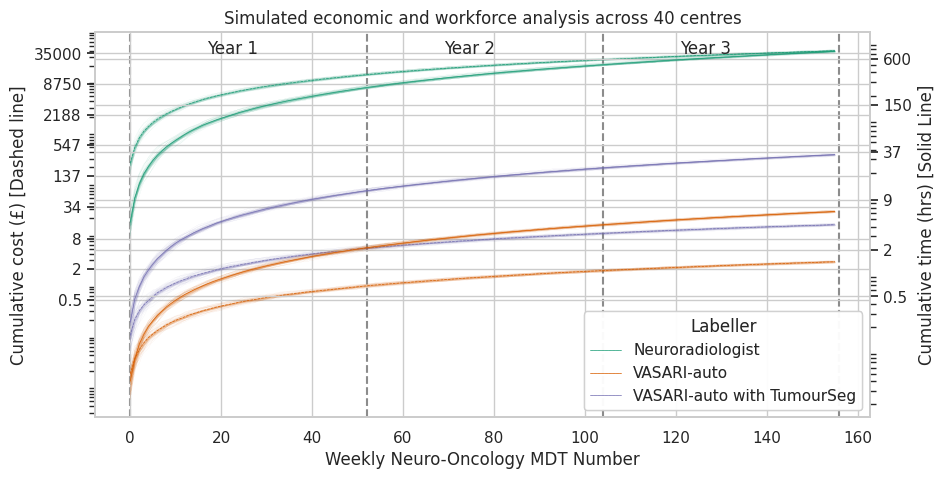

In [94]:
plt.figure(figsize=(10,5))

g = sns.lineplot(data=timecourse_multi_centre, color="g",x='Epoch',y='Cumulative cost (£)',hue='Labeller',linestyle='--',units='Centre',estimator=None,lw=.05,alpha=.5,legend=False)
g3 = sns.lineplot(data=timecourse_multi_centre, color="g",x='Epoch',y='Cumulative cost (£)',hue='Labeller',linestyle='--',lw=.5)

g2 = sns.lineplot(data=timecourse_multi_centre, color="b",x='Epoch',y='Cumulative time (hrs)',ax=g.axes.twinx(),hue='Labeller',units='Centre',estimator=None,lw=.05,alpha=.5,legend=False)
g4 = sns.lineplot(data=timecourse_multi_centre, color="b",x='Epoch',y='Cumulative time (hrs)',hue='Labeller',lw=.5)

g.set(xlabel='Neuro-oncology MDT number')
g.axvline(x = 0, color = 'k', label = 'axvline - full height',ls='--',alpha=0.5,zorder=-1)
g.axvline(x = 52, color = 'k', label = 'axvline - full height',ls='--',alpha=0.5,zorder=-1)
g.axvline(x = 52*2, color = 'k', label = 'axvline - full height',ls='--',alpha=0.5,zorder=-1)
g.axvline(x = 52*3, color = 'k', label = 'axvline - full height',ls='--',alpha=0.5,zorder=-1)

ticks = [.5,2,8,34,137,547,2188,8750,35000]
g.set_yscale('log')
g.set_yticks(ticks)
g.set_yticklabels(ticks)
g3.set_yscale('log')
g3.set_yticks(ticks)
g3.set_yticklabels(ticks)

ticks = [.5,2,9,37,150,600]
g2.set_yscale('log')
g2.set_yticks(ticks)
g2.set_yticklabels(ticks)
g4.set_yscale('log')
g4.set_yticks(ticks)
g4.set_yticklabels(ticks)

g.set(xlabel='Weekly Neuro-Oncology MDT Number')
g.set(title='Simulated economic and workforce analysis across '+str(number_of_ns_centres)+' centres')
g.set(ylabel='Cumulative cost (£) [Dashed line]')
g2.set(ylabel='Cumulative time (hrs) [Solid Line]')

g.annotate('Year 1',xy=(17,34000))
g.annotate('Year 2',xy=((52+17),34000))
g.annotate('Year 3',xy=((52+52+17),34000))

# plt.title('Efficiency')

plt.savefig(figures_out+"simulated_timecourse_multicentre.png",dpi=600,bbox_inches='tight')
plt.savefig(figures_out+"simulated_timecourse_multicentre.svg",dpi=150,bbox_inches='tight')

In [95]:
# fig, ax = plt.subplots(1,1)
# # dummy plots, just to get the Path objects
# a = ax.scatter([1,2],[3,4], marker='s')
# b = ax.scatter([1,2],[3,4], marker='^')
# square_mk, = a.get_paths()
# triangle_up_mk, = b.get_paths()
# a.remove()
# b.remove()


# y='mode'
# x='time_taken_seconds'
# order = ['Consultant\nNeuroradiologist','VASARI-auto','VASARI-auto\n with TumourSeg']
# ax = sns.swarmplot(data=all_data_with_seg,x=x,y=y,order=order,hue=y,dodge=False,size=3,alpha=.7)
# collections = ax.collections
# unique_colors = np.unique(collections[0].get_facecolors(), axis=0)
# markers = [triangle_up_mk, square_mk]  # this array must be at least as large as the number of unique colors
# for collection in collections:
#     paths = []
#     for current_color in collection.get_facecolors():
#         for possible_marker,possible_color in zip(markers, unique_colors):
#             if np.array_equal(current_color,possible_color):
#                 paths.append(possible_marker)
#                 break
#     collection.set_paths(paths)
# #update legend
# # ax.legend(collections[-2:],pd.unique(tips.sex))  


In [96]:
# fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 5]},figsize=(10,7.5))

# x='mode'
# y='time_taken_seconds'
# order = ['Consultant\nNeuroradiologist','VASARI-auto','VASARI-auto\n with TumourSeg']
# # tt = stats.ttest_ind(all_data.loc[all_data[x]=='Consultant\nNeuroradiologist',y].values,all_data.loc[all_data[x]=='VASARI-auto',y].values)
# # print(tt.pvalue)

# sns.boxplot(data=all_data_with_seg,x=x,y=y,order=order,dodge=True,saturation=0.1,fill=False,color='k',fliersize=0,legend=None,linewidth=.5,width=.5,ax=ax[0])
# sns.swarmplot(data=all_data_with_seg,x=x,y=y,order=order,hue=y,dodge=False,size=3,alpha=.7,ax=ax[0])

# # annot = Annotator(ax,[('Consultant\nNeuroradiologist','VASARI-auto')],data=all_data,x=x,y=y)
# # annot.configure(text_format='star',log='outside',verbose=2)
# # annot.apply_test()

# #asplit=True,gap=.1,inner='quart',dodge=True
# # ax[0].set(ylabel='')
# # ax[0].set(xlabel='Time taken (s) (Log-Axis)')
# ax[0].set_yscale('log')
# ticks = [2,4,8,16,32,64,128,256,512,1024]
# ax[0].set_yticks(ticks)
# ax[0].set_yticklabels(ticks)
# # ax,test_results = annot.annotate()
# # ax.legend(bbox_to_anchor=(1,1))
# ax[0].set_title('Labelling speed')
# # plt.savefig(figures_out+"efficiency_2.png",dpi=150,bbox_inches='tight')
# # plt.savefig(figures_out+"efficiency_2.svg",dpi=150,bbox_inches='tight')

In [97]:
all_data_with_seg.loc[all_data_with_seg['mode']=='Consultant\nNeuroradiologist','mode']='Neuroradiologist'

/home/jruffle/.local/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 91.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jruffle/.local/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 81.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jruffle/.local/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 91.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jruffle/.local/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 83.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


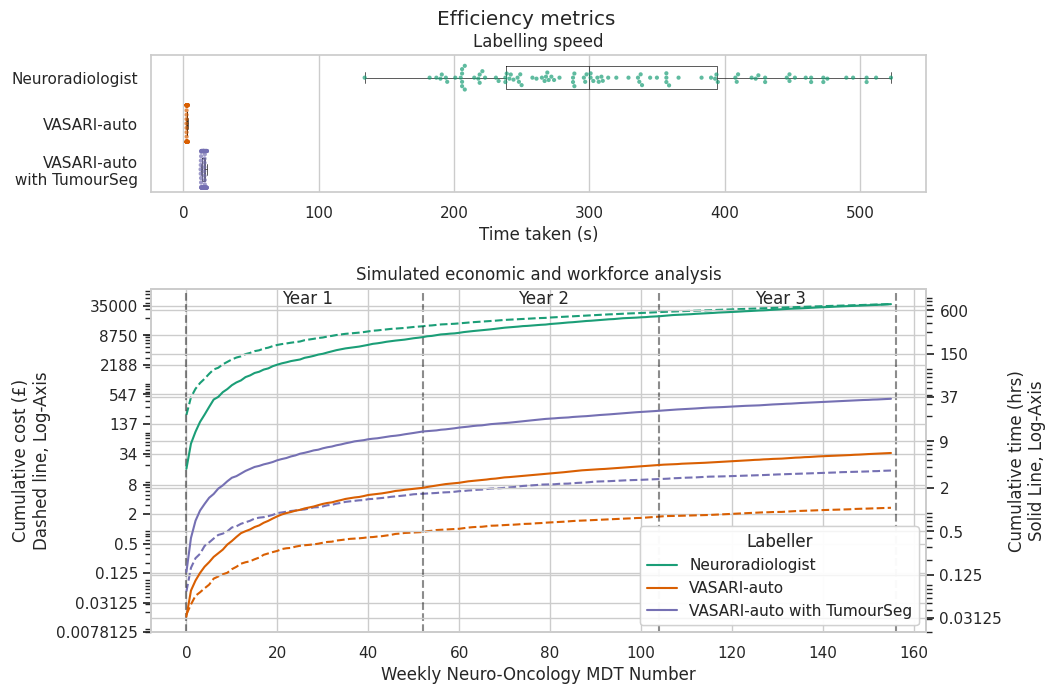

In [98]:
fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 5]},figsize=(10,7.5))

y='mode'
x='time_taken_seconds'
order = ['Neuroradiologist','VASARI-auto','VASARI-auto\n with TumourSeg']
# tt = stats.ttest_ind(all_data.loc[all_data[x]=='Consultant\nNeuroradiologist',y].values,all_data.loc[all_data[x]=='VASARI-auto',y].values)
# print(tt.pvalue)

sns.boxplot(data=all_data_with_seg,x=x,y=y,order=order,dodge=True,saturation=0.1,fill=False,color='k',fliersize=0,legend=None,linewidth=.5,width=.5,ax=ax[0])
sns.swarmplot(data=all_data_with_seg,x=x,y=y,order=order,hue=y,dodge=False,size=3,alpha=.7,ax=ax[0])

# annot = Annotator(ax,[('Consultant\nNeuroradiologist','VASARI-auto')],data=all_data,x=x,y=y)
# annot.configure(text_format='star',log='outside',verbose=2)
# annot.apply_test()

#asplit=True,gap=.1,inner='quart',dodge=True
ax[0].set(ylabel='')
ax[0].set(xlabel='Time taken (s)')
# ax[0].set_xscale('log')
# ticks = [2,4,8,16,32,64,128,256,512,1024]
# ticks = [1,2,4,8,16,20,25,50,100,200,400,600,1000]
# ax[0].set_xticks(ticks)
# ax[0].set_xticklabels(ticks)
# ax,test_results = annot.annotate()
# ax.legend(bbox_to_anchor=(1,1))
ax[0].set_title('Labelling speed')
# plt.savefig(figures_out+"efficiency_2.png",dpi=150,bbox_inches='tight')
# plt.savefig(figures_out+"efficiency_2.svg",dpi=150,bbox_inches='tight')

order = ['Neuroradiologist','VASARI-auto','VASARI-auto with TumourSeg']
sns.lineplot(data=timecourse, color="g",x='Epoch',y='Cumulative cost (£)',hue='Labeller',linestyle='--',ax=ax[1],hue_order=order)
g2=ax[1].axes.twinx()
sns.lineplot(data=timecourse, color="b",x='Epoch',y='Cumulative time (hrs)',ax=g2,hue='Labeller',hue_order=order)
ax[1].set(xlabel='Neuro-oncology MDT number')
ax[1].axvline(x = 0, color = 'k', label = 'axvline - full height',ls='--',alpha=0.5)
ax[1].axvline(x = 52, color = 'k', label = 'axvline - full height',ls='--',alpha=0.5)
ax[1].axvline(x = 52*2, color = 'k', label = 'axvline - full height',ls='--',alpha=0.5)
ax[1].axvline(x = 52*3, color = 'k', label = 'axvline - full height',ls='--',alpha=0.5)
ax[1].set_yscale('log')
ticks = [0.0078125,0.03125,.125,.5,2,8,34,137,547,2188,8750,35000]
ax[1].set_yticks(ticks)
ax[1].set_yticklabels(ticks)

g2.set_yscale('log')
ticks2 = [0.03125,.125,.5,2,9,37,150,600]
g2.set_yticks(ticks2)
g2.set_yticklabels(ticks2)

ax[1].set(xlabel='Weekly Neuro-Oncology MDT Number')
ax[1].set(title='Simulated economic and workforce analysis')
ax[1].set(ylabel='Cumulative cost (£)\nDashed line, Log-Axis')
g2.set(ylabel='Cumulative time (hrs)\nSolid Line, Log-Axis')

ax[1].annotate('Year 1',xy=(21,38000),zorder=1)
ax[1].annotate('Year 2',xy=((52+21),38000),zorder=1)
ax[1].annotate('Year 3',xy=((52+52+21),38000),zorder=1)

plt.subplots_adjust(wspace=0.05)
plt.subplots_adjust(hspace=.4)

fig.suptitle('Efficiency metrics',y=.94)

plt.savefig(figures_out+"Figure4.png",dpi=300,bbox_inches='tight')
plt.savefig(figures_out+"Figure4.svg",dpi=300,bbox_inches='tight')

/home/jruffle/.local/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 91.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jruffle/.local/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 83.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jruffle/.local/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 93.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jruffle/.local/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 87.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


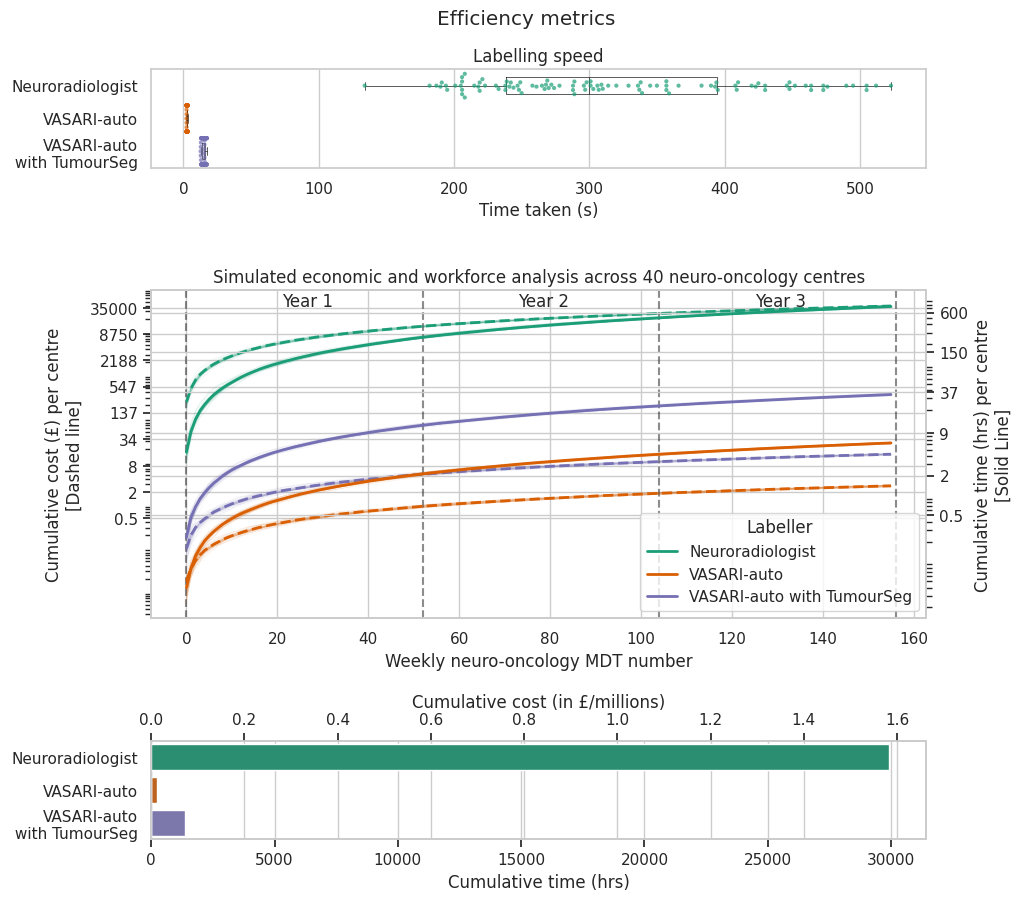

In [99]:
fig, ax = plt.subplots(3, 1, gridspec_kw={'height_ratios': [1.5, 5, 1.5]},figsize=(10,10))

y='mode'
x='time_taken_seconds'
order = ['Neuroradiologist','VASARI-auto','VASARI-auto\n with TumourSeg']
# tt = stats.ttest_ind(all_data.loc[all_data[x]=='Consultant\nNeuroradiologist',y].values,all_data.loc[all_data[x]=='VASARI-auto',y].values)
# print(tt.pvalue)

sns.boxplot(data=all_data_with_seg,x=x,y=y,order=order,dodge=True,saturation=0.1,fill=False,color='k',fliersize=0,legend=None,linewidth=.5,width=.5,ax=ax[0])
sns.swarmplot(data=all_data_with_seg,x=x,y=y,order=order,hue=y,dodge=False,size=3,alpha=.7,ax=ax[0])

# annot = Annotator(ax,[('Consultant\nNeuroradiologist','VASARI-auto')],data=all_data,x=x,y=y)
# annot.configure(text_format='star',log='outside',verbose=2)
# annot.apply_test()

#asplit=True,gap=.1,inner='quart',dodge=True
ax[0].set(ylabel='')
ax[0].set(xlabel='Time taken (s)')
# ax[0].set_xscale('log')
# ticks = [2,4,8,16,32,64,128,256,512,1024]
# ticks = [1,2,4,8,16,20,25,50,100,200,400,600,1000]
# ax[0].set_xticks(ticks)
# ax[0].set_xticklabels(ticks)
# ax,test_results = annot.annotate()
# ax.legend(bbox_to_anchor=(1,1))
ax[0].set_title('Labelling speed')
# plt.savefig(figures_out+"efficiency_2.png",dpi=150,bbox_inches='tight')
# plt.savefig(figures_out+"efficiency_2.svg",dpi=150,bbox_inches='tight')

order = ['Neuroradiologist','VASARI-auto','VASARI-auto with TumourSeg']

sns.lineplot(data=timecourse_multi_centre, ax=ax[1],color="g",x='Epoch',y='Cumulative cost (£)',hue='Labeller',linestyle='--',units='Centre',estimator=None,lw=.1,alpha=.3,legend=False)
sns.lineplot(data=timecourse_multi_centre, ax=ax[1],color="g",x='Epoch',y='Cumulative cost (£)',hue='Labeller',linestyle='--',lw=2,legend=False)

g2=ax[1].axes.twinx()
sns.lineplot(data=timecourse_multi_centre,ax=g2, color="b",x='Epoch',y='Cumulative time (hrs)',hue='Labeller',units='Centre',estimator=None,lw=.1,alpha=.3,legend=False)
sns.lineplot(data=timecourse_multi_centre, ax=g2,color="b",x='Epoch',y='Cumulative time (hrs)',hue='Labeller',lw=2)

ax[1].set(xlabel='Neuro-oncology MDT number')
ax[1].axvline(x = 0, color = 'k', label = 'axvline - full height',ls='--',alpha=0.5,zorder=1)
ax[1].axvline(x = 52, color = 'k', label = 'axvline - full height',ls='--',alpha=0.5,zorder=1)
ax[1].axvline(x = 52*2, color = 'k', label = 'axvline - full height',ls='--',alpha=0.5,zorder=1)
ax[1].axvline(x = 52*3, color = 'k', label = 'axvline - full height',ls='--',alpha=0.5,zorder=1)

ticks = [.5,2,8,34,137,547,2188,8750,35000]
ax[1].set_yscale('log')
ax[1].set_yticks(ticks)
ax[1].set_yticklabels(ticks)
ax[1].set_yscale('log')
ax[1].set_yticks(ticks)
ax[1].set_yticklabels(ticks)

ticks = [.5,2,9,37,150,600]
g2.set_yscale('log')
g2.set_yticks(ticks)
g2.set_yticklabels(ticks)
# g4.set_yscale('log')
# g4.set_yticks(ticks)
# g4.set_yticklabels(ticks)

ax[1].set(xlabel='Weekly neuro-oncology MDT number')
ax[1].set(title='Simulated economic and workforce analysis across 40 neuro-oncology centres')
ax[1].set(ylabel='Cumulative cost (£) per centre\n[Dashed line]')
g2.set(ylabel='Cumulative time (hrs) per centre\n[Solid Line]')



# sns.lineplot(data=timecourse, color="g",x='Epoch',y='Cumulative cost (£)',hue='Labeller',linestyle='--',ax=ax[1],hue_order=order)
# g2=ax[1].axes.twinx()
# sns.lineplot(data=timecourse, color="b",x='Epoch',y='Cumulative time (hrs)',ax=g2,hue='Labeller',hue_order=order)
# ax[1].set(xlabel='Neuro-oncology MDT number')
# ax[1].axvline(x = 0, color = 'k', label = 'axvline - full height',ls='--',alpha=0.5)
# ax[1].axvline(x = 52, color = 'k', label = 'axvline - full height',ls='--',alpha=0.5)
# ax[1].axvline(x = 52*2, color = 'k', label = 'axvline - full height',ls='--',alpha=0.5)
# ax[1].axvline(x = 52*3, color = 'k', label = 'axvline - full height',ls='--',alpha=0.5)
# ax[1].set_yscale('log')
# ticks = [0.0078125,0.03125,.125,.5,2,8,34,137,547,2188,8750,35000]
# ax[1].set_yticks(ticks)
# ax[1].set_yticklabels(ticks)

# g2.set_yscale('log')
# ticks2 = [0.03125,.125,.5,2,9,37,150,600]
# g2.set_yticks(ticks2)
# g2.set_yticklabels(ticks2)

# ax[1].set(xlabel='Weekly Neuro-Oncology MDT Number')
# ax[1].set(title='Simulated economic and workforce analysis')
# ax[1].set(ylabel='Cumulative cost (£)\nDashed line, Log-Axis')
# g2.set(ylabel='Cumulative time (hrs)\nSolid Line, Log-Axis')

ax[1].annotate('Year 1',xy=(21,38000),zorder=1)
ax[1].annotate('Year 2',xy=((52+21),38000),zorder=1)
ax[1].annotate('Year 3',xy=((52+52+21),38000),zorder=1)

order = ['Neuroradiologist','VASARI-auto','VASARI-auto\n with TumourSeg']
totals = timecourse_multi_centre.loc[timecourse_multi_centre['Epoch']==(52*3)-1].groupby(by='Labeller').sum()
totals['Cumulative cost (in £/millions)']=totals['Cumulative cost (£)']/1000000
totals.reset_index(drop=False,inplace=True)
totals.loc[totals['Labeller']=='VASARI-auto with TumourSeg','Labeller']='VASARI-auto\n with TumourSeg'

h = sns.barplot(data=totals,x='Cumulative time (hrs)',y='Labeller',order=order,hue='Labeller',ax=ax[2],legend=False)
h2=ax[2].axes.twiny()
sns.barplot(data=totals,y='Labeller',ax=h2,order=order,hue='Labeller',x='Cumulative cost (in £/millions)',legend=False)
ax[2].set(ylabel='')

# ax[2].set_title('Cumulative demands')

plt.subplots_adjust(wspace=0.05)
plt.subplots_adjust(hspace=.7)

fig.suptitle('Efficiency metrics',y=.94)

plt.savefig(figures_out+"Figure4_new.png",dpi=300,bbox_inches='tight')
plt.savefig(figures_out+"Figure4_new.svg",dpi=300,bbox_inches='tight')

In [100]:
timecourse_multi_centre.loc[timecourse_multi_centre['Epoch']==(52*3)-1].groupby(by='Labeller').describe()

Epoch                                          \
                           count   mean  std    min    25%    50%    75%   
Labeller                                                                   
Neuroradiologist            40.0  155.0  0.0  155.0  155.0  155.0  155.0   
VASARI-auto                 40.0  155.0  0.0  155.0  155.0  155.0  155.0   
VASARI-auto with TumourSeg  40.0  155.0  0.0  155.0  155.0  155.0  155.0   

                                  Cost (£)                                     \
                              max    count        mean        std         min   
Labeller                                                                        
Neuroradiologist            155.0     40.0  253.978774  62.729027  154.606298   
VASARI-auto                 155.0     40.0    0.017529   0.007654    0.004570   
VASARI-auto with TumourSeg  155.0     40.0    0.088253   0.032743    0.036392   

                                                                            \
                                   25%         50%         75%         max   
Labeller                                                                     
Neuroradiologist            202.523938  259.146517  298.109926  388.234747   
VASARI-auto                   0.011454    0.017348    0.020235    0.037768   
VASARI-auto with TumourSeg    0.063782    0.080379    0.099781    0.165741   

                           Time (s)                                           \
                              count          mean          std           min   
Labeller                                                                       
Neuroradiologist               40.0  16922.116983  4169.449788  10285.018410   
VASARI-auto                    40.0    140.254248    39.291688     79.788030   
VASARI-auto with TumourSeg     40.0    778.653821   198.821592    441.906464   

                                                                      \
                                     25%           50%           75%   
Labeller                                                               
Neuroradiologist            13535.383758  16861.346030  20498.280206   
VASARI-auto                   104.553531    136.943221    176.586654   
VASARI-auto with TumourSeg    606.026120    743.821021    980.090818   

                                         Patient load                     \
                                     max        count    mean        std   
Labeller                                                                   
Neuroradiologist            24055.151983         40.0  51.750  12.452474   
VASARI-auto                   210.092296         40.0  50.575  14.041856   
VASARI-auto with TumourSeg   1066.605213         40.0  51.750  13.392976   

                                                            \
                             min    25%   50%    75%   max   
Labeller                                                     
Neuroradiologist            30.0  41.00  50.0  63.00  75.0   
VASARI-auto                 30.0  37.75  49.0  63.25  75.0   
VASARI-auto with TumourSeg  30.0  39.75  49.0  65.25  72.0   

                           Cumulative cost (£)                            \
                                         count          mean         std   
Labeller                                                                   
Neuroradiologist                          40.0  39586.110908  843.184550   
VASARI-auto                               40.0      2.788485    0.091782   
VASARI-auto with TumourSeg                40.0     14.983330    0.496951   

                                                                      \
                                     min           25%           50%   
Labeller                                                               
Neuroradiologist            37757.159776  39140.706003  39480.720845   
VASARI-auto                     2.606368      2.712267      2.812833   
VASARI-auto with TumourSeg     13.795964     14.71813

In [101]:
timecourse_multi_centre.loc[timecourse_multi_centre['Epoch']==(52*3)-1].groupby(by='Labeller').describe()

Epoch                                          \
                           count   mean  std    min    25%    50%    75%   
Labeller                                                                   
Neuroradiologist            40.0  155.0  0.0  155.0  155.0  155.0  155.0   
VASARI-auto                 40.0  155.0  0.0  155.0  155.0  155.0  155.0   
VASARI-auto with TumourSeg  40.0  155.0  0.0  155.0  155.0  155.0  155.0   

                                  Cost (£)                                     \
                              max    count        mean        std         min   
Labeller                                                                        
Neuroradiologist            155.0     40.0  253.978774  62.729027  154.606298   
VASARI-auto                 155.0     40.0    0.017529   0.007654    0.004570   
VASARI-auto with TumourSeg  155.0     40.0    0.088253   0.032743    0.036392   

                                                                            \
                                   25%         50%         75%         max   
Labeller                                                                     
Neuroradiologist            202.523938  259.146517  298.109926  388.234747   
VASARI-auto                   0.011454    0.017348    0.020235    0.037768   
VASARI-auto with TumourSeg    0.063782    0.080379    0.099781    0.165741   

                           Time (s)                                           \
                              count          mean          std           min   
Labeller                                                                       
Neuroradiologist               40.0  16922.116983  4169.449788  10285.018410   
VASARI-auto                    40.0    140.254248    39.291688     79.788030   
VASARI-auto with TumourSeg     40.0    778.653821   198.821592    441.906464   

                                                                      \
                                     25%           50%           75%   
Labeller                                                               
Neuroradiologist            13535.383758  16861.346030  20498.280206   
VASARI-auto                   104.553531    136.943221    176.586654   
VASARI-auto with TumourSeg    606.026120    743.821021    980.090818   

                                         Patient load                     \
                                     max        count    mean        std   
Labeller                                                                   
Neuroradiologist            24055.151983         40.0  51.750  12.452474   
VASARI-auto                   210.092296         40.0  50.575  14.041856   
VASARI-auto with TumourSeg   1066.605213         40.0  51.750  13.392976   

                                                            \
                             min    25%   50%    75%   max   
Labeller                                                     
Neuroradiologist            30.0  41.00  50.0  63.00  75.0   
VASARI-auto                 30.0  37.75  49.0  63.25  75.0   
VASARI-auto with TumourSeg  30.0  39.75  49.0  65.25  72.0   

                           Cumulative cost (£)                            \
                                         count          mean         std   
Labeller                                                                   
Neuroradiologist                          40.0  39586.110908  843.184550   
VASARI-auto                               40.0      2.788485    0.091782   
VASARI-auto with TumourSeg                40.0     14.983330    0.496951   

                                                                      \
                                     min           25%           50%   
Labeller                                                               
Neuroradiologist            37757.159776  39140.706003  39480.720845   
VASARI-auto                     2.606368      2.712267      2.812833   
VASARI-auto with TumourSeg     13.795964     14.71813

In [102]:
dice_df['Kappa']=0
dice_df['Accuracy']=0
dice_df['VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using TumourSeg model Kappa']=0

# 'Neuroradiologist VASARI (GT):VASARI-auto accuracy','VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using TumourSeg model accuracy']

dummies=False

for i, row in dice_df.iterrows():
    pt = row['filename']
    # print(i)

    neurorads = all_data.loc[(all_data['filename']==pt)&(all_data['mode']=='Consultant\nNeuroradiologist')].reset_index(drop=True).iloc[0,:]
    vasari_auto = all_data.loc[(all_data['filename']==pt)&(all_data['mode']!='Consultant\nNeuroradiologist')].reset_index(drop=True).iloc[0,:]

    vasari_auto_tumour_seg=all_data.loc[(all_data['filename']==pt)&(all_data['DataOrigin']=='TumourSeg')].reset_index(drop=True).iloc[0,:]
    vasari_auto_only=all_data.loc[(all_data['filename']==pt)&(all_data['DataOrigin']=='HandDrawn')&(all_data['mode']!='Consultant\nNeuroradiologist')].reset_index(drop=True).iloc[0,:]
    
    if dummies:
        for f in use_these:
            one_hot = pd.get_dummies(neurorads[f],prefix=f)
            neurorads = neurorads.drop(f,axis = 1)
            neurorads = neurorads.join(one_hot)

            one_hot = pd.get_dummies(vasari_auto[f],prefix=f)
            vasari_auto = vasari_auto.drop(f,axis = 1)
            vasari_auto = vasari_auto.join(one_hot)

            one_hot = pd.get_dummies(vasari_auto_tumour_seg[f],prefix=f)
            vasari_auto_tumour_seg = vasari_auto_tumour_seg.drop(f,axis = 1)
            vasari_auto_tumour_seg = vasari_auto_tumour_seg.join(one_hot)


            one_hot = pd.get_dummies(vasari_auto_only[f],prefix=f)
            vasari_auto_only = vasari_auto_only.drop(f,axis = 1)
            vasari_auto_only = vasari_auto_only.join(one_hot)
    
    
    cks = cohen_kappa_score(neurorads[use_these].values.astype(int), vasari_auto[use_these].values.astype(int),weights='linear')
    acc = accuracy_score(y_true=neurorads[use_these].values.astype(int),y_pred=vasari_auto[use_these].values.astype(int))

    cks_vasari_auto = cohen_kappa_score(vasari_auto_tumour_seg[use_these].values.astype(int), vasari_auto_only[use_these].values.astype(int),weights='linear')
    
    dice_df.loc[i,'Kappa']=cks
    dice_df.loc[i,'Accuracy']=acc*100
    dice_df.loc[i,'VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using TumourSeg model Kappa']=cks_vasari_auto

/tmp/ipykernel_3704756/1621446180.py:44: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8015267175572519' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dice_df.loc[i,'Kappa']=cks
/tmp/ipykernel_3704756/1621446180.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '69.23076923076923' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dice_df.loc[i,'Accuracy']=acc*100
/tmp/ipykernel_3704756/1621446180.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9078014184397163' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dice_df.loc[i,'VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using TumourSeg model K

In [103]:
# dice_df['VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using TumourSeg model Kappa'].value_counts()

In [104]:
# dice_df['Age']=dice_df['Age'].astype(float)
# ages = [20,30,40,50,60,70,80,90]
# kappa_m = []
# kappa_f = []
# acc_m = []
# acc_f = []

# compartments = ['Female','Male']

# for a in ages:
#     for c in compartments:
#         k = dice_df.loc[(dice_df['Age'].between(a-10,a+10))&(dice_df['Sex']==c),'Kappa'].mean()
#         a = dice_df.loc[(dice_df['Age'].between(a-10,a+10))&(dice_df['Sex']==c),'Accuracy'].mean()

#         if c == 'Female':
#             kappa_f.append(k)
#             acc_f.append(a)

#         if c == 'Male':
#             kappa_m.append(k)
#             acc_m.append(a)

# polar_equity = pd.DataFrame(ages,columns=['Age'])
# polar_equity["Cohen's Kappa - Female"]=kappa_f
# polar_equity["Cohen's Kappa - Male"]=kappa_m
# polar_equity["Accuracy - Female"]=acc_f
# polar_equity["Accuracy - Male"]=acc_m
# polar_equity

In [105]:
dice_df

filename                                filename_hand_label  \
0   UPENN-GBM-00575_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
1   UPENN-GBM-00589_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
2   UPENN-GBM-00591_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
3   UPENN-GBM-00601_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
4   UPENN-GBM-00604_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
5   UPENN-GBM-00611_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
6       UCSF-PDGM-0486  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
7   UPENN-GBM-00159_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
8   UPENN-GBM-00054_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
9       UCSF-PDGM-0243  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
10  UPENN-GBM-00031_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
11  UPENN-GBM-00558_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
12      UCSF-PDGM-0232  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
13  UPENN-GBM-00349_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
14      UCSF-PDGM-0297  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
15      UCSF-PDGM-0032  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
16  UPENN-GBM-00127_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
17  UPENN-GBM-00405_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
18      UCSF-PDGM-0336  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
19      UCSF-PDGM-0261  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
20  UPENN-GBM-00391_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
21  UPENN-GBM-00255_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
22  UPENN-GBM-00180_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
23  UPENN-GBM-00443_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
24      UCSF-PDGM-0007  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
25  UPENN-GBM-00242_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
26  UPENN-GBM-00364_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
27  UPENN-GBM-00478_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
28  UPENN-GBM-00173_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
29  UPENN-GBM-00526_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
30      UCSF-PDGM-0005  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
31  UPENN-GBM-00459_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
32      UCSF-PDGM-0446  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
33  UPENN-GBM-00093_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
34  UPENN-GBM-00384_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
35  UPENN-GBM-00533_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
36      UCSF-PDGM-0029  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
37      UCSF-PDGM-0395  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
38  UPENN-GBM-00545_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
39  UPENN-GBM-00519_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
40  UPENN-GBM-00164_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
41      UCSF-PDGM-0538  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
42      UCSF-PDGM-0357  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
43  UPENN-GBM-00407_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
44  UPENN-GBM-00354_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
45  UPENN-GBM-00389_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
46  UPENN-GBM-00400_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
47  UPENN-GBM-00524_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
48  UPENN-GBM-00509_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
49  UPENN-GBM-00560_11  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
50      UCSF-PDGM-0486  /home/jruffle/OneDrive/PhD/forFAITH/neurorad_h...   
51      UC

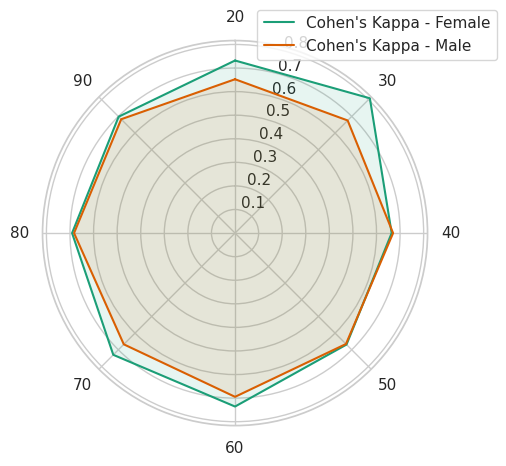

In [106]:
dice_df['Age']=dice_df['Age'].astype(float)
ages = [20,30,40,50,60,70,80,90]
kappa_m = []
kappa_f = []
acc_m = []
acc_f = []

compartments = ['Female','Male']

for a in ages:
    for c in compartments:
        k = dice_df.loc[(dice_df['Age'].between(a-10,a+10))&(dice_df['Sex']==c),'Kappa'].mean()
        a = dice_df.loc[(dice_df['Age'].between(a-10,a+10))&(dice_df['Sex']==c),'Accuracy'].mean()

        if c == 'Female':
            kappa_f.append(k)
            acc_f.append(a)

        if c == 'Male':
            kappa_m.append(k)
            acc_m.append(a)

polar_equity = pd.DataFrame(ages,columns=['Age'])
polar_equity["Cohen's Kappa - Female"]=kappa_f
polar_equity["Cohen's Kappa - Male"]=kappa_m
polar_equity["Accuracy - Female"]=acc_f
polar_equity["Accuracy - Male"]=acc_m
polar_equity
categories = polar_equity['Age']
q1 = polar_equity["Cohen's Kappa - Female"]
q2 = polar_equity["Cohen's Kappa - Male"]
label_loc = np.linspace(start=0, stop=2*np.pi, num=len(q1)+1)

ax=plt.figure(figsize=(5, 5))
ax=plt.subplot(polar=True)

compartment_order = ["Cohen's Kappa - Female","Cohen's Kappa - Male"]
compartment_order_counter=0
for q in [q1, q2]:
    ax.plot(label_loc, np.r_[q, q[0]], label=compartment_order[compartment_order_counter])
    ax.fill(label_loc, np.r_[q, q[0]], alpha=.1,label='_nolegend_')
    compartment_order_counter+=1
# plt.title('TumourSeg: age equity')
lines, labels = plt.thetagrids(np.degrees(label_loc[:-1]), labels=categories)
# ax.set(ylim=(0.99,1.))
# ax.set(yticks=yticks)
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

ax.set_rlabel_position(15)

# ax.set_thetagrids(np.degrees(angles), labels)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
# plt.legend()

# plt.savefig(figures_out+"dice_equitable_age.png",dpi=150,bbox_inches='tight')
# plt.savefig(figures_out+"dice_equitable_age.svg",dpi=150,bbox_inches='tight')

plt.show()

/tmp/ipykernel_3704756/261597904.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.71978022]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  rads_ira.loc[rads_ira['Age'].between(pt_age-5,pt_age+5),"Cohen's Kappa"]+=cks
/tmp/ipykernel_3704756/261597904.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.71978022 0.71978022]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  rads_ira.loc[rads_ira['Age'].between(pt_age-10,pt_age+10),"Cohen's Kappa - Female"]+=cks
/tmp/ipykernel_3704756/261597904.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.5778781 0.5778781]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

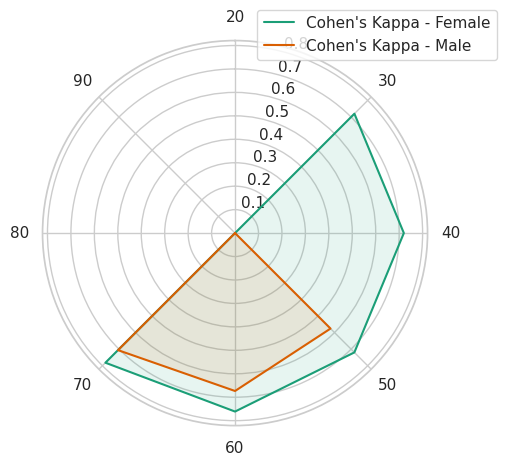

In [107]:

reporters = ['KPB','HH']

ages = [20,30,40,50,60,70,80,90]
rads_ira = pd.DataFrame(ages,columns=['Age'])
rads_ira["Cohen's Kappa"]=0
rads_ira["Cohen's Kappa - Female"]=0
rads_ira["Cohen's Kappa - Male"]=0
rads_ira["Counter"]=0
rads_ira["CounterM"]=0
rads_ira["CounterF"]=0

kappa_rads = []

for d in range(len(duplicate_files)):
    labeler0=[]
    labeler1=[]
    for r in range(len(reporters)):
        
        reporter_vals = duplicates.loc[(duplicates['filename']==duplicate_files[d])&(duplicates['reporter']==reporters[r])].copy().reset_index(drop=True)
        pt_age = dice_df.loc[dice_df['filename']==reporter_vals.iloc[0,0],'Age'].values[0]
        pt_sex = dice_df.loc[dice_df['filename']==reporter_vals.iloc[0,0],'Sex'].values[0]

        reporter_vals.drop(drop_cols,axis=1,inplace=True)
        if r == 0:
            labeler0 = reporter_vals.values[0]
        if r == 1:
            labeler1 = reporter_vals.values[0]

    cks = cohen_kappa_score(labeler0, labeler1,weights='linear')
    rads_ira.loc[rads_ira['Age'].between(pt_age-5,pt_age+5),"Cohen's Kappa"]+=cks
    rads_ira.loc[rads_ira['Age'].between(pt_age-5,pt_age+5),"Counter"]+=1

    if pt_sex == 'Male':
        rads_ira.loc[rads_ira['Age'].between(pt_age-10,pt_age+10),"Cohen's Kappa - Male"]+=cks
        rads_ira.loc[rads_ira['Age'].between(pt_age-10,pt_age+10),"CounterM"]+=1

    if pt_sex == 'Female':
        rads_ira.loc[rads_ira['Age'].between(pt_age-10,pt_age+10),"Cohen's Kappa - Female"]+=cks
        rads_ira.loc[rads_ira['Age'].between(pt_age-10,pt_age+10),"CounterF"]+=1
    
rads_ira["Cohen's Kappa"] = rads_ira["Cohen's Kappa"]/rads_ira['Counter']
rads_ira["Cohen's Kappa - Female"] = rads_ira["Cohen's Kappa - Female"]/rads_ira['CounterF']
rads_ira["Cohen's Kappa - Male"] = rads_ira["Cohen's Kappa - Male"]/rads_ira['CounterM']
rads_ira.fillna(0,inplace=True)

categories = rads_ira['Age']
q1 = rads_ira["Cohen's Kappa - Female"]
q2 = rads_ira["Cohen's Kappa - Male"]
label_loc = np.linspace(start=0, stop=2*np.pi, num=len(q1)+1)

ax=plt.figure(figsize=(5, 5))
ax=plt.subplot(polar=True)

compartment_order = ["Cohen's Kappa - Female","Cohen's Kappa - Male"]
compartment_order_counter=0
for q in [q1, q2]:
    ax.plot(label_loc, np.r_[q, q[0]], label=compartment_order[compartment_order_counter])
    ax.fill(label_loc, np.r_[q, q[0]], alpha=.1,label='_nolegend_')
    compartment_order_counter+=1
# plt.title('TumourSeg: age equity')
lines, labels = plt.thetagrids(np.degrees(label_loc[:-1]), labels=categories)
# ax.set(ylim=(0.99,1.))
# ax.set(yticks=yticks)
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

ax.set_rlabel_position(15)

# ax.set_thetagrids(np.degrees(angles), labels)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))

plt.show()

/tmp/ipykernel_3704756/1506884933.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.71978022]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  rads_ira.loc[rads_ira['Age'].between(pt_age-5,pt_age+5),"Cohen's Kappa"]+=cks
/tmp/ipykernel_3704756/1506884933.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.71978022 0.71978022]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  rads_ira.loc[rads_ira['Age'].between(pt_age-10,pt_age+10),"Cohen's Kappa - Female"]+=cks
/tmp/ipykernel_3704756/1506884933.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.5778781 0.5778781]' has dtype incompatible with int64, please explicitly cast to a compatible dtype fir

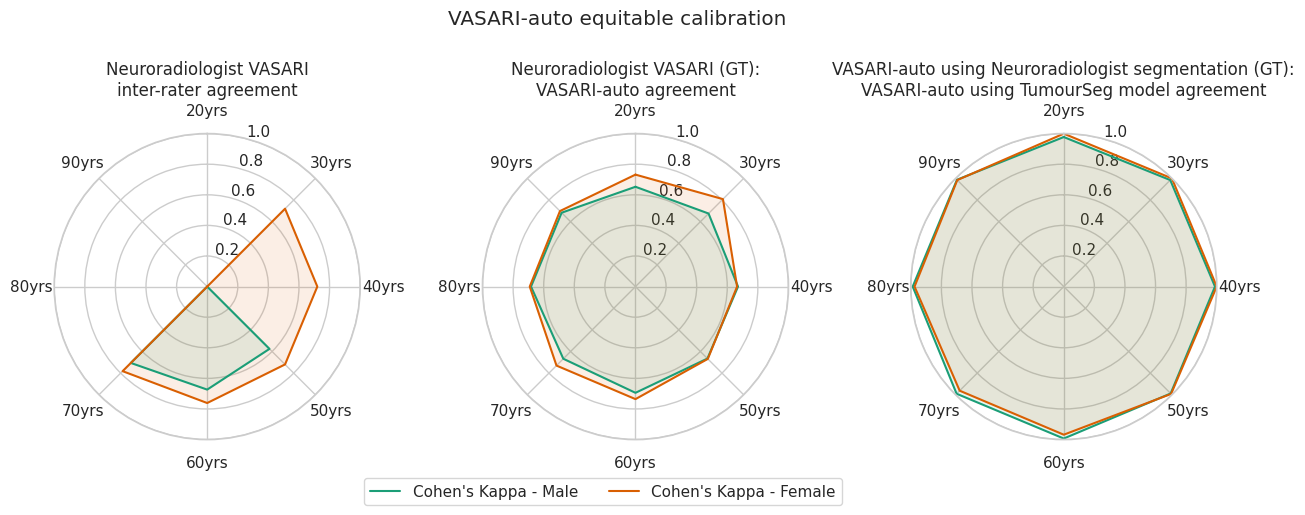

In [108]:
fig = plt.figure(figsize=(15,5))
comparison_order = ['Neuroradiologist VASARI\ninter-rater agreement',
                    'Neuroradiologist VASARI (GT):\nVASARI-auto agreement',
                   'VASARI-auto using Neuroradiologist segmentation (GT):\nVASARI-auto using TumourSeg model agreement']


ax1 = plt.subplot(131,projection = 'polar')

# AX1
reporters = ['KPB','HH']
ages = [20,30,40,50,60,70,80,90]
rads_ira = pd.DataFrame(ages,columns=['Age'])
rads_ira["Cohen's Kappa"]=0
rads_ira["Cohen's Kappa - Female"]=0
rads_ira["Cohen's Kappa - Male"]=0
rads_ira["Counter"]=0
rads_ira["CounterM"]=0
rads_ira["CounterF"]=0

kappa_rads = []

for d in range(len(duplicate_files)):
    labeler0=[]
    labeler1=[]
    for r in range(len(reporters)):
        
        reporter_vals = duplicates.loc[(duplicates['filename']==duplicate_files[d])&(duplicates['reporter']==reporters[r])].copy().reset_index(drop=True)
        pt_age = dice_df.loc[dice_df['filename']==reporter_vals.iloc[0,0],'Age'].values[0]
        pt_sex = dice_df.loc[dice_df['filename']==reporter_vals.iloc[0,0],'Sex'].values[0]

        reporter_vals.drop(drop_cols,axis=1,inplace=True)
        if r == 0:
            labeler0 = reporter_vals.values[0]
        if r == 1:
            labeler1 = reporter_vals.values[0]

    cks = cohen_kappa_score(labeler0, labeler1,weights='linear')
    rads_ira.loc[rads_ira['Age'].between(pt_age-5,pt_age+5),"Cohen's Kappa"]+=cks
    rads_ira.loc[rads_ira['Age'].between(pt_age-5,pt_age+5),"Counter"]+=1

    if pt_sex == 'Male':
        rads_ira.loc[rads_ira['Age'].between(pt_age-10,pt_age+10),"Cohen's Kappa - Male"]+=cks
        rads_ira.loc[rads_ira['Age'].between(pt_age-10,pt_age+10),"CounterM"]+=1

    if pt_sex == 'Female':
        rads_ira.loc[rads_ira['Age'].between(pt_age-10,pt_age+10),"Cohen's Kappa - Female"]+=cks
        rads_ira.loc[rads_ira['Age'].between(pt_age-10,pt_age+10),"CounterF"]+=1
    
rads_ira["Cohen's Kappa"] = rads_ira["Cohen's Kappa"]/rads_ira['Counter']
rads_ira["Cohen's Kappa - Female"] = rads_ira["Cohen's Kappa - Female"]/rads_ira['CounterF']
rads_ira["Cohen's Kappa - Male"] = rads_ira["Cohen's Kappa - Male"]/rads_ira['CounterM']
rads_ira.fillna(0,inplace=True)

categories = rads_ira['Age'].astype(str)+'yrs'
q1 = rads_ira["Cohen's Kappa - Male"]
q2 = rads_ira["Cohen's Kappa - Female"]
label_loc = np.linspace(start=0, stop=2*np.pi, num=len(q1)+1)

compartment_order = ["Cohen's Kappa - Male","Cohen's Kappa - Female"]
compartment_order_counter=0
for q in [q1, q2]:
    ax1.plot(label_loc, np.r_[q, q[0]], label=compartment_order[compartment_order_counter])
    ax1.fill(label_loc, np.r_[q, q[0]], alpha=.1,label='_nolegend_')
    compartment_order_counter+=1
# plt.title('TumourSeg: age equity')
lines, labels = plt.thetagrids(np.degrees(label_loc[:-1]), labels=categories)
ax1.set(ylim=(0,1.))
# ax1.set(yticks=yticks)
ax1.set_theta_offset(np.pi / 2)
ax1.set_theta_direction(-1)
ax1.set_rlabel_position(15)
ax1.set_title(comparison_order[0])
# ax1.set(yticks=yticks)

# ax.set_thetagrids(np.degrees(angles), labels)
# ax1.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))



# AX2
ax2 = plt.subplot(132,projection = 'polar')
dice_df['Age']=dice_df['Age'].astype(float)
ages = [20,30,40,50,60,70,80,90]
kappa_m = []
kappa_f = []
acc_m = []
acc_f = []

compartments = ['Female','Male']
for a in ages:
    for c in compartments:
        k = dice_df.loc[(dice_df['Age'].between(a-10,a+10))&(dice_df['Sex']==c),'Kappa'].mean()
        a = dice_df.loc[(dice_df['Age'].between(a-10,a+10))&(dice_df['Sex']==c),'Accuracy'].mean()

        if c == 'Female':
            kappa_f.append(k)
            acc_f.append(a)

        if c == 'Male':
            kappa_m.append(k)
            acc_m.append(a)

polar_equity = pd.DataFrame(ages,columns=['Age'])
polar_equity["Cohen's Kappa - Female"]=kappa_f
polar_equity["Cohen's Kappa - Male"]=kappa_m
polar_equity["Accuracy - Female"]=acc_f
polar_equity["Accuracy - Male"]=acc_m
polar_equity
categories = polar_equity['Age'].astype(str)+'yrs'
q1 = polar_equity["Cohen's Kappa - Male"]
q2 = polar_equity["Cohen's Kappa - Female"]
label_loc = np.linspace(start=0, stop=2*np.pi, num=len(q1)+1)
compartment_order = ["Cohen's Kappa - Male","Cohen's Kappa - Female"]
compartment_order_counter=0
for q in [q1, q2]:
    ax2.plot(label_loc, np.r_[q, q[0]], label=compartment_order[compartment_order_counter])
    ax2.fill(label_loc, np.r_[q, q[0]], alpha=.1,label='_nolegend_')
    compartment_order_counter+=1
# plt.title('TumourSeg: age equity')
lines, labels = plt.thetagrids(np.degrees(label_loc[:-1]), labels=categories)
ax2.set(ylim=(0,1.))
# ax2.set(yticks=yticks)
ax2.set_theta_offset(np.pi / 2)
ax2.set_theta_direction(-1)
ax2.set_rlabel_position(15)

# ax.set_thetagrids(np.degrees(angles), labels)
ax2.legend(loc='upper right', bbox_to_anchor=(1.2, -0.1),ncols=2)
ax2.set_title(comparison_order[1])


# # ax3
ax3 = plt.subplot(133,projection = 'polar')
dice_df['Age']=dice_df['Age'].astype(float)
ages = [20,30,40,50,60,70,80,90]
kappa_m = []
kappa_f = []
acc_m = []
acc_f = []

compartments = ['Female','Male']
for a in ages:
    for c in compartments:
        k = dice_df.loc[(dice_df['Age'].between(a-10,a+10))&(dice_df['Sex']==c),'VASARI-auto using Neuroradiologist segmentation (GT):VASARI-auto using TumourSeg model Kappa'].mean()
        a = dice_df.loc[(dice_df['Age'].between(a-10,a+10))&(dice_df['Sex']==c),'Accuracy'].mean()

        if c == 'Female':
            kappa_f.append(k)
            acc_f.append(a)

        if c == 'Male':
            kappa_m.append(k)
            acc_m.append(a)

polar_equity = pd.DataFrame(ages,columns=['Age'])
polar_equity["Cohen's Kappa - Female"]=kappa_f
polar_equity["Cohen's Kappa - Male"]=kappa_m
polar_equity["Accuracy - Female"]=acc_f
polar_equity["Accuracy - Male"]=acc_m
polar_equity
categories = polar_equity['Age'].astype(str)+'yrs'

q1 = polar_equity["Cohen's Kappa - Male"]
q2 = polar_equity["Cohen's Kappa - Female"]
label_loc = np.linspace(start=0, stop=2*np.pi, num=len(q1)+1)
compartment_order = ["Cohen's Kappa - Male","Cohen's Kappa - Female"]
compartment_order_counter=0
for q in [q1, q2]:
    ax3.plot(label_loc, np.r_[q, q[0]], label=compartment_order[compartment_order_counter])
    ax3.fill(label_loc, np.r_[q, q[0]], alpha=.1,label='_nolegend_')
    compartment_order_counter+=1
# plt.title('TumourSeg: age equity')
lines, labels = plt.thetagrids(np.degrees(label_loc[:-1]), labels=categories)
ax3.set(ylim=(0,1.))
# ax3.set(yticks=yticks)
ax3.set_theta_offset(np.pi / 2)
ax3.set_theta_direction(-1)
ax3.set_rlabel_position(15)

# ax.set_thetagrids(np.degrees(angles), labels)
# ax3.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
ax3.set_title(comparison_order[2])
# plt.legend()

# plt.savefig(figures_out+"dice_equitable_age.png",dpi=150,bbox_inches='tight')
# plt.savefig(figures_out+"dice_equitable_age.svg",dpi=150,bbox_inches='tight')


# ax3.set_title('Sex',y=1.075)

# ##age calibration
# categories = polar_dice['Age']
# q1 = polar_dice['NET']
# q2 = polar_dice['ET']
# q3 = polar_dice['PS']
# q4 = polar_dice['WT']
# label_loc = np.linspace(start=0, stop=2*np.pi, num=len(q1)+1)

# compartment_order_counter=0
# for q in [q1, q2, q3, q4]:
#     ax4.plot(label_loc, np.r_[q, q[0]], label=compartment_order[compartment_order_counter])
#     ax4.fill(label_loc, np.r_[q, q[0]], alpha=.1,label='_nolegend_')
#     compartment_order_counter+=1
# ax4.set_title('Age (years)')
# lines, labels = plt.thetagrids(np.degrees(label_loc[:-1]), labels=categories)
# ax4.set(ylim=(0.99,1.))
# # ax4.set_xticks(labels,fontsize=5)
# ax4.set_theta_offset(np.pi / 2)
# ax4.set_theta_direction(-1)
# ax4.set_rlabel_position(15)
# # ax.set_thetagrids(np.degrees(angles), labels)
# ax4.legend(loc='upper right', bbox_to_anchor=(.65, .5))
# # ax4.set_yticks(size=5)
# # ax4.set_xticks(size=5)


# ax1.set_box_aspect(1)
# ax2.set_box_aspect(1)
# ax3.set_box_aspect(1)
# # ax4.set_box_aspect(1)

# # plt.tight_layout()

plt.subplots_adjust(wspace=0.4)
# plt.subplots_adjust(hspace=0.15)

fig.suptitle("VASARI-auto equitable calibration",y=1.05)

plt.savefig(figures_out+"Figure5.png",dpi=300,bbox_inches='tight')
plt.savefig(figures_out+"Figure5.svg",dpi=300,bbox_inches='tight')

In [109]:
df['OS'].describe()

count     100.000000
mean      436.160000
std       462.214754
min        12.000000
25%       146.000000
50%       284.500000
75%       553.500000
max      2207.000000
Name: OS, dtype: float64

In [110]:
stats.ttest_ind(dice_df[dice_df['filename'].str.contains("UCSF")]['Age'].values, dice_df[dice_df['filename'].str.contains("UPENN")]['Age'].values)

TtestResult(statistic=-1.9678628392385762, pvalue=0.05191003137533312, df=98.0)

In [111]:
dice_df['PS'].astype(float).describe()

count    100.000000
mean       0.909747
std        0.063635
min        0.499032
25%        0.888640
50%        0.929354
75%        0.947081
max        0.979638
Name: PS, dtype: float64

In [112]:
dice_df['Age'].describe()

count    100.00000
mean      61.45600
std       13.49793
min       22.00000
25%       54.00000
50%       63.11500
75%       70.20750
max       86.87000
Name: Age, dtype: float64

In [114]:
all_upenn_ucsf_data = pd.read_csv('/media/jruffle/DATA1/SPM/radiomic_models_baseline_characteristics.csv',index_col=0)
keep = ['UPENN','UCSF']
all_upenn_ucsf_data=all_upenn_ucsf_data[all_upenn_ucsf_data['feature'].str.contains('|'.join(keep))].reset_index(drop=True)
# all_upenn_ucsf_data=all_upenn_ucsf_data[all_upenn_ucsf_data['feature'].isin(keep)]
all_upenn_ucsf_data

feature  original_shape_VoxelVolume_full_lesion  \
0         UCSF-PDGM-0004                                 49320.0   
1         UCSF-PDGM-0005                                 38964.0   
2         UCSF-PDGM-0007                                231167.0   
3         UCSF-PDGM-0008                                218511.0   
4         UCSF-PDGM-0009                                156284.0   
...                  ...                                     ...   
1167  UPENN-GBM-00626_21                                 54671.0   
1168  UPENN-GBM-00627_21                                 31449.0   
1169  UPENN-GBM-00628_21                                 40404.0   
1170  UPENN-GBM-00629_21                                105725.0   
1171  UPENN-GBM-00630_21                                138479.0   

      original_shape_MeshVolume_full_lesion  \
0                              49257.291667   
1                              38804.750000   
2                             230872.375000   
3                             218241.916667   
4                             156189.125000   
...                                     ...   
1167                           54521.958333   
1168                           31333.583333   
1169                           40295.791667   
1170                          105478.250000   
1171                          138196.708333   

      original_shape_SurfaceArea_full_lesion  \
0                                8948.011004   
1                               10614.159827   
2                               41060.586530   
3                               33166.769485   
4                               28537.581500   
...                                      ...   
1167                            15583.464555   
1168                            10708.082646   
1169                             7703.990513   
1170                            23572.577340   
1171                            36253.047074   

      original_shape_SurfaceVolumeRatio_full_lesion  \
0                                          0.181659   
1                                          0.273527   
2                                          0.177850   
3                                          0.151972   
4                                          0.182712   
...                                             ...   
1167                                       0.285820   
1168                                       0.341745   
1169                                       0.191186   
1170                                       0.223483   
1171                                       0.262329   

      original_shape_Compactness1_full_lesion  \
0                                    0.032833   
1                                    0.020021   
2                                    0.015655   
3                                    0.020385   
4                                    0.018279   
...                                       ...   
1167                                 0.015812   
1168                                 0.015954   
1169                                 0.033621   
1170                                 0.016443   
1171                                 0.011296   

      original_shape_Compactness2_full_lesion  \
0                                    0.383013   
1                                    0.142418   
2                                    0.087080   
3                                    0.147645   
4                                    0.118714   
...                                       ...   
1167                                 0.088839   
1168                                 0.090435   
1169                                 0.401629   
1170                                 0.096063   
1171                                 0.045333   

      original_shape_Sphericity_full_lesion  \
0                                  0.726225   
1                                  0.522222   
2                                  0.443241   
3                              

In [115]:
all_upenn_ucsf_data['age'].describe()

count    1172.000000
mean       38.070819
std        31.863580
min         0.000000
25%         0.000000
50%        52.025000
75%        65.560000
max        88.500000
Name: age, dtype: float64

In [116]:
upenn = pd.read_csv('/media/jruffle/DATA/brc3_rsync/NEUROONCOLOGY/DATA/UPENN-GBM/UPENN-GBM_clinical_info_v1.1.csv')
upenn['Final pathologic diagnosis (WHO 2021)']='Glioblastoma, IDH-wildtype'
upenn

ID Gender  Age_at_scan_years Survival_from_surgery_days  \
0    UPENN-GBM-00001_11      F              52.16              Not Available   
1    UPENN-GBM-00002_11      F              61.30                        291   
2    UPENN-GBM-00003_11      M              42.82              Not Available   
3    UPENN-GBM-00004_11      M              33.43              Not Available   
4    UPENN-GBM-00005_11      M              53.33              Not Available   
..                  ...    ...                ...                        ...   
666  UPENN-GBM-00626_21      F              57.19              Not Available   
667  UPENN-GBM-00627_21      F              57.40              Not Available   
668  UPENN-GBM-00628_21      M              55.09              Not Available   
669  UPENN-GBM-00629_21      M              71.44              Not Available   
670  UPENN-GBM-00630_21      M              65.47              Not Available   

         IDH1           MGMT            KPS GTR_over90percent  \
0    Wildtype  Not Available  Not Available                 Y   
1    Wildtype  Not Available  Not Available                 Y   
2    Wildtype  Not Available  Not Available                 Y   
3     NOS/NEC  Not Available  Not Available                 Y   
4    Wildtype  Not Available  Not Available                 Y   
..        ...            ...            ...               ...   
666  Wildtype   Unmethylated  Not Available    Not Applicable   
667  Wildtype  Not Available  Not Available    Not Applicable   
668  Wildtype  Not Available  Not Available    Not Applicable   
669  Wildtype   Unmethylated  Not Available    Not Applicable   
670  Wildtype     Methylated  Not Available    Not Applicable   

    Time_since_baseline_preop  PsP_TP_score  \
0                           0           NaN   
1                           0           NaN   
2                           0           NaN   
3                           0           NaN   
4                           0           NaN   
..                        ...           ...   
666                       234           5.0   
667             Not Available           4.0   
668             Not Available           6.0   
669             Not Available           6.0   
670             Not Available           2.0   

    Final pathologic diagnosis (WHO 2021)  
0              Glioblastoma, IDH-wildtype  
1              Glioblastoma, IDH-wildtype  
2              Glioblastoma, IDH-wildtype  
3              Glioblastoma, IDH-wildtype  
4              Glioblastoma, IDH-wildtype  
..                                    ...  
666            Glioblastoma, IDH-wildtype  
667            Glioblastoma, IDH-wildtype  
668            Glioblastoma, IDH-wildtype  
669            Glioblastoma, IDH-wildtype  
670            Glioblastoma, IDH-wildtype  

[671 rows x 11 columns]

In [117]:
ucsf = pd.read_csv('/media/jruffle/DATA/brc3_rsync/NEUROONCOLOGY/DATA/UCSF-PDGM/UCSF-PDGM-metadata.csv')
ucsf.rename(columns={'Sex':'Gender','Age at MRI':'Age_at_scan_years','OS':'Survival_from_surgery_days'},inplace=True)
ucsf

ID Gender  Age_at_scan_years  WHO CNS Grade  \
0    UCSF-PDGM-004      M                 66              4   
1    UCSF-PDGM-005      F                 80              4   
2    UCSF-PDGM-007      M                 70              4   
3    UCSF-PDGM-008      M                 70              4   
4    UCSF-PDGM-009      F                 68              4   
..             ...    ...                ...            ...   
496  UCSF-PDGM-537      M                 64              4   
497  UCSF-PDGM-538      F                 41              4   
498  UCSF-PDGM-539      M                 72              4   
499  UCSF-PDGM-540      F                 70              2   
500  UCSF-PDGM-541      F                 68              4   

               Final pathologic diagnosis (WHO 2021)    MGMT status  \
0                         Glioblastoma, IDH-wildtype       negative   
1                         Glioblastoma, IDH-wildtype  indeterminate   
2                         Glioblastoma, IDH-wildtype  indeterminate   
3                         Glioblastoma, IDH-wildtype       negative   
4                         Glioblastoma, IDH-wildtype       negative   
..                                               ...            ...   
496                       Glioblastoma, IDH-wildtype       positive   
497                       Glioblastoma, IDH-wildtype       negative   
498                       Glioblastoma, IDH-wildtype       positive   
499  Oligodendroglioma, IDH-mutant, 1p/19q-codeleted       positive   
500                       Glioblastoma, IDH-wildtype       negative   

     MGMT index       1p/19q           IDH  1-dead 0-alive  \
0           0.0          NaN      wildtype               1   
1           NaN          NaN      wildtype               1   
2           NaN          NaN      wildtype               1   
3           0.0          NaN      wildtype               1   
4           0.0          NaN      wildtype               1   
..          ...          ...           ...             ...   
496        16.0       intact      wildtype               0   
497         0.0       intact      wildtype               0   
498        12.0       intact      wildtype               0   
499        17.0  Co-deletion  IDH1 p.R132H               0   
500         0.0       intact      wildtype               0   

     Survival_from_surgery_days     EOR Biopsy prior to imaging  
0                        1303.0     STR                      No  
1                         274.0  biopsy                      No  
2                         417.0     STR                      No  
3                         185.0     STR                      No  
4                         389.0     STR                      No  
..                          ...     ...                     ...  
496                       334.0  biopsy                     Yes  
497                       287.0     GTR                      No  
498                       291.0     GTR                      No  
499                       215.0     STR                      No  
500                       199.0     GTR                      No  

[501 rows x 13 columns]

In [118]:
all_external = pd.concat([ucsf[['ID','Gender','Age_at_scan_years','Survival_from_surgery_days','Final pathologic diagnosis (WHO 2021)']],upenn[['ID','Gender','Age_at_scan_years','Survival_from_surgery_days','Final pathologic diagnosis (WHO 2021)']]])
all_external.loc[all_external['Survival_from_surgery_days']=='Not Available','Survival_from_surgery_days']=np.nan
all_external['Survival_from_surgery_days'] = all_external['Survival_from_surgery_days'].astype(float)
all_external['Final pathologic diagnosis (WHO 2021)'].value_counts()

Final pathologic diagnosis (WHO 2021)
Glioblastoma, IDH-wildtype                         1045
Astrocytoma, IDH-mutant                              90
Astrocytoma, IDH-wildtype                            24
Oligodendroglioma, IDH-mutant, 1p/19q-codeleted      13
Name: count, dtype: int64

In [119]:
all_data['OS'].describe()

count     100.000000
mean      436.160000
std       462.214754
min        12.000000
25%       146.000000
50%       284.500000
75%       553.500000
max      2207.000000
Name: OS, dtype: float64

In [120]:
all_external.loc[all_external['Final pathologic diagnosis (WHO 2021)']=='Glioblastoma, IDH-wildtype'].describe()

Age_at_scan_years  Survival_from_surgery_days
count        1045.000000                  825.000000
mean           62.215311                  440.614545
std            12.243826                  370.295394
min            18.650000                    3.000000
25%            55.000000                  167.000000
50%            62.970000                  363.000000
75%            71.000000                  589.000000
max            94.000000                 2207.000000

In [121]:
diagnoses = []
for i, row in dice_df.iterrows():
    diagnoses.append(all_upenn_ucsf_data.loc[all_upenn_ucsf_data['feature']==row['filename'],'diagnosis'])

In [122]:
np.unique(np.array(diagnoses))

array(['0', 'Glioblastoma, IDH-wildtype'], dtype=object)